### General Comment section

In [3]:
# This is the map weights maker

# the parameter used (gaussian smoothing) should be the same used in the paper 

# Workflow:
# First lap of weights for each images are collected in a "total" matrix
# from this matrix we take the maximum weighted pixel value across all the images
#we need this value to rerun the entire weighting process but normalizing respect to this maximum value
#as well. So finally we obtain mask ow weight rescaled from 0-1

#We already run the weight process and so we already have the maximum value = 3.81 (nearly)
# Unless we change gaussian smoothing or other parameters we don't need to rerun the weight process
# we only need to make the weighted mask with maximum value 3.81

#PRATICALLY:
#take image_ids
# run make_weights(image_ids, maximum=3.8177538) function

#Rewrite path
#Move function to utils file

In [1]:
import glob
import sys
import numpy as np
import imageio
import cv2
import random
from skimage import transform
import os
from tqdm import tqdm
from subprocess import check_output
import matplotlib.pyplot as plt
from importlib import import_module
from skimage import io
from skimage.io import imread
from skimage.transform import rotate
from skimage.transform import resize
from subprocess import check_output
# import albumentations as alb
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.morphology import watershed, remove_small_holes, remove_small_objects,\
label, erosion, dilation, local_maxima, skeletonize, binary_erosion, remove_small_holes
from skimage.feature import peak_local_max
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.segmentation import find_boundaries
# from scipy.misc import imsave

# from config import*

In [2]:
LoadMasksForWeight = './DATASET/TRAIN_VAL/all_cropped_masks/masks/'
LoadImgsForWeight = './DATASET/TRAIN_VAL/all_cropped_images/images/'
SaveWeightMasks = './DATASET/TRAIN_VAL/all_weighted_masks/masks/'

# image_ids = check_output(["ls", LoadMasksForWeight]).decode("utf8").split()
image_ids = os.listdir(LoadMasksForWeight)

ix = [int(x.split('.')[0]) for x in image_ids]
ix.sort()
image_ids = [str(x)+'.tiff' for x in ix]


def read_masks(image_id):
     
        mask = cv2.imread(LoadMasksForWeight + image_id)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        return mask
    
def read_images(image_id):
     
        mask = cv2.imread(LoadImgsForWeight + image_id)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        return mask
    
def read_masks_done(image_id):
     
        mask = cv2.imread(SaveWeightMasks + image_id)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        return mask
    
total = np.zeros((len(image_ids), 512, 512), dtype=np.float32)

In [5]:
total = np.zeros((len(image_ids), 512, 512), dtype=np.float32)
# def make_weights(image_ids, maximum=3.9330354):

# maximum = maximum

for ax_index, name in tqdm(enumerate(image_ids),total=len(image_ids)):

    target = read_masks(name)[:,:,0:1]
    target = target.astype(bool)
    target = remove_small_objects(target,min_size = 100)  
    target = remove_small_holes(target,200)
    target = target.astype(np.uint8)*255

#             target_ero = erosion(np.squeeze(target), selem=np.ones([3,3]))

    tar_inv = cv2.bitwise_not(target)
    tar_dil = dilation(np.squeeze(target), selem=np.ones([100, 100]))

    mask_sum = cv2.bitwise_and(tar_dil, tar_inv)
    # mask_sum1 = cv2.bitwise_or(mask_sum, target_ero)
    mask_sum1 = cv2.bitwise_or(mask_sum, target)

#             edge_strip = cv2.subtract(target, target_ero)
#             edge_strip = np.clip(edge_strip, 0, 1).astype(np.float32)

    null = np.zeros((target.shape[0], target.shape[1]), dtype = np.float32)
    weighted_mask = np.zeros((target.shape[0], target.shape[1]), dtype = np.float32)

    mask, nlabels_mask = ndimage.label(target)

    if nlabels_mask < 1:

        weighted_maskk = np.ones((target.shape[0], target.shape[1]), dtype = np.float32)

    else:


        mask = remove_small_objects(mask, min_size=25, connectivity=1, in_place=False)
        mask, nlabels_mask = ndimage.label(mask)
        mask_objs = ndimage.find_objects(mask)

#         edge_pre = ndimage.distance_transform_edt(target_ero==0)
#         edge = (1.4*np.exp((-1 * (edge_pre) ** 2) / (2 * (4 ** 2)))).astype(np.float32)


        for idx,obj in enumerate(mask_objs):
#                     print('obj {} on {}'.format(idx+1, nlabels_mask))
            new_image = np.zeros_like(mask)
            new_image[obj[0].start:obj[0].stop,obj[1].start:obj[1].stop] = mask[obj]  

            new_image = np.clip(new_image, 0, 1).astype(np.uint8)
            new_image *= 255

            inverted = cv2.bitwise_not(new_image)

            distance = ndimage.distance_transform_edt(inverted)
            w = np.zeros((distance.shape[0],distance.shape[1]), dtype=np.float32)
            w1 = np.zeros((distance.shape[0],distance.shape[1]), dtype=np.float32)

            for i in range(distance.shape[0]):

                for j in range(distance.shape[1]):

                    if distance[i, j] != 0:

                        w[i, j] = 1.*np.exp((-1 * (distance[i,j]) ** 2) / (2 * (25 ** 2)))

                    else:

                        w[i, j] = 1


            weighted_mask = cv2.add(weighted_mask, w, mask = mask_sum)

        # Complete from inner to edge with 1.5 as weight 
        weighted_mask = np.clip(weighted_mask, 1, weighted_mask.max())

        mul = target*1.5/255
        mul = mul.astype(np.float32)
        mul = np.clip(mul,1,mul.max())

#         board = cv2.multiply(edge, edge_strip)
#         board = np.clip(board,1,mul.max())
        weighted_maskk = cv2.multiply(weighted_mask, mul)

#         weighted_maskkk = cv2.multiply(weighted_maskk, board)


#     if (weighted_maskkk.max()/(maximum+0.0001))> 1:

#         break

#     weighted_maskkk = weighted_maskkk*1/maximum
    target = np.clip(target, 0 , 1)
    final_target = np.dstack((target, weighted_maskkk, null))

    mask_dir = SaveWeightMasks + '{}'.format(name)

    ###FOR MAXX EVALUATION########################
    total[ax_index] = weighted_maskk


#         print('saving {}'.format(name))
#         plt.imsave(fname=mask_dir,arr = final_target)



  0%|          | 0/2316 [00:00<?, ?it/s]

  0%|          | 1/2316 [00:04<2:59:11,  4.64s/it]

  0%|          | 2/2316 [00:09<3:06:44,  4.84s/it]

  0%|          | 3/2316 [00:16<3:30:46,  5.47s/it]

  0%|          | 4/2316 [00:21<3:24:55,  5.32s/it]

  0%|          | 5/2316 [00:26<3:20:35,  5.21s/it]

KeyboardInterrupt: 

In [3]:
total = np.zeros((len(image_ids), 512, 512), dtype=np.float32)
def make_weights(image_ids, maximum=3.8177538):

        maximum = maximum

        for ax_index, name in tqdm(enumerate(image_ids),total=len(image_ids)):

            target = read_masks(name)[:,:,0:1]
            target = target.astype(bool)
            target = remove_small_objects(target,min_size = 100)  
            target = remove_small_holes(target,200)
            target = target.astype(np.uint8)*255
            
#             target_ero = erosion(np.squeeze(target), selem=np.ones([3,3]))

            tar_inv = cv2.bitwise_not(target)
            tar_dil = dilation(np.squeeze(target), selem=np.ones([100, 100]))

            mask_sum = cv2.bitwise_and(tar_dil, tar_inv)
            # mask_sum1 = cv2.bitwise_or(mask_sum, target_ero)
            mask_sum1 = cv2.bitwise_or(mask_sum, target)

#             edge_strip = cv2.subtract(target, target_ero)
#             edge_strip = np.clip(edge_strip, 0, 1).astype(np.float32)

            null = np.zeros((target.shape[0], target.shape[1]), dtype = np.float32)
            weighted_mask = np.zeros((target.shape[0], target.shape[1]), dtype = np.float32)

            mask, nlabels_mask = ndimage.label(target)
            
            if nlabels_mask < 1:
                           
                weighted_maskk = np.ones((target.shape[0], target.shape[1]), dtype = np.float32)
                
            else:
            
            
                mask = remove_small_objects(mask, min_size=25, connectivity=1, in_place=False)
                mask, nlabels_mask = ndimage.label(mask)
                mask_objs = ndimage.find_objects(mask)

#                 edge_pre = ndimage.distance_transform_edt(target_ero==0)
#                 edge = (1.4*np.exp((-1 * (edge_pre) ** 2) / (2 * (4 ** 2)))).astype(np.float32)


                for idx,obj in enumerate(mask_objs):
#                     print('obj {} on {}'.format(idx+1, nlabels_mask))
                    new_image = np.zeros_like(mask)
                    new_image[obj[0].start:obj[0].stop,obj[1].start:obj[1].stop] = mask[obj]  

                    new_image = np.clip(new_image, 0, 1).astype(np.uint8)
                    new_image *= 255

                    inverted = cv2.bitwise_not(new_image)

                    distance = ndimage.distance_transform_edt(inverted)
                    w = np.zeros((distance.shape[0],distance.shape[1]), dtype=np.float32)
                    w1 = np.zeros((distance.shape[0],distance.shape[1]), dtype=np.float32)

                    for i in range(distance.shape[0]):

                        for j in range(distance.shape[1]):

                            if distance[i, j] != 0:

                                w[i, j] = 1.*np.exp((-1 * (distance[i,j]) ** 2) / (2 * (25 ** 2)))

                            else:

                                w[i, j] = 1


                    weighted_mask = cv2.add(weighted_mask, w, mask = mask_sum)

                # Complete from inner to edge with 1.5 as weight 
                weighted_mask = np.clip(weighted_mask, 1, weighted_mask.max())

#                 mul = target_ero*1.5/255
                mul = target*1.5/255
                mul = mul.astype(np.float32)
                mul = np.clip(mul,1,mul.max())

#                 board = cv2.multiply(edge, edge_strip)
#                 board = np.clip(board,1,mul.max())
                weighted_maskk = cv2.multiply(weighted_mask, mul)

#                 weighted_maskkk = cv2.multiply(weighted_maskk, board)

          
            if (weighted_maskk.max()/(maximum+0.0001))> 1:

                break

            weighted_maskk = weighted_maskk*1/maximum
            target = np.clip(target, 0 , 1)
            final_target = np.dstack((target, weighted_maskk, null))

            mask_dir = SaveWeightMasks + '{}'.format(name)
        
            ###FOR MAXX EVALUATION########################
            total[ax_index] = weighted_maskk
            
            
            print('saving {}'.format(name))
            plt.imsave(fname=mask_dir,arr = final_target)

In [5]:
make_weights(image_ids, maximum=3.8177538)

  0%|          | 1/2556 [00:04<3:18:45,  4.67s/it]

saving 0.tiff


/home/roberto/anaconda3/envs/tf_1.12/lib/python3.6/site-packages/skimage/morphology/misc.py:132: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
  0%|          | 2/2556 [00:09<3:26:00,  4.84s/it]

saving 1.tiff


  0%|          | 3/2556 [00:16<3:43:55,  5.26s/it]

saving 2.tiff


  0%|          | 4/2556 [00:20<3:34:45,  5.05s/it]

saving 3.tiff


  0%|          | 5/2556 [00:25<3:27:50,  4.89s/it]

saving 4.tiff


  0%|          | 6/2556 [00:30<3:38:35,  5.14s/it]

saving 5.tiff


  0%|          | 7/2556 [00:36<3:37:39,  5.12s/it]

saving 6.tiff


  0%|          | 8/2556 [00:40<3:30:29,  4.96s/it]

saving 7.tiff


  0%|          | 9/2556 [00:45<3:33:06,  5.02s/it]

saving 8.tiff


  0%|          | 10/2556 [00:50<3:27:21,  4.89s/it]

saving 9.tiff


  0%|          | 11/2556 [00:57<3:52:55,  5.49s/it]

saving 10.tiff


  0%|          | 12/2556 [01:03<4:05:31,  5.79s/it]

saving 11.tiff


  1%|          | 13/2556 [01:08<3:50:06,  5.43s/it]

saving 12.tiff


  1%|          | 14/2556 [01:12<3:39:18,  5.18s/it]

saving 13.tiff


  1%|          | 15/2556 [01:18<3:39:23,  5.18s/it]

saving 14.tiff


  1%|          | 16/2556 [01:23<3:39:45,  5.19s/it]

saving 15.tiff


  1%|          | 17/2556 [01:27<3:32:18,  5.02s/it]

saving 16.tiff


  1%|          | 18/2556 [01:32<3:27:56,  4.92s/it]

saving 17.tiff


  1%|          | 19/2556 [01:37<3:32:17,  5.02s/it]

saving 18.tiff


  1%|          | 20/2556 [01:43<3:35:01,  5.09s/it]

saving 19.tiff


  1%|          | 21/2556 [01:48<3:41:24,  5.24s/it]

saving 20.tiff


  1%|          | 22/2556 [01:54<3:44:17,  5.31s/it]

saving 21.tiff


  1%|          | 23/2556 [02:00<3:53:52,  5.54s/it]

saving 22.tiff


  1%|          | 24/2556 [02:04<3:41:21,  5.25s/it]

saving 23.tiff


  1%|          | 25/2556 [02:10<3:44:55,  5.33s/it]

saving 24.tiff


  1%|          | 26/2556 [02:16<3:49:39,  5.45s/it]

saving 25.tiff


  1%|          | 27/2556 [02:21<3:48:38,  5.42s/it]

saving 26.tiff


  1%|          | 28/2556 [02:27<3:56:59,  5.62s/it]

saving 27.tiff


  1%|          | 29/2556 [02:33<4:01:51,  5.74s/it]

saving 28.tiff


  1%|          | 30/2556 [02:38<3:57:22,  5.64s/it]

saving 29.tiff


  1%|          | 31/2556 [02:44<3:53:56,  5.56s/it]

saving 30.tiff


  1%|▏         | 32/2556 [02:50<4:00:19,  5.71s/it]

saving 31.tiff


  1%|▏         | 33/2556 [02:55<3:47:36,  5.41s/it]

saving 32.tiff


  1%|▏         | 34/2556 [03:00<3:46:54,  5.40s/it]

saving 33.tiff


  1%|▏         | 35/2556 [03:05<3:45:41,  5.37s/it]

saving 34.tiff


  1%|▏         | 36/2556 [03:11<3:44:54,  5.35s/it]

saving 35.tiff


  1%|▏         | 37/2556 [03:16<3:44:30,  5.35s/it]

saving 36.tiff


  1%|▏         | 38/2556 [03:21<3:44:19,  5.35s/it]

saving 37.tiff


  2%|▏         | 39/2556 [03:26<3:36:14,  5.15s/it]

saving 38.tiff


  2%|▏         | 40/2556 [03:31<3:30:04,  5.01s/it]

saving 39.tiff


  2%|▏         | 41/2556 [03:35<3:25:39,  4.91s/it]

saving 40.tiff


  2%|▏         | 42/2556 [03:40<3:23:17,  4.85s/it]

saving 41.tiff


  2%|▏         | 43/2556 [03:46<3:37:54,  5.20s/it]

saving 42.tiff


  2%|▏         | 44/2556 [03:51<3:39:04,  5.23s/it]

saving 43.tiff


  2%|▏         | 45/2556 [03:56<3:32:31,  5.08s/it]

saving 44.tiff


  2%|▏         | 46/2556 [04:01<3:35:25,  5.15s/it]

saving 45.tiff


  2%|▏         | 47/2556 [04:07<3:37:21,  5.20s/it]

saving 46.tiff


  2%|▏         | 48/2556 [04:12<3:39:14,  5.25s/it]

saving 47.tiff


  2%|▏         | 49/2556 [04:18<3:48:19,  5.46s/it]

saving 48.tiff


  2%|▏         | 50/2556 [04:26<4:18:10,  6.18s/it]

saving 49.tiff


  2%|▏         | 51/2556 [04:32<4:23:08,  6.30s/it]

saving 50.tiff


  2%|▏         | 52/2556 [04:37<4:03:03,  5.82s/it]

saving 51.tiff


  2%|▏         | 53/2556 [04:44<4:12:58,  6.06s/it]

saving 52.tiff


  2%|▏         | 54/2556 [04:50<4:12:16,  6.05s/it]

saving 53.tiff


  2%|▏         | 55/2556 [04:55<3:55:30,  5.65s/it]

saving 54.tiff


  2%|▏         | 56/2556 [04:59<3:44:02,  5.38s/it]

saving 55.tiff


  2%|▏         | 57/2556 [05:05<3:43:38,  5.37s/it]

saving 56.tiff


  2%|▏         | 58/2556 [05:09<3:35:12,  5.17s/it]

saving 57.tiff


  2%|▏         | 59/2556 [05:14<3:29:08,  5.03s/it]

saving 58.tiff


  2%|▏         | 60/2556 [05:19<3:24:45,  4.92s/it]

saving 59.tiff


  2%|▏         | 61/2556 [05:25<3:37:31,  5.23s/it]

saving 60.tiff


  2%|▏         | 62/2556 [05:31<3:46:46,  5.46s/it]

saving 61.tiff


  2%|▏         | 63/2556 [05:36<3:45:21,  5.42s/it]

saving 62.tiff


  3%|▎         | 64/2556 [05:42<3:53:32,  5.62s/it]

saving 63.tiff


  3%|▎         | 65/2556 [05:50<4:21:33,  6.30s/it]

saving 64.tiff


  3%|▎         | 66/2556 [05:55<4:09:44,  6.02s/it]

saving 65.tiff


  3%|▎         | 67/2556 [06:01<4:10:35,  6.04s/it]

saving 66.tiff


  3%|▎         | 68/2556 [06:10<4:42:37,  6.82s/it]

saving 67.tiff


  3%|▎         | 69/2556 [06:18<4:56:51,  7.16s/it]

saving 68.tiff


  3%|▎         | 70/2556 [06:23<4:26:40,  6.44s/it]

saving 69.tiff


  3%|▎         | 71/2556 [06:28<4:13:22,  6.12s/it]

saving 70.tiff


  3%|▎         | 72/2556 [06:33<3:56:55,  5.72s/it]

saving 71.tiff


  3%|▎         | 73/2556 [06:38<3:45:06,  5.44s/it]

saving 72.tiff


  3%|▎         | 74/2556 [06:44<3:52:19,  5.62s/it]

saving 73.tiff


  3%|▎         | 75/2556 [06:52<4:27:26,  6.47s/it]

saving 74.tiff


  3%|▎         | 76/2556 [06:58<4:14:26,  6.16s/it]

saving 75.tiff


  3%|▎         | 77/2556 [07:05<4:26:56,  6.46s/it]

saving 76.tiff


  3%|▎         | 78/2556 [07:12<4:35:31,  6.67s/it]

saving 77.tiff


  3%|▎         | 79/2556 [07:17<4:10:39,  6.07s/it]

saving 78.tiff


  3%|▎         | 80/2556 [07:23<4:17:16,  6.23s/it]

saving 79.tiff


  3%|▎         | 81/2556 [07:29<4:13:47,  6.15s/it]

saving 80.tiff


  3%|▎         | 82/2556 [07:34<3:55:33,  5.71s/it]

saving 81.tiff


  3%|▎         | 83/2556 [07:39<3:42:49,  5.41s/it]

saving 82.tiff


  3%|▎         | 84/2556 [07:44<3:41:45,  5.38s/it]

saving 83.tiff


  3%|▎         | 85/2556 [07:49<3:33:35,  5.19s/it]

saving 84.tiff


  3%|▎         | 86/2556 [07:53<3:27:19,  5.04s/it]

saving 85.tiff


  3%|▎         | 87/2556 [07:59<3:30:53,  5.12s/it]

saving 86.tiff


  3%|▎         | 88/2556 [08:03<3:25:11,  4.99s/it]

saving 87.tiff


  3%|▎         | 89/2556 [08:08<3:21:11,  4.89s/it]

saving 88.tiff


  4%|▎         | 90/2556 [08:14<3:33:49,  5.20s/it]

saving 89.tiff


  4%|▎         | 91/2556 [08:19<3:27:27,  5.05s/it]

saving 90.tiff


  4%|▎         | 92/2556 [08:23<3:22:53,  4.94s/it]

saving 91.tiff


  4%|▎         | 93/2556 [08:29<3:35:21,  5.25s/it]

saving 92.tiff


  4%|▎         | 94/2556 [08:34<3:28:58,  5.09s/it]

saving 93.tiff


  4%|▎         | 95/2556 [08:39<3:24:03,  4.97s/it]

saving 94.tiff


  4%|▍         | 96/2556 [08:44<3:28:14,  5.08s/it]

saving 95.tiff


  4%|▍         | 97/2556 [08:49<3:23:54,  4.98s/it]

saving 96.tiff


  4%|▍         | 98/2556 [08:53<3:20:16,  4.89s/it]

saving 97.tiff


  4%|▍         | 99/2556 [08:58<3:18:03,  4.84s/it]

saving 98.tiff


  4%|▍         | 100/2556 [09:03<3:15:57,  4.79s/it]

saving 99.tiff


  4%|▍         | 101/2556 [09:08<3:15:17,  4.77s/it]

saving 100.tiff


  4%|▍         | 102/2556 [09:12<3:13:52,  4.74s/it]

saving 101.tiff


  4%|▍         | 103/2556 [09:17<3:12:45,  4.71s/it]

saving 102.tiff


  4%|▍         | 104/2556 [09:22<3:11:58,  4.70s/it]

saving 103.tiff


  4%|▍         | 105/2556 [09:26<3:11:37,  4.69s/it]

saving 104.tiff


  4%|▍         | 106/2556 [09:31<3:11:14,  4.68s/it]

saving 105.tiff


  4%|▍         | 107/2556 [09:36<3:10:56,  4.68s/it]

saving 106.tiff


  4%|▍         | 108/2556 [09:41<3:20:32,  4.92s/it]

saving 107.tiff


  4%|▍         | 109/2556 [09:48<3:41:03,  5.42s/it]

saving 108.tiff


  4%|▍         | 110/2556 [09:55<4:08:19,  6.09s/it]

saving 109.tiff


  4%|▍         | 111/2556 [10:00<3:57:11,  5.82s/it]

saving 110.tiff
saving 111.tiff


  4%|▍         | 113/2556 [10:11<3:50:27,  5.66s/it]

saving 112.tiff


  4%|▍         | 114/2556 [10:16<3:37:47,  5.35s/it]

saving 113.tiff


  4%|▍         | 115/2556 [10:21<3:35:50,  5.31s/it]

saving 114.tiff


  5%|▍         | 116/2556 [10:27<3:36:27,  5.32s/it]

saving 115.tiff


  5%|▍         | 117/2556 [10:31<3:28:49,  5.14s/it]

saving 116.tiff


  5%|▍         | 118/2556 [10:38<3:46:04,  5.56s/it]

saving 117.tiff


  5%|▍         | 119/2556 [10:43<3:42:59,  5.49s/it]

saving 118.tiff


  5%|▍         | 120/2556 [10:48<3:33:50,  5.27s/it]

saving 119.tiff


  5%|▍         | 121/2556 [10:54<3:42:32,  5.48s/it]

saving 120.tiff


  5%|▍         | 122/2556 [10:59<3:40:39,  5.44s/it]

saving 121.tiff


  5%|▍         | 123/2556 [11:05<3:38:25,  5.39s/it]

saving 122.tiff


  5%|▍         | 124/2556 [11:10<3:36:39,  5.34s/it]

saving 123.tiff


  5%|▍         | 125/2556 [11:15<3:35:33,  5.32s/it]

saving 124.tiff


  5%|▍         | 126/2556 [11:20<3:27:45,  5.13s/it]

saving 125.tiff


  5%|▍         | 127/2556 [11:24<3:21:36,  4.98s/it]

saving 126.tiff


  5%|▌         | 128/2556 [11:29<3:16:59,  4.87s/it]

saving 127.tiff


  5%|▌         | 129/2556 [11:34<3:20:59,  4.97s/it]

saving 128.tiff


  5%|▌         | 130/2556 [11:39<3:16:36,  4.86s/it]

saving 129.tiff


  5%|▌         | 131/2556 [11:43<3:12:51,  4.77s/it]

saving 130.tiff


  5%|▌         | 132/2556 [11:48<3:10:02,  4.70s/it]

saving 131.tiff


  5%|▌         | 133/2556 [11:53<3:08:04,  4.66s/it]

saving 132.tiff


  5%|▌         | 134/2556 [11:58<3:14:31,  4.82s/it]

saving 133.tiff


  5%|▌         | 135/2556 [12:02<3:11:15,  4.74s/it]

saving 134.tiff


  5%|▌         | 136/2556 [12:07<3:16:13,  4.87s/it]

saving 135.tiff


  5%|▌         | 137/2556 [12:13<3:19:40,  4.95s/it]

saving 136.tiff


  5%|▌         | 138/2556 [12:17<3:15:08,  4.84s/it]

saving 137.tiff


  5%|▌         | 139/2556 [12:22<3:11:16,  4.75s/it]

saving 138.tiff


  5%|▌         | 140/2556 [12:27<3:15:51,  4.86s/it]

saving 139.tiff


  6%|▌         | 141/2556 [12:32<3:19:07,  4.95s/it]

saving 140.tiff


  6%|▌         | 142/2556 [12:38<3:28:13,  5.18s/it]

saving 141.tiff


  6%|▌         | 143/2556 [12:43<3:34:50,  5.34s/it]

saving 142.tiff


  6%|▌         | 144/2556 [12:49<3:32:44,  5.29s/it]

saving 143.tiff


  6%|▌         | 145/2556 [12:54<3:37:57,  5.42s/it]

saving 144.tiff


  6%|▌         | 146/2556 [13:00<3:35:08,  5.36s/it]

saving 145.tiff


  6%|▌         | 147/2556 [13:05<3:32:13,  5.29s/it]

saving 146.tiff


  6%|▌         | 148/2556 [13:10<3:36:55,  5.40s/it]

saving 147.tiff


  6%|▌         | 149/2556 [13:15<3:27:15,  5.17s/it]

saving 148.tiff


  6%|▌         | 150/2556 [13:19<3:19:32,  4.98s/it]

saving 149.tiff


  6%|▌         | 151/2556 [13:24<3:14:11,  4.84s/it]

saving 150.tiff


  6%|▌         | 152/2556 [13:29<3:10:20,  4.75s/it]

saving 151.tiff


  6%|▌         | 153/2556 [13:33<3:07:31,  4.68s/it]

saving 152.tiff


  6%|▌         | 154/2556 [13:38<3:05:36,  4.64s/it]

saving 153.tiff


  6%|▌         | 155/2556 [13:42<3:04:11,  4.60s/it]

saving 154.tiff


  6%|▌         | 156/2556 [13:47<3:03:16,  4.58s/it]

saving 155.tiff


  6%|▌         | 157/2556 [13:51<3:03:02,  4.58s/it]

saving 156.tiff


  6%|▌         | 158/2556 [13:56<3:02:28,  4.57s/it]

saving 157.tiff


  6%|▌         | 159/2556 [14:00<3:01:52,  4.55s/it]

saving 158.tiff


  6%|▋         | 160/2556 [14:05<3:01:32,  4.55s/it]

saving 159.tiff


  6%|▋         | 161/2556 [14:09<3:01:28,  4.55s/it]

saving 160.tiff


  6%|▋         | 162/2556 [14:14<3:01:07,  4.54s/it]

saving 161.tiff


  6%|▋         | 163/2556 [14:18<3:01:26,  4.55s/it]

saving 162.tiff


  6%|▋         | 164/2556 [14:23<3:01:01,  4.54s/it]

saving 163.tiff


  6%|▋         | 165/2556 [14:29<3:14:28,  4.88s/it]

saving 164.tiff


  6%|▋         | 166/2556 [14:33<3:10:05,  4.77s/it]

saving 165.tiff


  7%|▋         | 167/2556 [14:38<3:07:11,  4.70s/it]

saving 166.tiff


  7%|▋         | 168/2556 [14:43<3:12:10,  4.83s/it]

saving 167.tiff


  7%|▋         | 169/2556 [14:47<3:08:29,  4.74s/it]

saving 168.tiff


  7%|▋         | 170/2556 [14:52<3:05:53,  4.67s/it]

saving 169.tiff


  7%|▋         | 171/2556 [14:56<3:04:37,  4.64s/it]

saving 170.tiff


  7%|▋         | 172/2556 [15:02<3:10:23,  4.79s/it]

saving 171.tiff


  7%|▋         | 173/2556 [15:06<3:07:26,  4.72s/it]

saving 172.tiff


  7%|▋         | 174/2556 [15:11<3:05:12,  4.67s/it]

saving 173.tiff


  7%|▋         | 175/2556 [15:16<3:11:02,  4.81s/it]

saving 174.tiff


  7%|▋         | 176/2556 [15:20<3:07:54,  4.74s/it]

saving 175.tiff


  7%|▋         | 177/2556 [15:25<3:06:01,  4.69s/it]

saving 176.tiff


  7%|▋         | 178/2556 [15:30<3:04:04,  4.64s/it]

saving 177.tiff


  7%|▋         | 179/2556 [15:34<3:02:32,  4.61s/it]

saving 178.tiff


  7%|▋         | 180/2556 [15:39<3:01:17,  4.58s/it]

saving 179.tiff


  7%|▋         | 181/2556 [15:44<3:07:28,  4.74s/it]

saving 180.tiff


  7%|▋         | 182/2556 [15:49<3:18:58,  5.03s/it]

saving 181.tiff


  7%|▋         | 183/2556 [15:54<3:20:00,  5.06s/it]

saving 182.tiff


  7%|▋         | 184/2556 [16:00<3:21:07,  5.09s/it]

saving 183.tiff


  7%|▋         | 185/2556 [16:06<3:35:34,  5.46s/it]

saving 184.tiff


  7%|▋         | 186/2556 [16:11<3:31:11,  5.35s/it]

saving 185.tiff


  7%|▋         | 187/2556 [16:16<3:21:43,  5.11s/it]

saving 186.tiff


  7%|▋         | 188/2556 [16:21<3:21:30,  5.11s/it]

saving 187.tiff


  7%|▋         | 189/2556 [16:25<3:14:29,  4.93s/it]

saving 188.tiff


  7%|▋         | 190/2556 [16:30<3:09:25,  4.80s/it]

saving 189.tiff


  7%|▋         | 191/2556 [16:35<3:12:53,  4.89s/it]

saving 190.tiff


  8%|▊         | 192/2556 [16:39<3:10:07,  4.83s/it]

saving 191.tiff
saving 192.tiff


  8%|▊         | 194/2556 [16:50<3:18:00,  5.03s/it]

saving 193.tiff


  8%|▊         | 195/2556 [16:55<3:16:55,  5.00s/it]

saving 194.tiff


  8%|▊         | 196/2556 [17:00<3:15:52,  4.98s/it]

saving 195.tiff
saving 196.tiff


  8%|▊         | 198/2556 [17:10<3:18:25,  5.05s/it]

saving 197.tiff


  8%|▊         | 199/2556 [17:16<3:23:09,  5.17s/it]

saving 198.tiff


  8%|▊         | 200/2556 [17:21<3:28:18,  5.31s/it]

saving 199.tiff


  8%|▊         | 201/2556 [17:26<3:24:25,  5.21s/it]

saving 200.tiff


  8%|▊         | 202/2556 [17:32<3:28:40,  5.32s/it]

saving 201.tiff


  8%|▊         | 203/2556 [17:37<3:28:39,  5.32s/it]

saving 202.tiff


  8%|▊         | 204/2556 [17:42<3:20:58,  5.13s/it]

saving 203.tiff


  8%|▊         | 205/2556 [17:46<3:15:36,  4.99s/it]

saving 204.tiff


  8%|▊         | 206/2556 [17:51<3:12:01,  4.90s/it]

saving 205.tiff


  8%|▊         | 207/2556 [17:56<3:09:35,  4.84s/it]

saving 206.tiff


  8%|▊         | 208/2556 [18:01<3:14:35,  4.97s/it]

saving 207.tiff


  8%|▊         | 209/2556 [18:07<3:25:23,  5.25s/it]

saving 208.tiff


  8%|▊         | 210/2556 [18:12<3:18:44,  5.08s/it]

saving 209.tiff


  8%|▊         | 211/2556 [18:17<3:20:50,  5.14s/it]

saving 210.tiff


  8%|▊         | 212/2556 [18:24<3:47:31,  5.82s/it]

saving 211.tiff


  8%|▊         | 213/2556 [18:31<3:51:17,  5.92s/it]

saving 212.tiff


  8%|▊         | 214/2556 [18:36<3:43:06,  5.72s/it]

saving 213.tiff


  8%|▊         | 215/2556 [18:42<3:50:11,  5.90s/it]

saving 214.tiff


  8%|▊         | 216/2556 [18:48<3:48:21,  5.86s/it]

saving 215.tiff


  8%|▊         | 217/2556 [18:52<3:32:55,  5.46s/it]

saving 216.tiff


  9%|▊         | 218/2556 [18:57<3:28:59,  5.36s/it]

saving 217.tiff


  9%|▊         | 219/2556 [19:02<3:19:13,  5.11s/it]

saving 218.tiff


  9%|▊         | 220/2556 [19:08<3:26:44,  5.31s/it]

saving 219.tiff


  9%|▊         | 221/2556 [19:14<3:31:24,  5.43s/it]

saving 220.tiff


  9%|▊         | 222/2556 [19:18<3:20:34,  5.16s/it]

saving 221.tiff


  9%|▊         | 223/2556 [19:24<3:27:00,  5.32s/it]

saving 222.tiff


  9%|▉         | 224/2556 [19:29<3:24:27,  5.26s/it]

saving 223.tiff


  9%|▉         | 225/2556 [19:34<3:22:58,  5.22s/it]

saving 224.tiff


  9%|▉         | 226/2556 [19:39<3:15:14,  5.03s/it]

saving 225.tiff


  9%|▉         | 227/2556 [19:43<3:09:21,  4.88s/it]

saving 226.tiff


  9%|▉         | 228/2556 [19:48<3:05:08,  4.77s/it]

saving 227.tiff


  9%|▉         | 229/2556 [19:52<3:02:22,  4.70s/it]

saving 228.tiff


  9%|▉         | 230/2556 [19:57<3:00:33,  4.66s/it]

saving 229.tiff


  9%|▉         | 231/2556 [20:01<2:58:53,  4.62s/it]

saving 230.tiff


  9%|▉         | 232/2556 [20:06<2:57:46,  4.59s/it]

saving 231.tiff


  9%|▉         | 233/2556 [20:10<2:57:04,  4.57s/it]

saving 232.tiff


  9%|▉         | 234/2556 [20:15<2:56:26,  4.56s/it]

saving 233.tiff


  9%|▉         | 235/2556 [20:20<3:03:13,  4.74s/it]

saving 234.tiff


  9%|▉         | 236/2556 [20:25<3:07:15,  4.84s/it]

saving 235.tiff


  9%|▉         | 237/2556 [20:31<3:17:41,  5.12s/it]

saving 236.tiff


  9%|▉         | 238/2556 [20:35<3:10:47,  4.94s/it]

saving 237.tiff


  9%|▉         | 239/2556 [20:40<3:12:42,  4.99s/it]

saving 238.tiff


  9%|▉         | 240/2556 [20:47<3:27:42,  5.38s/it]

saving 239.tiff


  9%|▉         | 241/2556 [20:51<3:17:44,  5.13s/it]

saving 240.tiff


  9%|▉         | 242/2556 [20:56<3:10:45,  4.95s/it]

saving 241.tiff


 10%|▉         | 243/2556 [21:00<3:05:54,  4.82s/it]

saving 242.tiff


 10%|▉         | 244/2556 [21:05<3:02:22,  4.73s/it]

saving 243.tiff


 10%|▉         | 245/2556 [21:09<2:59:45,  4.67s/it]

saving 244.tiff


 10%|▉         | 246/2556 [21:14<2:58:01,  4.62s/it]

saving 245.tiff


 10%|▉         | 247/2556 [21:18<2:56:50,  4.60s/it]

saving 246.tiff


 10%|▉         | 248/2556 [21:23<2:55:57,  4.57s/it]

saving 247.tiff


 10%|▉         | 249/2556 [21:27<2:55:20,  4.56s/it]

saving 248.tiff


 10%|▉         | 250/2556 [21:32<2:55:16,  4.56s/it]

saving 249.tiff


 10%|▉         | 251/2556 [21:37<2:54:58,  4.55s/it]

saving 250.tiff


 10%|▉         | 252/2556 [21:41<2:55:10,  4.56s/it]

saving 251.tiff


 10%|▉         | 253/2556 [21:47<3:08:18,  4.91s/it]

saving 252.tiff


 10%|▉         | 254/2556 [21:53<3:17:41,  5.15s/it]

saving 253.tiff


 10%|▉         | 255/2556 [21:58<3:17:09,  5.14s/it]

saving 254.tiff


 10%|█         | 256/2556 [22:04<3:31:01,  5.51s/it]

saving 255.tiff


 10%|█         | 257/2556 [22:10<3:33:12,  5.56s/it]

saving 256.tiff


 10%|█         | 258/2556 [22:15<3:28:03,  5.43s/it]

saving 257.tiff


 10%|█         | 259/2556 [22:19<3:18:06,  5.17s/it]

saving 258.tiff


 10%|█         | 260/2556 [22:24<3:10:51,  4.99s/it]

saving 259.tiff


 10%|█         | 261/2556 [22:29<3:05:26,  4.85s/it]

saving 260.tiff


 10%|█         | 262/2556 [22:33<3:01:36,  4.75s/it]

saving 261.tiff


 10%|█         | 263/2556 [22:38<2:59:13,  4.69s/it]

saving 262.tiff


 10%|█         | 264/2556 [22:42<2:57:30,  4.65s/it]

saving 263.tiff


 10%|█         | 265/2556 [22:47<2:56:05,  4.61s/it]

saving 264.tiff


 10%|█         | 266/2556 [22:51<2:57:47,  4.66s/it]

saving 265.tiff


 10%|█         | 267/2556 [22:56<2:56:17,  4.62s/it]

saving 266.tiff


 10%|█         | 268/2556 [23:01<2:55:27,  4.60s/it]

saving 267.tiff


 11%|█         | 269/2556 [23:05<2:54:23,  4.58s/it]

saving 268.tiff


 11%|█         | 270/2556 [23:10<2:53:40,  4.56s/it]

saving 269.tiff


 11%|█         | 271/2556 [23:15<3:00:14,  4.73s/it]

saving 270.tiff


 11%|█         | 272/2556 [23:19<2:58:29,  4.69s/it]

saving 271.tiff


 11%|█         | 273/2556 [23:24<2:56:56,  4.65s/it]

saving 272.tiff


 11%|█         | 274/2556 [23:29<3:02:31,  4.80s/it]

saving 273.tiff


 11%|█         | 275/2556 [23:34<2:59:39,  4.73s/it]

saving 274.tiff


 11%|█         | 276/2556 [23:38<2:57:16,  4.67s/it]

saving 275.tiff


 11%|█         | 277/2556 [23:43<2:55:26,  4.62s/it]

saving 276.tiff


 11%|█         | 278/2556 [23:47<2:54:05,  4.59s/it]

saving 277.tiff


 11%|█         | 279/2556 [23:52<2:53:11,  4.56s/it]

saving 278.tiff


 11%|█         | 280/2556 [23:56<2:52:38,  4.55s/it]

saving 279.tiff


 11%|█         | 281/2556 [24:01<2:52:06,  4.54s/it]

saving 280.tiff


 11%|█         | 282/2556 [24:05<2:51:49,  4.53s/it]

saving 281.tiff


 11%|█         | 283/2556 [24:10<2:51:26,  4.53s/it]

saving 282.tiff


 11%|█         | 284/2556 [24:15<2:58:01,  4.70s/it]

saving 283.tiff


 11%|█         | 285/2556 [24:20<3:02:30,  4.82s/it]

saving 284.tiff


 11%|█         | 286/2556 [24:24<2:59:16,  4.74s/it]

saving 285.tiff


 11%|█         | 287/2556 [24:30<3:03:23,  4.85s/it]

saving 286.tiff


 11%|█▏        | 288/2556 [24:34<2:59:22,  4.75s/it]

saving 287.tiff


 11%|█▏        | 289/2556 [24:39<2:56:32,  4.67s/it]

saving 288.tiff


 11%|█▏        | 290/2556 [24:44<3:01:19,  4.80s/it]

saving 289.tiff


 11%|█▏        | 291/2556 [24:49<3:04:34,  4.89s/it]

saving 290.tiff


 11%|█▏        | 292/2556 [24:53<3:00:41,  4.79s/it]

saving 291.tiff


 11%|█▏        | 293/2556 [24:58<3:04:22,  4.89s/it]

saving 292.tiff


 12%|█▏        | 294/2556 [25:03<3:00:05,  4.78s/it]

saving 293.tiff


 12%|█▏        | 295/2556 [25:08<2:57:59,  4.72s/it]

saving 294.tiff


 12%|█▏        | 296/2556 [25:13<3:02:17,  4.84s/it]

saving 295.tiff


 12%|█▏        | 297/2556 [25:17<2:58:31,  4.74s/it]

saving 296.tiff


 12%|█▏        | 298/2556 [25:22<2:56:12,  4.68s/it]

saving 297.tiff


 12%|█▏        | 299/2556 [25:26<2:55:09,  4.66s/it]

saving 298.tiff


 12%|█▏        | 300/2556 [25:31<2:53:28,  4.61s/it]

saving 299.tiff


 12%|█▏        | 301/2556 [25:35<2:52:11,  4.58s/it]

saving 300.tiff


 12%|█▏        | 302/2556 [25:40<2:51:21,  4.56s/it]

saving 301.tiff


 12%|█▏        | 303/2556 [25:44<2:50:46,  4.55s/it]

saving 302.tiff


 12%|█▏        | 304/2556 [25:49<2:50:22,  4.54s/it]

saving 303.tiff


 12%|█▏        | 305/2556 [25:53<2:49:54,  4.53s/it]

saving 304.tiff


 12%|█▏        | 306/2556 [25:58<2:49:38,  4.52s/it]

saving 305.tiff


 12%|█▏        | 307/2556 [26:02<2:49:28,  4.52s/it]

saving 306.tiff


 12%|█▏        | 308/2556 [26:07<2:49:17,  4.52s/it]

saving 307.tiff


 12%|█▏        | 309/2556 [26:11<2:49:11,  4.52s/it]

saving 308.tiff


 12%|█▏        | 310/2556 [26:16<2:48:59,  4.51s/it]

saving 309.tiff


 12%|█▏        | 311/2556 [26:20<2:49:10,  4.52s/it]

saving 310.tiff


 12%|█▏        | 312/2556 [26:25<2:49:01,  4.52s/it]

saving 311.tiff


 12%|█▏        | 313/2556 [26:30<2:48:53,  4.52s/it]

saving 312.tiff


 12%|█▏        | 314/2556 [26:34<2:48:40,  4.51s/it]

saving 313.tiff


 12%|█▏        | 315/2556 [26:39<2:48:38,  4.52s/it]

saving 314.tiff


 12%|█▏        | 316/2556 [26:43<2:48:54,  4.52s/it]

saving 315.tiff


 12%|█▏        | 317/2556 [26:48<2:48:46,  4.52s/it]

saving 316.tiff


 12%|█▏        | 318/2556 [26:52<2:48:28,  4.52s/it]

saving 317.tiff


 12%|█▏        | 319/2556 [26:57<2:48:19,  4.51s/it]

saving 318.tiff


 13%|█▎        | 320/2556 [27:01<2:48:26,  4.52s/it]

saving 319.tiff


 13%|█▎        | 321/2556 [27:06<2:48:19,  4.52s/it]

saving 320.tiff


 13%|█▎        | 322/2556 [27:11<2:54:51,  4.70s/it]

saving 321.tiff


 13%|█▎        | 323/2556 [27:15<2:52:48,  4.64s/it]

saving 322.tiff


 13%|█▎        | 324/2556 [27:20<2:51:54,  4.62s/it]

saving 323.tiff


 13%|█▎        | 325/2556 [27:24<2:51:01,  4.60s/it]

saving 324.tiff


 13%|█▎        | 326/2556 [27:29<2:49:59,  4.57s/it]

saving 325.tiff


 13%|█▎        | 327/2556 [27:33<2:49:10,  4.55s/it]

saving 326.tiff


 13%|█▎        | 328/2556 [27:39<2:55:28,  4.73s/it]

saving 327.tiff


 13%|█▎        | 329/2556 [27:43<2:52:59,  4.66s/it]

saving 328.tiff


 13%|█▎        | 330/2556 [27:48<2:51:19,  4.62s/it]

saving 329.tiff


 13%|█▎        | 331/2556 [27:53<3:03:15,  4.94s/it]

saving 330.tiff


 13%|█▎        | 332/2556 [27:59<3:12:05,  5.18s/it]

saving 331.tiff


 13%|█▎        | 333/2556 [28:04<3:11:10,  5.16s/it]

saving 332.tiff


 13%|█▎        | 334/2556 [28:09<3:12:46,  5.21s/it]

saving 333.tiff


 13%|█▎        | 335/2556 [28:14<3:05:34,  5.01s/it]

saving 334.tiff


 13%|█▎        | 336/2556 [28:19<2:59:59,  4.86s/it]

saving 335.tiff


 13%|█▎        | 337/2556 [28:24<3:02:40,  4.94s/it]

saving 336.tiff


 13%|█▎        | 338/2556 [28:29<3:11:08,  5.17s/it]

saving 337.tiff


 13%|█▎        | 339/2556 [28:34<3:10:17,  5.15s/it]

saving 338.tiff


 13%|█▎        | 340/2556 [28:41<3:23:14,  5.50s/it]

saving 339.tiff


 13%|█▎        | 341/2556 [28:48<3:44:01,  6.07s/it]

saving 340.tiff


 13%|█▎        | 342/2556 [28:54<3:39:36,  5.95s/it]

saving 341.tiff


 13%|█▎        | 343/2556 [28:59<3:30:19,  5.70s/it]

saving 342.tiff


 13%|█▎        | 344/2556 [29:05<3:30:07,  5.70s/it]

saving 343.tiff


 13%|█▎        | 345/2556 [29:10<3:23:48,  5.53s/it]

saving 344.tiff


 14%|█▎        | 346/2556 [29:14<3:12:55,  5.24s/it]

saving 345.tiff


 14%|█▎        | 347/2556 [29:19<3:05:01,  5.03s/it]

saving 346.tiff


 14%|█▎        | 348/2556 [29:24<3:06:03,  5.06s/it]

saving 347.tiff


 14%|█▎        | 349/2556 [29:29<3:00:38,  4.91s/it]

saving 348.tiff


 14%|█▎        | 350/2556 [29:33<2:56:07,  4.79s/it]

saving 349.tiff


 14%|█▎        | 351/2556 [29:38<2:53:00,  4.71s/it]

saving 350.tiff


 14%|█▍        | 352/2556 [29:42<2:51:17,  4.66s/it]

saving 351.tiff


 14%|█▍        | 353/2556 [29:47<2:49:36,  4.62s/it]

saving 352.tiff


 14%|█▍        | 354/2556 [29:51<2:48:19,  4.59s/it]

saving 353.tiff


 14%|█▍        | 355/2556 [29:56<2:47:35,  4.57s/it]

saving 354.tiff


 14%|█▍        | 356/2556 [30:00<2:46:57,  4.55s/it]

saving 355.tiff


 14%|█▍        | 357/2556 [30:05<2:46:30,  4.54s/it]

saving 356.tiff


 14%|█▍        | 358/2556 [30:09<2:46:02,  4.53s/it]

saving 357.tiff


 14%|█▍        | 359/2556 [30:14<2:45:43,  4.53s/it]

saving 358.tiff


 14%|█▍        | 360/2556 [30:18<2:45:28,  4.52s/it]

saving 359.tiff


 14%|█▍        | 361/2556 [30:23<2:45:20,  4.52s/it]

saving 360.tiff


 14%|█▍        | 362/2556 [30:27<2:45:13,  4.52s/it]

saving 361.tiff


 14%|█▍        | 363/2556 [30:32<2:45:04,  4.52s/it]

saving 362.tiff


 14%|█▍        | 364/2556 [30:36<2:44:56,  4.51s/it]

saving 363.tiff


 14%|█▍        | 365/2556 [30:41<2:44:55,  4.52s/it]

saving 364.tiff


 14%|█▍        | 366/2556 [30:45<2:44:47,  4.51s/it]

saving 365.tiff


 14%|█▍        | 367/2556 [30:50<2:44:43,  4.51s/it]

saving 366.tiff


 14%|█▍        | 368/2556 [30:54<2:44:45,  4.52s/it]

saving 367.tiff


 14%|█▍        | 369/2556 [30:59<2:45:14,  4.53s/it]

saving 368.tiff


 14%|█▍        | 370/2556 [31:04<2:46:39,  4.57s/it]

saving 369.tiff


 15%|█▍        | 371/2556 [31:08<2:47:43,  4.61s/it]

saving 370.tiff


 15%|█▍        | 372/2556 [31:13<2:48:23,  4.63s/it]

saving 371.tiff


 15%|█▍        | 373/2556 [31:18<2:48:46,  4.64s/it]

saving 372.tiff


 15%|█▍        | 374/2556 [31:22<2:49:06,  4.65s/it]

saving 373.tiff


 15%|█▍        | 375/2556 [31:28<2:56:05,  4.84s/it]

saving 374.tiff


 15%|█▍        | 376/2556 [31:33<3:01:47,  5.00s/it]

saving 375.tiff


 15%|█▍        | 377/2556 [31:38<2:58:25,  4.91s/it]

saving 376.tiff


 15%|█▍        | 378/2556 [31:45<3:23:30,  5.61s/it]

saving 377.tiff


 15%|█▍        | 379/2556 [31:51<3:26:43,  5.70s/it]

saving 378.tiff


 15%|█▍        | 380/2556 [31:57<3:29:12,  5.77s/it]

saving 379.tiff


 15%|█▍        | 381/2556 [32:05<3:51:35,  6.39s/it]

saving 380.tiff


 15%|█▍        | 382/2556 [32:10<3:43:24,  6.17s/it]

saving 381.tiff


 15%|█▍        | 383/2556 [32:16<3:34:31,  5.92s/it]

saving 382.tiff


 15%|█▌        | 384/2556 [32:21<3:28:30,  5.76s/it]

saving 383.tiff


 15%|█▌        | 385/2556 [32:26<3:17:04,  5.45s/it]

saving 384.tiff


 15%|█▌        | 386/2556 [32:30<3:08:30,  5.21s/it]

saving 385.tiff


 15%|█▌        | 387/2556 [32:36<3:11:07,  5.29s/it]

saving 386.tiff


 15%|█▌        | 388/2556 [32:43<3:31:45,  5.86s/it]

saving 387.tiff


 15%|█▌        | 389/2556 [32:48<3:19:37,  5.53s/it]

saving 388.tiff


 15%|█▌        | 390/2556 [32:53<3:17:08,  5.46s/it]

saving 389.tiff


 15%|█▌        | 391/2556 [33:00<3:29:29,  5.81s/it]

saving 390.tiff


 15%|█▌        | 392/2556 [33:05<3:23:57,  5.66s/it]

saving 391.tiff


 15%|█▌        | 393/2556 [33:11<3:27:25,  5.75s/it]

saving 392.tiff


 15%|█▌        | 394/2556 [33:16<3:15:26,  5.42s/it]

saving 393.tiff


 15%|█▌        | 395/2556 [33:20<3:06:43,  5.18s/it]

saving 394.tiff


 15%|█▌        | 396/2556 [33:25<3:01:04,  5.03s/it]

saving 395.tiff


 16%|█▌        | 397/2556 [33:30<2:57:02,  4.92s/it]

saving 396.tiff


 16%|█▌        | 398/2556 [33:36<3:08:02,  5.23s/it]

saving 397.tiff


 16%|█▌        | 399/2556 [33:42<3:15:48,  5.45s/it]

saving 398.tiff


 16%|█▌        | 400/2556 [33:47<3:14:15,  5.41s/it]

saving 399.tiff


 16%|█▌        | 401/2556 [33:53<3:27:22,  5.77s/it]

saving 400.tiff


 16%|█▌        | 402/2556 [33:59<3:28:53,  5.82s/it]

saving 401.tiff


 16%|█▌        | 403/2556 [34:04<3:16:20,  5.47s/it]

saving 402.tiff


 16%|█▌        | 404/2556 [34:09<3:07:19,  5.22s/it]

saving 403.tiff


 16%|█▌        | 405/2556 [34:13<3:00:58,  5.05s/it]

saving 404.tiff


 16%|█▌        | 406/2556 [34:18<2:57:21,  4.95s/it]

saving 405.tiff


 16%|█▌        | 407/2556 [34:23<2:54:03,  4.86s/it]

saving 406.tiff


 16%|█▌        | 408/2556 [34:27<2:51:41,  4.80s/it]

saving 407.tiff


 16%|█▌        | 409/2556 [34:32<2:50:04,  4.75s/it]

saving 408.tiff


 16%|█▌        | 410/2556 [34:37<2:48:54,  4.72s/it]

saving 409.tiff


 16%|█▌        | 411/2556 [34:41<2:48:02,  4.70s/it]

saving 410.tiff


 16%|█▌        | 412/2556 [34:46<2:47:24,  4.68s/it]

saving 411.tiff


 16%|█▌        | 413/2556 [34:51<2:46:58,  4.67s/it]

saving 412.tiff


 16%|█▌        | 414/2556 [34:55<2:47:27,  4.69s/it]

saving 413.tiff


 16%|█▌        | 415/2556 [35:00<2:48:20,  4.72s/it]

saving 414.tiff


 16%|█▋        | 416/2556 [35:05<2:49:53,  4.76s/it]

saving 415.tiff


 16%|█▋        | 417/2556 [35:10<2:50:42,  4.79s/it]

saving 416.tiff


 16%|█▋        | 418/2556 [35:16<3:06:45,  5.24s/it]

saving 417.tiff


 16%|█▋        | 419/2556 [35:21<3:01:26,  5.09s/it]

saving 418.tiff


 16%|█▋        | 420/2556 [35:26<2:58:26,  5.01s/it]

saving 419.tiff


 16%|█▋        | 421/2556 [35:31<3:02:40,  5.13s/it]

saving 420.tiff


 17%|█▋        | 422/2556 [35:37<3:12:43,  5.42s/it]

saving 421.tiff


 17%|█▋        | 423/2556 [35:44<3:26:29,  5.81s/it]

saving 422.tiff


 17%|█▋        | 424/2556 [35:51<3:36:45,  6.10s/it]

saving 423.tiff


 17%|█▋        | 425/2556 [35:59<3:57:13,  6.68s/it]

saving 424.tiff


 17%|█▋        | 426/2556 [36:06<3:58:47,  6.73s/it]

saving 425.tiff


 17%|█▋        | 427/2556 [36:13<4:04:47,  6.90s/it]

saving 426.tiff


 17%|█▋        | 428/2556 [36:21<4:15:55,  7.22s/it]

saving 427.tiff


 17%|█▋        | 429/2556 [36:27<4:03:04,  6.86s/it]

saving 428.tiff


 17%|█▋        | 430/2556 [36:32<3:47:08,  6.41s/it]

saving 429.tiff


 17%|█▋        | 431/2556 [36:38<3:44:32,  6.34s/it]

saving 430.tiff


 17%|█▋        | 432/2556 [36:44<3:33:26,  6.03s/it]

saving 431.tiff


 17%|█▋        | 433/2556 [36:48<3:18:57,  5.62s/it]

saving 432.tiff


 17%|█▋        | 434/2556 [36:53<3:08:42,  5.34s/it]

saving 433.tiff


 17%|█▋        | 435/2556 [36:58<3:08:19,  5.33s/it]

saving 434.tiff


 17%|█▋        | 436/2556 [37:03<3:01:35,  5.14s/it]

saving 435.tiff


 17%|█▋        | 437/2556 [37:08<3:01:00,  5.13s/it]

saving 436.tiff


 17%|█▋        | 438/2556 [37:14<3:09:15,  5.36s/it]

saving 437.tiff


 17%|█▋        | 439/2556 [37:19<3:01:53,  5.15s/it]

saving 438.tiff


 17%|█▋        | 440/2556 [37:24<3:03:09,  5.19s/it]

saving 439.tiff


 17%|█▋        | 441/2556 [37:30<3:10:43,  5.41s/it]

saving 440.tiff


 17%|█▋        | 442/2556 [37:35<3:02:45,  5.19s/it]

saving 441.tiff


 17%|█▋        | 443/2556 [37:40<3:04:03,  5.23s/it]

saving 442.tiff


 17%|█▋        | 444/2556 [37:46<3:13:51,  5.51s/it]

saving 443.tiff


 17%|█▋        | 445/2556 [37:52<3:18:01,  5.63s/it]

saving 444.tiff


 17%|█▋        | 446/2556 [37:57<3:07:49,  5.34s/it]

saving 445.tiff


 17%|█▋        | 447/2556 [38:01<3:00:41,  5.14s/it]

saving 446.tiff


 18%|█▊        | 448/2556 [38:06<2:55:37,  5.00s/it]

saving 447.tiff


 18%|█▊        | 449/2556 [38:11<2:52:04,  4.90s/it]

saving 448.tiff


 18%|█▊        | 450/2556 [38:16<2:54:56,  4.98s/it]

saving 449.tiff


 18%|█▊        | 451/2556 [38:21<2:58:36,  5.09s/it]

saving 450.tiff


 18%|█▊        | 452/2556 [38:26<2:54:30,  4.98s/it]

saving 451.tiff


 18%|█▊        | 453/2556 [38:31<2:57:57,  5.08s/it]

saving 452.tiff


 18%|█▊        | 454/2556 [38:36<3:00:13,  5.14s/it]

saving 453.tiff


 18%|█▊        | 455/2556 [38:41<2:55:19,  5.01s/it]

saving 454.tiff


 18%|█▊        | 456/2556 [38:46<2:58:16,  5.09s/it]

saving 455.tiff


 18%|█▊        | 457/2556 [38:51<2:54:18,  4.98s/it]

saving 456.tiff


 18%|█▊        | 458/2556 [38:56<2:51:02,  4.89s/it]

saving 457.tiff


 18%|█▊        | 459/2556 [39:01<2:51:05,  4.90s/it]

saving 458.tiff


 18%|█▊        | 460/2556 [39:05<2:48:47,  4.83s/it]

saving 459.tiff


 18%|█▊        | 461/2556 [39:11<2:54:08,  4.99s/it]

saving 460.tiff


 18%|█▊        | 462/2556 [39:16<2:57:49,  5.10s/it]

saving 461.tiff


 18%|█▊        | 463/2556 [39:22<3:00:39,  5.18s/it]

saving 462.tiff


 18%|█▊        | 464/2556 [39:27<3:02:08,  5.22s/it]

saving 463.tiff


 18%|█▊        | 465/2556 [39:32<2:56:37,  5.07s/it]

saving 464.tiff


 18%|█▊        | 466/2556 [39:36<2:54:25,  5.01s/it]

saving 465.tiff


 18%|█▊        | 467/2556 [39:41<2:51:01,  4.91s/it]

saving 466.tiff


 18%|█▊        | 468/2556 [39:46<2:48:24,  4.84s/it]

saving 467.tiff


 18%|█▊        | 469/2556 [39:50<2:46:42,  4.79s/it]

saving 468.tiff


 18%|█▊        | 470/2556 [39:55<2:45:30,  4.76s/it]

saving 469.tiff


 18%|█▊        | 471/2556 [40:00<2:44:40,  4.74s/it]

saving 470.tiff


 18%|█▊        | 472/2556 [40:05<2:43:55,  4.72s/it]

saving 471.tiff


 19%|█▊        | 473/2556 [40:09<2:44:48,  4.75s/it]

saving 472.tiff


 19%|█▊        | 474/2556 [40:14<2:44:00,  4.73s/it]

saving 473.tiff


 19%|█▊        | 475/2556 [40:19<2:44:10,  4.73s/it]

saving 474.tiff


 19%|█▊        | 476/2556 [40:24<2:44:34,  4.75s/it]

saving 475.tiff


 19%|█▊        | 477/2556 [40:28<2:45:33,  4.78s/it]

saving 476.tiff


 19%|█▊        | 478/2556 [40:33<2:47:13,  4.83s/it]

saving 477.tiff


 19%|█▊        | 479/2556 [40:38<2:46:03,  4.80s/it]

saving 478.tiff


 19%|█▉        | 480/2556 [40:43<2:44:56,  4.77s/it]

saving 479.tiff


 19%|█▉        | 481/2556 [40:49<3:03:33,  5.31s/it]

saving 480.tiff


 19%|█▉        | 482/2556 [40:55<3:10:27,  5.51s/it]

saving 481.tiff


 19%|█▉        | 483/2556 [41:00<3:00:58,  5.24s/it]

saving 482.tiff


 19%|█▉        | 484/2556 [41:06<3:12:55,  5.59s/it]

saving 483.tiff


 19%|█▉        | 485/2556 [41:14<3:32:24,  6.15s/it]

saving 484.tiff


 19%|█▉        | 486/2556 [41:18<3:15:24,  5.66s/it]

saving 485.tiff


 19%|█▉        | 487/2556 [41:29<4:04:27,  7.09s/it]

saving 486.tiff


 19%|█▉        | 488/2556 [41:37<4:20:22,  7.55s/it]

saving 487.tiff


 19%|█▉        | 489/2556 [41:44<4:07:14,  7.18s/it]

saving 488.tiff


 19%|█▉        | 490/2556 [41:49<3:51:48,  6.73s/it]

saving 489.tiff


 19%|█▉        | 491/2556 [41:56<3:47:43,  6.62s/it]

saving 490.tiff


 19%|█▉        | 492/2556 [42:00<3:26:17,  6.00s/it]

saving 491.tiff


 19%|█▉        | 493/2556 [42:05<3:11:40,  5.57s/it]

saving 492.tiff


 19%|█▉        | 494/2556 [42:10<3:03:44,  5.35s/it]

saving 493.tiff


 19%|█▉        | 495/2556 [42:14<2:55:07,  5.10s/it]

saving 494.tiff


 19%|█▉        | 496/2556 [42:19<2:49:05,  4.92s/it]

saving 495.tiff


 19%|█▉        | 497/2556 [42:23<2:44:59,  4.81s/it]

saving 496.tiff


 19%|█▉        | 498/2556 [42:29<2:59:29,  5.23s/it]

saving 497.tiff


 20%|█▉        | 499/2556 [42:35<2:58:03,  5.19s/it]

saving 498.tiff


 20%|█▉        | 500/2556 [42:40<3:03:36,  5.36s/it]

saving 499.tiff


 20%|█▉        | 501/2556 [42:45<3:01:26,  5.30s/it]

saving 500.tiff


 20%|█▉        | 502/2556 [42:51<3:06:12,  5.44s/it]

saving 501.tiff


 20%|█▉        | 503/2556 [42:56<3:03:57,  5.38s/it]

saving 502.tiff


 20%|█▉        | 504/2556 [43:01<2:55:25,  5.13s/it]

saving 503.tiff


 20%|█▉        | 505/2556 [43:06<2:49:41,  4.96s/it]

saving 504.tiff


 20%|█▉        | 506/2556 [43:10<2:45:35,  4.85s/it]

saving 505.tiff


 20%|█▉        | 507/2556 [43:15<2:42:40,  4.76s/it]

saving 506.tiff


 20%|█▉        | 508/2556 [43:19<2:41:03,  4.72s/it]

saving 507.tiff


 20%|█▉        | 509/2556 [43:24<2:39:45,  4.68s/it]

saving 508.tiff


 20%|█▉        | 510/2556 [43:28<2:37:53,  4.63s/it]

saving 509.tiff


 20%|█▉        | 511/2556 [43:33<2:36:26,  4.59s/it]

saving 510.tiff


 20%|██        | 512/2556 [43:37<2:35:28,  4.56s/it]

saving 511.tiff


 20%|██        | 513/2556 [43:42<2:35:00,  4.55s/it]

saving 512.tiff


 20%|██        | 514/2556 [43:47<2:35:09,  4.56s/it]

saving 513.tiff


 20%|██        | 515/2556 [43:51<2:35:12,  4.56s/it]

saving 514.tiff


 20%|██        | 516/2556 [43:56<2:35:20,  4.57s/it]

saving 515.tiff


 20%|██        | 517/2556 [44:00<2:34:55,  4.56s/it]

saving 516.tiff


 20%|██        | 518/2556 [44:05<2:35:05,  4.57s/it]

saving 517.tiff


 20%|██        | 519/2556 [44:09<2:34:36,  4.55s/it]

saving 518.tiff


 20%|██        | 520/2556 [44:14<2:35:22,  4.58s/it]

saving 519.tiff


 20%|██        | 521/2556 [44:19<2:35:24,  4.58s/it]

saving 520.tiff


 20%|██        | 522/2556 [44:23<2:34:31,  4.56s/it]

saving 521.tiff


 20%|██        | 523/2556 [44:28<2:34:01,  4.55s/it]

saving 522.tiff


 21%|██        | 524/2556 [44:32<2:33:38,  4.54s/it]

saving 523.tiff


 21%|██        | 525/2556 [44:37<2:39:26,  4.71s/it]

saving 524.tiff


 21%|██        | 526/2556 [44:42<2:37:25,  4.65s/it]

saving 525.tiff


 21%|██        | 527/2556 [44:46<2:35:53,  4.61s/it]

saving 526.tiff


 21%|██        | 528/2556 [44:51<2:40:52,  4.76s/it]

saving 527.tiff


 21%|██        | 529/2556 [44:56<2:38:16,  4.69s/it]

saving 528.tiff


 21%|██        | 530/2556 [45:00<2:36:40,  4.64s/it]

saving 529.tiff


 21%|██        | 531/2556 [45:05<2:35:21,  4.60s/it]

saving 530.tiff


 21%|██        | 532/2556 [45:09<2:34:54,  4.59s/it]

saving 531.tiff


 21%|██        | 533/2556 [45:14<2:34:02,  4.57s/it]

saving 532.tiff


 21%|██        | 534/2556 [45:19<2:33:24,  4.55s/it]

saving 533.tiff


 21%|██        | 535/2556 [45:23<2:32:55,  4.54s/it]

saving 534.tiff


 21%|██        | 536/2556 [45:28<2:32:36,  4.53s/it]

saving 535.tiff


 21%|██        | 537/2556 [45:32<2:32:19,  4.53s/it]

saving 536.tiff


 21%|██        | 538/2556 [45:37<2:32:07,  4.52s/it]

saving 537.tiff


 21%|██        | 539/2556 [45:41<2:31:55,  4.52s/it]

saving 538.tiff


 21%|██        | 540/2556 [45:46<2:31:45,  4.52s/it]

saving 539.tiff


 21%|██        | 541/2556 [45:50<2:31:36,  4.51s/it]

saving 540.tiff


 21%|██        | 542/2556 [45:55<2:31:34,  4.52s/it]

saving 541.tiff


 21%|██        | 543/2556 [45:59<2:31:31,  4.52s/it]

saving 542.tiff


 21%|██▏       | 544/2556 [46:04<2:31:20,  4.51s/it]

saving 543.tiff


 21%|██▏       | 545/2556 [46:09<2:37:43,  4.71s/it]

saving 544.tiff


 21%|██▏       | 546/2556 [46:15<2:48:10,  5.02s/it]

saving 545.tiff


 21%|██▏       | 547/2556 [46:19<2:43:37,  4.89s/it]

saving 546.tiff


 21%|██▏       | 548/2556 [46:24<2:40:04,  4.78s/it]

saving 547.tiff


 21%|██▏       | 549/2556 [46:31<3:01:43,  5.43s/it]

saving 548.tiff


 22%|██▏       | 550/2556 [46:35<2:52:53,  5.17s/it]

saving 549.tiff


 22%|██▏       | 551/2556 [46:40<2:46:21,  4.98s/it]

saving 550.tiff


 22%|██▏       | 552/2556 [46:44<2:41:56,  4.85s/it]

saving 551.tiff


 22%|██▏       | 553/2556 [46:51<2:56:35,  5.29s/it]

saving 552.tiff


 22%|██▏       | 554/2556 [46:57<3:06:42,  5.60s/it]

saving 553.tiff


 22%|██▏       | 555/2556 [47:03<3:14:17,  5.83s/it]

saving 554.tiff


 22%|██▏       | 556/2556 [47:09<3:13:13,  5.80s/it]

saving 555.tiff


 22%|██▏       | 557/2556 [47:16<3:24:00,  6.12s/it]

saving 556.tiff


 22%|██▏       | 558/2556 [47:22<3:19:33,  5.99s/it]

saving 557.tiff


 22%|██▏       | 559/2556 [47:27<3:10:33,  5.73s/it]

saving 558.tiff


 22%|██▏       | 560/2556 [47:32<3:04:43,  5.55s/it]

saving 559.tiff


 22%|██▏       | 561/2556 [47:36<2:54:50,  5.26s/it]

saving 560.tiff


 22%|██▏       | 562/2556 [47:41<2:47:19,  5.03s/it]

saving 561.tiff


 22%|██▏       | 563/2556 [47:45<2:41:56,  4.88s/it]

saving 562.tiff


 22%|██▏       | 564/2556 [47:50<2:38:09,  4.76s/it]

saving 563.tiff


 22%|██▏       | 565/2556 [47:54<2:35:41,  4.69s/it]

saving 564.tiff


 22%|██▏       | 566/2556 [48:00<2:45:29,  4.99s/it]

saving 565.tiff


 22%|██▏       | 567/2556 [48:05<2:40:37,  4.85s/it]

saving 566.tiff


 22%|██▏       | 568/2556 [48:09<2:37:19,  4.75s/it]

saving 567.tiff


 22%|██▏       | 569/2556 [48:14<2:34:54,  4.68s/it]

saving 568.tiff


 22%|██▏       | 570/2556 [48:18<2:33:18,  4.63s/it]

saving 569.tiff


 22%|██▏       | 571/2556 [48:23<2:38:02,  4.78s/it]

saving 570.tiff


 22%|██▏       | 572/2556 [48:28<2:42:03,  4.90s/it]

saving 571.tiff


 22%|██▏       | 573/2556 [48:34<2:44:53,  4.99s/it]

saving 572.tiff


 22%|██▏       | 574/2556 [48:39<2:46:24,  5.04s/it]

saving 573.tiff


 22%|██▏       | 575/2556 [48:44<2:47:30,  5.07s/it]

saving 574.tiff


 23%|██▎       | 576/2556 [48:49<2:48:38,  5.11s/it]

saving 575.tiff


 23%|██▎       | 577/2556 [48:54<2:43:45,  4.96s/it]

saving 576.tiff


 23%|██▎       | 578/2556 [48:58<2:39:31,  4.84s/it]

saving 577.tiff


 23%|██▎       | 579/2556 [49:03<2:37:00,  4.77s/it]

saving 578.tiff


 23%|██▎       | 580/2556 [49:07<2:34:48,  4.70s/it]

saving 579.tiff


 23%|██▎       | 581/2556 [49:12<2:33:42,  4.67s/it]

saving 580.tiff


 23%|██▎       | 582/2556 [49:17<2:33:08,  4.65s/it]

saving 581.tiff


 23%|██▎       | 583/2556 [49:21<2:31:35,  4.61s/it]

saving 582.tiff


 23%|██▎       | 584/2556 [49:26<2:30:39,  4.58s/it]

saving 583.tiff


 23%|██▎       | 585/2556 [49:30<2:29:48,  4.56s/it]

saving 584.tiff


 23%|██▎       | 586/2556 [49:35<2:29:18,  4.55s/it]

saving 585.tiff


 23%|██▎       | 587/2556 [49:39<2:28:51,  4.54s/it]

saving 586.tiff


 23%|██▎       | 588/2556 [49:44<2:28:38,  4.53s/it]

saving 587.tiff


 23%|██▎       | 589/2556 [49:48<2:28:30,  4.53s/it]

saving 588.tiff


 23%|██▎       | 590/2556 [49:53<2:28:12,  4.52s/it]

saving 589.tiff


 23%|██▎       | 591/2556 [49:57<2:28:01,  4.52s/it]

saving 590.tiff


 23%|██▎       | 592/2556 [50:02<2:34:03,  4.71s/it]

saving 591.tiff


 23%|██▎       | 593/2556 [50:07<2:32:17,  4.65s/it]

saving 592.tiff


 23%|██▎       | 594/2556 [50:11<2:30:30,  4.60s/it]

saving 593.tiff


 23%|██▎       | 595/2556 [50:16<2:30:45,  4.61s/it]

saving 594.tiff


 23%|██▎       | 596/2556 [50:21<2:29:37,  4.58s/it]

saving 595.tiff


 23%|██▎       | 597/2556 [50:25<2:28:47,  4.56s/it]

saving 596.tiff


 23%|██▎       | 598/2556 [50:30<2:28:17,  4.54s/it]

saving 597.tiff


 23%|██▎       | 599/2556 [50:34<2:27:53,  4.53s/it]

saving 598.tiff


 23%|██▎       | 600/2556 [50:39<2:27:34,  4.53s/it]

saving 599.tiff


 24%|██▎       | 601/2556 [50:43<2:27:30,  4.53s/it]

saving 600.tiff


 24%|██▎       | 602/2556 [50:48<2:27:11,  4.52s/it]

saving 601.tiff


 24%|██▎       | 603/2556 [50:52<2:27:37,  4.54s/it]

saving 602.tiff


 24%|██▎       | 604/2556 [50:57<2:27:31,  4.53s/it]

saving 603.tiff


 24%|██▎       | 605/2556 [51:01<2:27:45,  4.54s/it]

saving 604.tiff


 24%|██▎       | 606/2556 [51:06<2:27:38,  4.54s/it]

saving 605.tiff


 24%|██▎       | 607/2556 [51:15<3:07:50,  5.78s/it]

saving 606.tiff


 24%|██▍       | 608/2556 [51:21<3:12:35,  5.93s/it]

saving 607.tiff


 24%|██▍       | 609/2556 [51:25<2:58:37,  5.50s/it]

saving 608.tiff


 24%|██▍       | 610/2556 [51:32<3:06:19,  5.74s/it]

saving 609.tiff


 24%|██▍       | 611/2556 [51:37<3:05:25,  5.72s/it]

saving 610.tiff


 24%|██▍       | 612/2556 [51:42<2:54:05,  5.37s/it]

saving 611.tiff


 24%|██▍       | 613/2556 [51:47<2:51:19,  5.29s/it]

saving 612.tiff


 24%|██▍       | 614/2556 [51:52<2:49:18,  5.23s/it]

saving 613.tiff


 24%|██▍       | 615/2556 [51:57<2:42:31,  5.02s/it]

saving 614.tiff


 24%|██▍       | 616/2556 [52:01<2:37:32,  4.87s/it]

saving 615.tiff


 24%|██▍       | 617/2556 [52:06<2:39:53,  4.95s/it]

saving 616.tiff


 24%|██▍       | 618/2556 [52:12<2:47:10,  5.18s/it]

saving 617.tiff


 24%|██▍       | 619/2556 [52:17<2:40:43,  4.98s/it]

saving 618.tiff


 24%|██▍       | 620/2556 [52:22<2:47:28,  5.19s/it]

saving 619.tiff


 24%|██▍       | 621/2556 [52:28<2:58:03,  5.52s/it]

saving 620.tiff


 24%|██▍       | 622/2556 [52:33<2:48:22,  5.22s/it]

saving 621.tiff


 24%|██▍       | 623/2556 [52:38<2:47:19,  5.19s/it]

saving 622.tiff


 24%|██▍       | 624/2556 [52:43<2:46:25,  5.17s/it]

saving 623.tiff


 24%|██▍       | 625/2556 [52:48<2:45:52,  5.15s/it]

saving 624.tiff


 24%|██▍       | 626/2556 [52:53<2:45:21,  5.14s/it]

saving 625.tiff


 25%|██▍       | 627/2556 [52:58<2:41:02,  5.01s/it]

saving 626.tiff


 25%|██▍       | 628/2556 [53:03<2:36:45,  4.88s/it]

saving 627.tiff


 25%|██▍       | 629/2556 [53:07<2:33:56,  4.79s/it]

saving 628.tiff


 25%|██▍       | 630/2556 [53:12<2:31:18,  4.71s/it]

saving 629.tiff


 25%|██▍       | 631/2556 [53:16<2:29:29,  4.66s/it]

saving 630.tiff


 25%|██▍       | 632/2556 [53:21<2:28:20,  4.63s/it]

saving 631.tiff


 25%|██▍       | 633/2556 [53:25<2:27:28,  4.60s/it]

saving 632.tiff


 25%|██▍       | 634/2556 [53:30<2:26:44,  4.58s/it]

saving 633.tiff


 25%|██▍       | 635/2556 [53:35<2:26:14,  4.57s/it]

saving 634.tiff


 25%|██▍       | 636/2556 [53:39<2:25:37,  4.55s/it]

saving 635.tiff


 25%|██▍       | 637/2556 [53:44<2:25:11,  4.54s/it]

saving 636.tiff


 25%|██▍       | 638/2556 [53:48<2:24:50,  4.53s/it]

saving 637.tiff


 25%|██▌       | 639/2556 [53:53<2:24:51,  4.53s/it]

saving 638.tiff


 25%|██▌       | 640/2556 [53:57<2:24:38,  4.53s/it]

saving 639.tiff


 25%|██▌       | 641/2556 [54:02<2:24:22,  4.52s/it]

saving 640.tiff


 25%|██▌       | 642/2556 [54:06<2:24:09,  4.52s/it]

saving 641.tiff


 25%|██▌       | 643/2556 [54:11<2:24:04,  4.52s/it]

saving 642.tiff


 25%|██▌       | 644/2556 [54:15<2:24:02,  4.52s/it]

saving 643.tiff


 25%|██▌       | 645/2556 [54:20<2:24:11,  4.53s/it]

saving 644.tiff


 25%|██▌       | 646/2556 [54:24<2:24:12,  4.53s/it]

saving 645.tiff


 25%|██▌       | 647/2556 [54:29<2:24:09,  4.53s/it]

saving 646.tiff


 25%|██▌       | 648/2556 [54:33<2:23:58,  4.53s/it]

saving 647.tiff


 25%|██▌       | 649/2556 [54:38<2:24:36,  4.55s/it]

saving 648.tiff


 25%|██▌       | 650/2556 [54:43<2:24:58,  4.56s/it]

saving 649.tiff


 25%|██▌       | 651/2556 [54:47<2:24:40,  4.56s/it]

saving 650.tiff


 26%|██▌       | 652/2556 [54:52<2:25:24,  4.58s/it]

saving 651.tiff


 26%|██▌       | 653/2556 [54:56<2:24:37,  4.56s/it]

saving 652.tiff


 26%|██▌       | 654/2556 [55:01<2:24:24,  4.56s/it]

saving 653.tiff


 26%|██▌       | 655/2556 [55:05<2:24:04,  4.55s/it]

saving 654.tiff


 26%|██▌       | 656/2556 [55:10<2:30:02,  4.74s/it]

saving 655.tiff


 26%|██▌       | 657/2556 [55:16<2:33:53,  4.86s/it]

saving 656.tiff


 26%|██▌       | 658/2556 [55:21<2:36:31,  4.95s/it]

saving 657.tiff


 26%|██▌       | 659/2556 [55:27<2:43:49,  5.18s/it]

saving 658.tiff


 26%|██▌       | 660/2556 [55:32<2:48:40,  5.34s/it]

saving 659.tiff


 26%|██▌       | 661/2556 [55:37<2:41:12,  5.10s/it]

saving 660.tiff


 26%|██▌       | 662/2556 [55:41<2:35:36,  4.93s/it]

saving 661.tiff


 26%|██▌       | 663/2556 [55:46<2:31:38,  4.81s/it]

saving 662.tiff


 26%|██▌       | 664/2556 [55:50<2:28:49,  4.72s/it]

saving 663.tiff


 26%|██▌       | 665/2556 [55:55<2:26:46,  4.66s/it]

saving 664.tiff


 26%|██▌       | 666/2556 [55:59<2:25:26,  4.62s/it]

saving 665.tiff


 26%|██▌       | 667/2556 [56:04<2:24:33,  4.59s/it]

saving 666.tiff


 26%|██▌       | 668/2556 [56:08<2:23:52,  4.57s/it]

saving 667.tiff


 26%|██▌       | 669/2556 [56:13<2:23:12,  4.55s/it]

saving 668.tiff


 26%|██▌       | 670/2556 [56:17<2:22:49,  4.54s/it]

saving 669.tiff


 26%|██▋       | 671/2556 [56:22<2:22:31,  4.54s/it]

saving 670.tiff


 26%|██▋       | 672/2556 [56:27<2:22:13,  4.53s/it]

saving 671.tiff


 26%|██▋       | 673/2556 [56:32<2:27:22,  4.70s/it]

saving 672.tiff


 26%|██▋       | 674/2556 [56:37<2:32:15,  4.85s/it]

saving 673.tiff


 26%|██▋       | 675/2556 [56:41<2:29:02,  4.75s/it]

saving 674.tiff


 26%|██▋       | 676/2556 [56:46<2:26:42,  4.68s/it]

saving 675.tiff


 26%|██▋       | 677/2556 [56:51<2:30:27,  4.80s/it]

saving 676.tiff


 27%|██▋       | 678/2556 [56:55<2:27:44,  4.72s/it]

saving 677.tiff


 27%|██▋       | 679/2556 [57:00<2:25:59,  4.67s/it]

saving 678.tiff


 27%|██▋       | 680/2556 [57:05<2:30:20,  4.81s/it]

saving 679.tiff


 27%|██▋       | 681/2556 [57:10<2:27:52,  4.73s/it]

saving 680.tiff


 27%|██▋       | 682/2556 [57:14<2:25:41,  4.66s/it]

saving 681.tiff


 27%|██▋       | 683/2556 [57:19<2:24:14,  4.62s/it]

saving 682.tiff


 27%|██▋       | 684/2556 [57:23<2:23:14,  4.59s/it]

saving 683.tiff


 27%|██▋       | 685/2556 [57:28<2:28:50,  4.77s/it]

saving 684.tiff


 27%|██▋       | 686/2556 [57:33<2:29:33,  4.80s/it]

saving 685.tiff


 27%|██▋       | 687/2556 [57:38<2:27:06,  4.72s/it]

saving 686.tiff


 27%|██▋       | 688/2556 [57:43<2:30:40,  4.84s/it]

saving 687.tiff


 27%|██▋       | 689/2556 [57:47<2:27:36,  4.74s/it]

saving 688.tiff


 27%|██▋       | 690/2556 [57:52<2:25:33,  4.68s/it]

saving 689.tiff


 27%|██▋       | 691/2556 [57:57<2:23:55,  4.63s/it]

saving 690.tiff


 27%|██▋       | 692/2556 [58:01<2:23:18,  4.61s/it]

saving 691.tiff


 27%|██▋       | 693/2556 [58:06<2:22:20,  4.58s/it]

saving 692.tiff


 27%|██▋       | 694/2556 [58:10<2:21:42,  4.57s/it]

saving 693.tiff


 27%|██▋       | 695/2556 [58:15<2:26:38,  4.73s/it]

saving 694.tiff


 27%|██▋       | 696/2556 [58:20<2:30:12,  4.85s/it]

saving 695.tiff


 27%|██▋       | 697/2556 [58:25<2:27:00,  4.74s/it]

saving 696.tiff


 27%|██▋       | 698/2556 [58:29<2:24:47,  4.68s/it]

saving 697.tiff


 27%|██▋       | 699/2556 [58:34<2:23:18,  4.63s/it]

saving 698.tiff


 27%|██▋       | 700/2556 [58:38<2:22:15,  4.60s/it]

saving 699.tiff


 27%|██▋       | 701/2556 [58:43<2:21:26,  4.57s/it]

saving 700.tiff


 27%|██▋       | 702/2556 [58:47<2:20:44,  4.55s/it]

saving 701.tiff


 28%|██▊       | 703/2556 [58:52<2:20:23,  4.55s/it]

saving 702.tiff


 28%|██▊       | 704/2556 [58:57<2:20:06,  4.54s/it]

saving 703.tiff


 28%|██▊       | 705/2556 [59:01<2:20:44,  4.56s/it]

saving 704.tiff


 28%|██▊       | 706/2556 [59:06<2:20:11,  4.55s/it]

saving 705.tiff


 28%|██▊       | 707/2556 [59:11<2:30:33,  4.89s/it]

saving 706.tiff


 28%|██▊       | 708/2556 [59:17<2:33:31,  4.98s/it]

saving 707.tiff


 28%|██▊       | 709/2556 [59:21<2:29:25,  4.85s/it]

saving 708.tiff


 28%|██▊       | 710/2556 [59:26<2:31:29,  4.92s/it]

saving 709.tiff


 28%|██▊       | 711/2556 [59:32<2:38:18,  5.15s/it]

saving 710.tiff


 28%|██▊       | 712/2556 [59:37<2:42:55,  5.30s/it]

saving 711.tiff


 28%|██▊       | 713/2556 [59:43<2:40:50,  5.24s/it]

saving 712.tiff


 28%|██▊       | 714/2556 [59:47<2:34:28,  5.03s/it]

saving 713.tiff


 28%|██▊       | 715/2556 [59:52<2:34:56,  5.05s/it]

saving 714.tiff


 28%|██▊       | 716/2556 [59:57<2:35:07,  5.06s/it]

saving 715.tiff


 28%|██▊       | 717/2556 [1:00:02<2:30:01,  4.89s/it]

saving 716.tiff


 28%|██▊       | 718/2556 [1:00:07<2:31:50,  4.96s/it]

saving 717.tiff


 28%|██▊       | 719/2556 [1:00:12<2:33:05,  5.00s/it]

saving 718.tiff


 28%|██▊       | 720/2556 [1:00:17<2:29:02,  4.87s/it]

saving 719.tiff


 28%|██▊       | 721/2556 [1:00:21<2:25:35,  4.76s/it]

saving 720.tiff


 28%|██▊       | 722/2556 [1:00:26<2:23:18,  4.69s/it]

saving 721.tiff


 28%|██▊       | 723/2556 [1:00:30<2:21:34,  4.63s/it]

saving 722.tiff


 28%|██▊       | 724/2556 [1:00:35<2:26:00,  4.78s/it]

saving 723.tiff


 28%|██▊       | 725/2556 [1:00:40<2:23:52,  4.71s/it]

saving 724.tiff


 28%|██▊       | 726/2556 [1:00:45<2:27:10,  4.83s/it]

saving 725.tiff


 28%|██▊       | 727/2556 [1:00:51<2:34:59,  5.08s/it]

saving 726.tiff


 28%|██▊       | 728/2556 [1:00:56<2:35:47,  5.11s/it]

saving 727.tiff


 29%|██▊       | 729/2556 [1:01:01<2:35:51,  5.12s/it]

saving 728.tiff


 29%|██▊       | 730/2556 [1:01:06<2:35:27,  5.11s/it]

saving 729.tiff


 29%|██▊       | 731/2556 [1:01:11<2:35:24,  5.11s/it]

saving 730.tiff


 29%|██▊       | 732/2556 [1:01:16<2:30:22,  4.95s/it]

saving 731.tiff


 29%|██▊       | 733/2556 [1:01:20<2:26:23,  4.82s/it]

saving 732.tiff


 29%|██▊       | 734/2556 [1:01:25<2:23:25,  4.72s/it]

saving 733.tiff


 29%|██▉       | 735/2556 [1:01:29<2:21:22,  4.66s/it]

saving 734.tiff


 29%|██▉       | 736/2556 [1:01:34<2:19:58,  4.61s/it]

saving 735.tiff


 29%|██▉       | 737/2556 [1:01:38<2:18:58,  4.58s/it]

saving 736.tiff


 29%|██▉       | 738/2556 [1:01:43<2:18:15,  4.56s/it]

saving 737.tiff


 29%|██▉       | 739/2556 [1:01:47<2:17:42,  4.55s/it]

saving 738.tiff


 29%|██▉       | 740/2556 [1:01:52<2:17:25,  4.54s/it]

saving 739.tiff


 29%|██▉       | 741/2556 [1:01:56<2:17:10,  4.53s/it]

saving 740.tiff


 29%|██▉       | 742/2556 [1:02:01<2:17:10,  4.54s/it]

saving 741.tiff


 29%|██▉       | 743/2556 [1:02:05<2:16:52,  4.53s/it]

saving 742.tiff


 29%|██▉       | 744/2556 [1:02:10<2:16:39,  4.53s/it]

saving 743.tiff


 29%|██▉       | 745/2556 [1:02:17<2:37:29,  5.22s/it]

saving 744.tiff


 29%|██▉       | 746/2556 [1:02:22<2:36:22,  5.18s/it]

saving 745.tiff


 29%|██▉       | 747/2556 [1:02:26<2:30:16,  4.98s/it]

saving 746.tiff


 29%|██▉       | 748/2556 [1:02:31<2:31:09,  5.02s/it]

saving 747.tiff


 29%|██▉       | 749/2556 [1:02:37<2:37:02,  5.21s/it]

saving 748.tiff


 29%|██▉       | 750/2556 [1:02:42<2:36:22,  5.20s/it]

saving 749.tiff


 29%|██▉       | 751/2556 [1:02:47<2:35:46,  5.18s/it]

saving 750.tiff


 29%|██▉       | 752/2556 [1:02:52<2:35:05,  5.16s/it]

saving 751.tiff


 29%|██▉       | 753/2556 [1:02:57<2:29:32,  4.98s/it]

saving 752.tiff


 29%|██▉       | 754/2556 [1:03:02<2:31:01,  5.03s/it]

saving 753.tiff


 30%|██▉       | 755/2556 [1:03:07<2:26:25,  4.88s/it]

saving 754.tiff


 30%|██▉       | 756/2556 [1:03:11<2:23:02,  4.77s/it]

saving 755.tiff


 30%|██▉       | 757/2556 [1:03:16<2:20:44,  4.69s/it]

saving 756.tiff


 30%|██▉       | 758/2556 [1:03:20<2:19:01,  4.64s/it]

saving 757.tiff


 30%|██▉       | 759/2556 [1:03:25<2:17:49,  4.60s/it]

saving 758.tiff


 30%|██▉       | 760/2556 [1:03:29<2:16:54,  4.57s/it]

saving 759.tiff


 30%|██▉       | 761/2556 [1:03:34<2:16:47,  4.57s/it]

saving 760.tiff


 30%|██▉       | 762/2556 [1:03:38<2:16:17,  4.56s/it]

saving 761.tiff


 30%|██▉       | 763/2556 [1:03:43<2:15:53,  4.55s/it]

saving 762.tiff


 30%|██▉       | 764/2556 [1:03:47<2:15:25,  4.53s/it]

saving 763.tiff


 30%|██▉       | 765/2556 [1:03:52<2:15:05,  4.53s/it]

saving 764.tiff


 30%|██▉       | 766/2556 [1:03:56<2:14:53,  4.52s/it]

saving 765.tiff


 30%|███       | 767/2556 [1:04:01<2:14:41,  4.52s/it]

saving 766.tiff


 30%|███       | 768/2556 [1:04:05<2:14:44,  4.52s/it]

saving 767.tiff


 30%|███       | 769/2556 [1:04:10<2:14:46,  4.53s/it]

saving 768.tiff


 30%|███       | 770/2556 [1:04:15<2:16:26,  4.58s/it]

saving 769.tiff


 30%|███       | 771/2556 [1:04:19<2:15:55,  4.57s/it]

saving 770.tiff


 30%|███       | 772/2556 [1:04:24<2:15:20,  4.55s/it]

saving 771.tiff


 30%|███       | 773/2556 [1:04:28<2:14:51,  4.54s/it]

saving 772.tiff


 30%|███       | 774/2556 [1:04:33<2:14:27,  4.53s/it]

saving 773.tiff


 30%|███       | 775/2556 [1:04:37<2:14:17,  4.52s/it]

saving 774.tiff


 30%|███       | 776/2556 [1:04:42<2:14:06,  4.52s/it]

saving 775.tiff


 30%|███       | 777/2556 [1:04:46<2:13:59,  4.52s/it]

saving 776.tiff


 30%|███       | 778/2556 [1:04:51<2:13:49,  4.52s/it]

saving 777.tiff


 30%|███       | 779/2556 [1:04:55<2:13:52,  4.52s/it]

saving 778.tiff


 31%|███       | 780/2556 [1:05:00<2:13:48,  4.52s/it]

saving 779.tiff


 31%|███       | 781/2556 [1:05:05<2:15:13,  4.57s/it]

saving 780.tiff


 31%|███       | 782/2556 [1:05:09<2:16:19,  4.61s/it]

saving 781.tiff


 31%|███       | 783/2556 [1:05:15<2:22:27,  4.82s/it]

saving 782.tiff


 31%|███       | 784/2556 [1:05:19<2:20:57,  4.77s/it]

saving 783.tiff


 31%|███       | 785/2556 [1:05:25<2:25:32,  4.93s/it]

saving 784.tiff


 31%|███       | 786/2556 [1:05:31<2:40:03,  5.43s/it]

saving 785.tiff


 31%|███       | 787/2556 [1:05:36<2:33:10,  5.20s/it]

saving 786.tiff


 31%|███       | 788/2556 [1:05:42<2:40:24,  5.44s/it]

saving 787.tiff


 31%|███       | 789/2556 [1:05:48<2:50:25,  5.79s/it]

saving 788.tiff


 31%|███       | 790/2556 [1:05:53<2:40:25,  5.45s/it]

saving 789.tiff


 31%|███       | 791/2556 [1:05:58<2:33:18,  5.21s/it]

saving 790.tiff


 31%|███       | 792/2556 [1:06:03<2:34:41,  5.26s/it]

saving 791.tiff


 31%|███       | 793/2556 [1:06:08<2:29:05,  5.07s/it]

saving 792.tiff


 31%|███       | 794/2556 [1:06:12<2:25:19,  4.95s/it]

saving 793.tiff


 31%|███       | 795/2556 [1:06:17<2:22:38,  4.86s/it]

saving 794.tiff


 31%|███       | 796/2556 [1:06:24<2:37:29,  5.37s/it]

saving 795.tiff


 31%|███       | 797/2556 [1:06:29<2:36:37,  5.34s/it]

saving 796.tiff


 31%|███       | 798/2556 [1:06:34<2:30:33,  5.14s/it]

saving 797.tiff


 31%|███▏      | 799/2556 [1:06:40<2:38:49,  5.42s/it]

saving 798.tiff


 31%|███▏      | 800/2556 [1:06:45<2:35:58,  5.33s/it]

saving 799.tiff


 31%|███▏      | 801/2556 [1:06:49<2:30:27,  5.14s/it]

saving 800.tiff


 31%|███▏      | 802/2556 [1:06:54<2:27:08,  5.03s/it]

saving 801.tiff


 31%|███▏      | 803/2556 [1:06:59<2:24:51,  4.96s/it]

saving 802.tiff


 31%|███▏      | 804/2556 [1:07:04<2:25:38,  4.99s/it]

saving 803.tiff


 31%|███▏      | 805/2556 [1:07:09<2:26:16,  5.01s/it]

saving 804.tiff


 32%|███▏      | 806/2556 [1:07:14<2:27:46,  5.07s/it]

saving 805.tiff


 32%|███▏      | 807/2556 [1:07:19<2:26:58,  5.04s/it]

saving 806.tiff


 32%|███▏      | 808/2556 [1:07:25<2:29:46,  5.14s/it]

saving 807.tiff


 32%|███▏      | 809/2556 [1:07:29<2:26:55,  5.05s/it]

saving 808.tiff


 32%|███▏      | 810/2556 [1:07:34<2:26:27,  5.03s/it]

saving 809.tiff


 32%|███▏      | 811/2556 [1:07:40<2:26:29,  5.04s/it]

saving 810.tiff


 32%|███▏      | 812/2556 [1:07:44<2:24:28,  4.97s/it]

saving 811.tiff


 32%|███▏      | 813/2556 [1:07:50<2:30:40,  5.19s/it]

saving 812.tiff


 32%|███▏      | 814/2556 [1:07:55<2:30:48,  5.19s/it]

saving 813.tiff
saving 814.tiff


 32%|███▏      | 816/2556 [1:08:06<2:28:59,  5.14s/it]

saving 815.tiff


 32%|███▏      | 817/2556 [1:08:10<2:25:25,  5.02s/it]

saving 816.tiff


 32%|███▏      | 818/2556 [1:08:15<2:22:45,  4.93s/it]

saving 817.tiff


 32%|███▏      | 819/2556 [1:08:20<2:20:51,  4.87s/it]

saving 818.tiff


 32%|███▏      | 820/2556 [1:08:28<2:46:56,  5.77s/it]

saving 819.tiff


 32%|███▏      | 821/2556 [1:08:34<2:48:47,  5.84s/it]

saving 820.tiff


 32%|███▏      | 822/2556 [1:08:39<2:44:57,  5.71s/it]

saving 821.tiff


 32%|███▏      | 823/2556 [1:08:47<3:04:48,  6.40s/it]

saving 822.tiff


 32%|███▏      | 824/2556 [1:08:55<3:18:37,  6.88s/it]

saving 823.tiff


 32%|███▏      | 825/2556 [1:09:01<3:12:02,  6.66s/it]

saving 824.tiff


 32%|███▏      | 826/2556 [1:09:07<3:07:15,  6.49s/it]

saving 825.tiff


 32%|███▏      | 827/2556 [1:09:12<2:52:31,  5.99s/it]

saving 826.tiff


 32%|███▏      | 828/2556 [1:09:17<2:43:47,  5.69s/it]

saving 827.tiff


 32%|███▏      | 829/2556 [1:09:22<2:36:02,  5.42s/it]

saving 828.tiff


 32%|███▏      | 830/2556 [1:09:27<2:31:14,  5.26s/it]

saving 829.tiff


 33%|███▎      | 831/2556 [1:09:31<2:26:46,  5.11s/it]

saving 830.tiff


 33%|███▎      | 832/2556 [1:09:36<2:23:49,  5.01s/it]

saving 831.tiff


 33%|███▎      | 833/2556 [1:09:41<2:21:20,  4.92s/it]

saving 832.tiff


 33%|███▎      | 834/2556 [1:09:46<2:19:45,  4.87s/it]

saving 833.tiff


 33%|███▎      | 835/2556 [1:09:51<2:20:28,  4.90s/it]

saving 834.tiff


 33%|███▎      | 836/2556 [1:09:56<2:24:11,  5.03s/it]

saving 835.tiff


 33%|███▎      | 837/2556 [1:10:01<2:26:08,  5.10s/it]

saving 836.tiff


 33%|███▎      | 838/2556 [1:10:06<2:23:16,  5.00s/it]

saving 837.tiff


 33%|███▎      | 839/2556 [1:10:11<2:20:04,  4.90s/it]

saving 838.tiff


 33%|███▎      | 840/2556 [1:10:16<2:23:20,  5.01s/it]

saving 839.tiff


 33%|███▎      | 841/2556 [1:10:21<2:23:02,  5.00s/it]

saving 840.tiff


 33%|███▎      | 842/2556 [1:10:26<2:22:59,  5.01s/it]

saving 841.tiff


 33%|███▎      | 843/2556 [1:10:32<2:28:04,  5.19s/it]

saving 842.tiff


 33%|███▎      | 844/2556 [1:10:37<2:25:53,  5.11s/it]

saving 843.tiff


 33%|███▎      | 845/2556 [1:10:41<2:24:06,  5.05s/it]

saving 844.tiff


 33%|███▎      | 846/2556 [1:10:47<2:24:05,  5.06s/it]

saving 845.tiff


 33%|███▎      | 847/2556 [1:10:52<2:25:57,  5.12s/it]

saving 846.tiff


 33%|███▎      | 848/2556 [1:10:57<2:26:36,  5.15s/it]

saving 847.tiff


 33%|███▎      | 849/2556 [1:11:02<2:26:50,  5.16s/it]

saving 848.tiff


 33%|███▎      | 850/2556 [1:11:07<2:26:50,  5.16s/it]

saving 849.tiff


 33%|███▎      | 851/2556 [1:11:12<2:25:04,  5.11s/it]

saving 850.tiff


 33%|███▎      | 852/2556 [1:11:17<2:24:10,  5.08s/it]

saving 851.tiff


 33%|███▎      | 853/2556 [1:11:22<2:22:52,  5.03s/it]

saving 852.tiff


 33%|███▎      | 854/2556 [1:11:27<2:21:57,  5.00s/it]

saving 853.tiff


 33%|███▎      | 855/2556 [1:11:32<2:21:28,  4.99s/it]

saving 854.tiff


 33%|███▎      | 856/2556 [1:11:37<2:22:14,  5.02s/it]

saving 855.tiff


 34%|███▎      | 857/2556 [1:11:42<2:21:08,  4.98s/it]

saving 856.tiff


 34%|███▎      | 858/2556 [1:11:47<2:20:18,  4.96s/it]

saving 857.tiff


 34%|███▎      | 859/2556 [1:11:52<2:19:43,  4.94s/it]

saving 858.tiff


 34%|███▎      | 860/2556 [1:11:57<2:19:08,  4.92s/it]

saving 859.tiff


 34%|███▎      | 861/2556 [1:12:02<2:18:41,  4.91s/it]

saving 860.tiff


 34%|███▎      | 862/2556 [1:12:07<2:18:45,  4.91s/it]

saving 861.tiff


 34%|███▍      | 863/2556 [1:12:11<2:18:15,  4.90s/it]

saving 862.tiff


 34%|███▍      | 864/2556 [1:12:16<2:18:48,  4.92s/it]

saving 863.tiff


 34%|███▍      | 865/2556 [1:12:23<2:32:34,  5.41s/it]

saving 864.tiff


 34%|███▍      | 866/2556 [1:12:29<2:40:12,  5.69s/it]

saving 865.tiff


 34%|███▍      | 867/2556 [1:12:34<2:34:42,  5.50s/it]

saving 866.tiff


 34%|███▍      | 868/2556 [1:12:41<2:47:50,  5.97s/it]

saving 867.tiff


 34%|███▍      | 869/2556 [1:12:48<2:50:51,  6.08s/it]

saving 868.tiff


 34%|███▍      | 870/2556 [1:12:53<2:41:33,  5.75s/it]

saving 869.tiff


 34%|███▍      | 871/2556 [1:13:00<2:53:13,  6.17s/it]

saving 870.tiff


 34%|███▍      | 872/2556 [1:13:06<2:48:52,  6.02s/it]

saving 871.tiff


 34%|███▍      | 873/2556 [1:13:11<2:39:35,  5.69s/it]

saving 872.tiff


 34%|███▍      | 874/2556 [1:13:16<2:34:37,  5.52s/it]

saving 873.tiff


 34%|███▍      | 875/2556 [1:13:21<2:31:32,  5.41s/it]

saving 874.tiff


 34%|███▍      | 876/2556 [1:13:26<2:29:42,  5.35s/it]

saving 875.tiff


 34%|███▍      | 877/2556 [1:13:31<2:28:34,  5.31s/it]

saving 876.tiff


 34%|███▍      | 878/2556 [1:13:36<2:27:47,  5.28s/it]

saving 877.tiff


 34%|███▍      | 879/2556 [1:13:42<2:27:01,  5.26s/it]

saving 878.tiff


 34%|███▍      | 880/2556 [1:13:47<2:25:28,  5.21s/it]

saving 879.tiff


 34%|███▍      | 881/2556 [1:13:52<2:26:24,  5.24s/it]

saving 880.tiff


 35%|███▍      | 882/2556 [1:13:57<2:27:14,  5.28s/it]

saving 881.tiff


 35%|███▍      | 883/2556 [1:14:02<2:21:55,  5.09s/it]

saving 882.tiff


 35%|███▍      | 884/2556 [1:14:07<2:22:40,  5.12s/it]

saving 883.tiff


 35%|███▍      | 885/2556 [1:14:12<2:23:28,  5.15s/it]

saving 884.tiff


 35%|███▍      | 886/2556 [1:14:18<2:29:21,  5.37s/it]

saving 885.tiff


 35%|███▍      | 887/2556 [1:14:24<2:33:37,  5.52s/it]

saving 886.tiff


 35%|███▍      | 888/2556 [1:14:29<2:26:22,  5.27s/it]

saving 887.tiff


 35%|███▍      | 889/2556 [1:14:34<2:26:29,  5.27s/it]

saving 888.tiff


 35%|███▍      | 890/2556 [1:14:41<2:37:05,  5.66s/it]

saving 889.tiff


 35%|███▍      | 891/2556 [1:14:48<2:48:57,  6.09s/it]

saving 890.tiff


 35%|███▍      | 892/2556 [1:14:52<2:36:38,  5.65s/it]

saving 891.tiff


 35%|███▍      | 893/2556 [1:15:00<2:49:50,  6.13s/it]

saving 892.tiff


 35%|███▍      | 894/2556 [1:15:07<2:59:50,  6.49s/it]

saving 893.tiff


 35%|███▌      | 895/2556 [1:15:12<2:44:51,  5.96s/it]

saving 894.tiff


 35%|███▌      | 896/2556 [1:15:17<2:38:46,  5.74s/it]

saving 895.tiff


 35%|███▌      | 897/2556 [1:15:22<2:34:24,  5.58s/it]

saving 896.tiff


 35%|███▌      | 898/2556 [1:15:27<2:26:37,  5.31s/it]

saving 897.tiff


 35%|███▌      | 899/2556 [1:15:32<2:20:58,  5.11s/it]

saving 898.tiff


 35%|███▌      | 900/2556 [1:15:36<2:16:48,  4.96s/it]

saving 899.tiff


 35%|███▌      | 901/2556 [1:15:41<2:18:56,  5.04s/it]

saving 900.tiff


 35%|███▌      | 902/2556 [1:15:47<2:20:16,  5.09s/it]

saving 901.tiff


 35%|███▌      | 903/2556 [1:15:52<2:26:08,  5.30s/it]

saving 902.tiff


 35%|███▌      | 904/2556 [1:15:57<2:20:19,  5.10s/it]

saving 903.tiff


 35%|███▌      | 905/2556 [1:16:03<2:25:48,  5.30s/it]

saving 904.tiff


 35%|███▌      | 906/2556 [1:16:09<2:35:30,  5.65s/it]

saving 905.tiff


 35%|███▌      | 907/2556 [1:16:14<2:31:37,  5.52s/it]

saving 906.tiff


 36%|███▌      | 908/2556 [1:16:20<2:34:37,  5.63s/it]

saving 907.tiff


 36%|███▌      | 909/2556 [1:16:26<2:32:10,  5.54s/it]

saving 908.tiff


 36%|███▌      | 910/2556 [1:16:31<2:31:52,  5.54s/it]

saving 909.tiff


 36%|███▌      | 911/2556 [1:16:37<2:31:56,  5.54s/it]

saving 910.tiff


 36%|███▌      | 912/2556 [1:16:42<2:26:40,  5.35s/it]

saving 911.tiff


 36%|███▌      | 913/2556 [1:16:47<2:24:14,  5.27s/it]

saving 912.tiff


 36%|███▌      | 914/2556 [1:16:52<2:22:05,  5.19s/it]

saving 913.tiff


 36%|███▌      | 915/2556 [1:16:57<2:20:00,  5.12s/it]

saving 914.tiff


 36%|███▌      | 916/2556 [1:17:02<2:18:34,  5.07s/it]

saving 915.tiff


 36%|███▌      | 917/2556 [1:17:07<2:17:15,  5.02s/it]

saving 916.tiff


 36%|███▌      | 918/2556 [1:17:11<2:16:09,  4.99s/it]

saving 917.tiff


 36%|███▌      | 919/2556 [1:17:17<2:17:05,  5.02s/it]

saving 918.tiff


 36%|███▌      | 920/2556 [1:17:22<2:16:23,  5.00s/it]

saving 919.tiff


 36%|███▌      | 921/2556 [1:17:26<2:15:09,  4.96s/it]

saving 920.tiff


 36%|███▌      | 922/2556 [1:17:31<2:15:40,  4.98s/it]

saving 921.tiff


 36%|███▌      | 923/2556 [1:17:36<2:15:04,  4.96s/it]

saving 922.tiff


 36%|███▌      | 924/2556 [1:17:41<2:15:03,  4.97s/it]

saving 923.tiff


 36%|███▌      | 925/2556 [1:17:50<2:48:33,  6.20s/it]

saving 924.tiff


 36%|███▌      | 926/2556 [1:17:58<2:57:42,  6.54s/it]

saving 925.tiff


 36%|███▋      | 927/2556 [1:18:03<2:45:23,  6.09s/it]

saving 926.tiff


 36%|███▋      | 928/2556 [1:18:14<3:26:29,  7.61s/it]

saving 927.tiff


 36%|███▋      | 929/2556 [1:18:23<3:39:46,  8.10s/it]

saving 928.tiff


 36%|███▋      | 930/2556 [1:18:28<3:14:34,  7.18s/it]

saving 929.tiff


 36%|███▋      | 931/2556 [1:18:38<3:32:02,  7.83s/it]

saving 930.tiff


 36%|███▋      | 932/2556 [1:18:45<3:29:54,  7.76s/it]

saving 931.tiff


 37%|███▋      | 933/2556 [1:18:50<3:09:54,  7.02s/it]

saving 932.tiff


 37%|███▋      | 934/2556 [1:18:56<2:56:53,  6.54s/it]

saving 933.tiff


 37%|███▋      | 935/2556 [1:19:01<2:46:59,  6.18s/it]

saving 934.tiff


 37%|███▋      | 936/2556 [1:19:07<2:40:49,  5.96s/it]

saving 935.tiff


 37%|███▋      | 937/2556 [1:19:12<2:35:54,  5.78s/it]

saving 936.tiff


 37%|███▋      | 938/2556 [1:19:17<2:31:43,  5.63s/it]

saving 937.tiff


 37%|███▋      | 939/2556 [1:19:23<2:29:58,  5.56s/it]

saving 938.tiff


 37%|███▋      | 940/2556 [1:19:28<2:27:47,  5.49s/it]

saving 939.tiff


 37%|███▋      | 941/2556 [1:19:33<2:25:48,  5.42s/it]

saving 940.tiff


 37%|███▋      | 942/2556 [1:19:39<2:24:33,  5.37s/it]

saving 941.tiff


 37%|███▋      | 943/2556 [1:19:43<2:19:55,  5.20s/it]

saving 942.tiff


 37%|███▋      | 944/2556 [1:19:49<2:20:08,  5.22s/it]

saving 943.tiff


 37%|███▋      | 945/2556 [1:19:55<2:25:53,  5.43s/it]

saving 944.tiff


 37%|███▋      | 946/2556 [1:20:00<2:24:41,  5.39s/it]

saving 945.tiff


 37%|███▋      | 947/2556 [1:20:06<2:31:24,  5.65s/it]

saving 946.tiff


 37%|███▋      | 948/2556 [1:20:12<2:34:50,  5.78s/it]

saving 947.tiff


 37%|███▋      | 949/2556 [1:20:17<2:28:57,  5.56s/it]

saving 948.tiff


 37%|███▋      | 950/2556 [1:20:22<2:23:31,  5.36s/it]

saving 949.tiff


 37%|███▋      | 951/2556 [1:20:27<2:18:06,  5.16s/it]

saving 950.tiff


 37%|███▋      | 952/2556 [1:20:31<2:13:57,  5.01s/it]

saving 951.tiff


 37%|███▋      | 953/2556 [1:20:36<2:11:04,  4.91s/it]

saving 952.tiff


 37%|███▋      | 954/2556 [1:20:41<2:11:26,  4.92s/it]

saving 953.tiff


 37%|███▋      | 955/2556 [1:20:46<2:10:19,  4.88s/it]

saving 954.tiff


 37%|███▋      | 956/2556 [1:20:51<2:12:25,  4.97s/it]

saving 955.tiff


 37%|███▋      | 957/2556 [1:20:56<2:11:09,  4.92s/it]

saving 956.tiff


 37%|███▋      | 958/2556 [1:21:01<2:10:32,  4.90s/it]

saving 957.tiff


 38%|███▊      | 959/2556 [1:21:05<2:09:45,  4.87s/it]

saving 958.tiff


 38%|███▊      | 960/2556 [1:21:10<2:08:38,  4.84s/it]

saving 959.tiff


 38%|███▊      | 961/2556 [1:21:15<2:09:02,  4.85s/it]

saving 960.tiff


 38%|███▊      | 962/2556 [1:21:20<2:08:55,  4.85s/it]

saving 961.tiff


 38%|███▊      | 963/2556 [1:21:25<2:07:23,  4.80s/it]

saving 962.tiff


 38%|███▊      | 964/2556 [1:21:29<2:06:46,  4.78s/it]

saving 963.tiff


 38%|███▊      | 965/2556 [1:21:35<2:11:39,  4.97s/it]

saving 964.tiff


 38%|███▊      | 966/2556 [1:21:41<2:23:11,  5.40s/it]

saving 965.tiff


 38%|███▊      | 967/2556 [1:21:46<2:20:10,  5.29s/it]

saving 966.tiff


 38%|███▊      | 968/2556 [1:21:53<2:28:23,  5.61s/it]

saving 967.tiff


 38%|███▊      | 969/2556 [1:21:59<2:32:42,  5.77s/it]

saving 968.tiff


 38%|███▊      | 970/2556 [1:22:04<2:31:07,  5.72s/it]

saving 969.tiff


 38%|███▊      | 971/2556 [1:22:10<2:29:16,  5.65s/it]

saving 970.tiff


 38%|███▊      | 972/2556 [1:22:15<2:27:19,  5.58s/it]

saving 971.tiff


 38%|███▊      | 973/2556 [1:22:20<2:21:36,  5.37s/it]

saving 972.tiff


 38%|███▊      | 974/2556 [1:22:26<2:21:46,  5.38s/it]

saving 973.tiff


 38%|███▊      | 975/2556 [1:22:31<2:22:44,  5.42s/it]

saving 974.tiff


 38%|███▊      | 976/2556 [1:22:36<2:17:53,  5.24s/it]

saving 975.tiff


 38%|███▊      | 977/2556 [1:22:41<2:13:58,  5.09s/it]

saving 976.tiff


 38%|███▊      | 978/2556 [1:22:45<2:10:56,  4.98s/it]

saving 977.tiff


 38%|███▊      | 979/2556 [1:22:50<2:10:09,  4.95s/it]

saving 978.tiff


 38%|███▊      | 980/2556 [1:22:55<2:08:29,  4.89s/it]

saving 979.tiff


 38%|███▊      | 981/2556 [1:23:00<2:12:50,  5.06s/it]

saving 980.tiff


 38%|███▊      | 982/2556 [1:23:05<2:11:22,  5.01s/it]

saving 981.tiff


 38%|███▊      | 983/2556 [1:23:10<2:09:29,  4.94s/it]

saving 982.tiff


 38%|███▊      | 984/2556 [1:23:15<2:12:52,  5.07s/it]

saving 983.tiff


 39%|███▊      | 985/2556 [1:23:21<2:15:33,  5.18s/it]

saving 984.tiff


 39%|███▊      | 986/2556 [1:23:29<2:35:00,  5.92s/it]

saving 985.tiff


 39%|███▊      | 987/2556 [1:23:35<2:42:57,  6.23s/it]

saving 986.tiff


 39%|███▊      | 988/2556 [1:23:42<2:41:46,  6.19s/it]

saving 987.tiff


 39%|███▊      | 989/2556 [1:23:49<2:48:36,  6.46s/it]

saving 988.tiff


 39%|███▊      | 990/2556 [1:23:55<2:48:38,  6.46s/it]

saving 989.tiff


 39%|███▉      | 991/2556 [1:24:05<3:12:20,  7.37s/it]

saving 990.tiff


 39%|███▉      | 992/2556 [1:24:18<4:01:56,  9.28s/it]

saving 991.tiff


 39%|███▉      | 993/2556 [1:24:26<3:45:54,  8.67s/it]

saving 992.tiff


 39%|███▉      | 994/2556 [1:24:34<3:43:27,  8.58s/it]

saving 993.tiff


 39%|███▉      | 995/2556 [1:24:42<3:35:59,  8.30s/it]

saving 994.tiff


 39%|███▉      | 996/2556 [1:24:48<3:21:16,  7.74s/it]

saving 995.tiff


 39%|███▉      | 997/2556 [1:24:53<2:58:08,  6.86s/it]

saving 996.tiff


 39%|███▉      | 998/2556 [1:24:58<2:41:19,  6.21s/it]

saving 997.tiff


 39%|███▉      | 999/2556 [1:25:02<2:29:04,  5.74s/it]

saving 998.tiff


 39%|███▉      | 1000/2556 [1:25:07<2:21:50,  5.47s/it]

saving 999.tiff


 39%|███▉      | 1001/2556 [1:25:12<2:15:50,  5.24s/it]

saving 1000.tiff


 39%|███▉      | 1002/2556 [1:25:16<2:11:15,  5.07s/it]

saving 1001.tiff


 39%|███▉      | 1003/2556 [1:25:21<2:07:54,  4.94s/it]

saving 1002.tiff


 39%|███▉      | 1004/2556 [1:25:26<2:05:26,  4.85s/it]

saving 1003.tiff


 39%|███▉      | 1005/2556 [1:25:30<2:03:43,  4.79s/it]

saving 1004.tiff


 39%|███▉      | 1006/2556 [1:25:35<2:02:26,  4.74s/it]

saving 1005.tiff


 39%|███▉      | 1007/2556 [1:25:40<2:01:34,  4.71s/it]

saving 1006.tiff


 39%|███▉      | 1008/2556 [1:25:44<2:00:40,  4.68s/it]

saving 1007.tiff


 39%|███▉      | 1009/2556 [1:25:51<2:18:57,  5.39s/it]

saving 1008.tiff


 40%|███▉      | 1010/2556 [1:25:58<2:29:36,  5.81s/it]

saving 1009.tiff


 40%|███▉      | 1011/2556 [1:26:04<2:29:58,  5.82s/it]

saving 1010.tiff


 40%|███▉      | 1012/2556 [1:26:12<2:45:46,  6.44s/it]

saving 1011.tiff


 40%|███▉      | 1013/2556 [1:26:20<2:56:26,  6.86s/it]

saving 1012.tiff


 40%|███▉      | 1014/2556 [1:26:26<2:52:48,  6.72s/it]

saving 1013.tiff


 40%|███▉      | 1015/2556 [1:26:34<3:05:51,  7.24s/it]

saving 1014.tiff


 40%|███▉      | 1016/2556 [1:26:43<3:14:37,  7.58s/it]

saving 1015.tiff


 40%|███▉      | 1017/2556 [1:26:49<2:59:41,  7.01s/it]

saving 1016.tiff


 40%|███▉      | 1018/2556 [1:26:54<2:43:57,  6.40s/it]

saving 1017.tiff


 40%|███▉      | 1019/2556 [1:26:59<2:38:29,  6.19s/it]

saving 1018.tiff


 40%|███▉      | 1020/2556 [1:27:05<2:34:05,  6.02s/it]

saving 1019.tiff


 40%|███▉      | 1021/2556 [1:27:12<2:42:39,  6.36s/it]

saving 1020.tiff


 40%|███▉      | 1022/2556 [1:27:18<2:41:58,  6.34s/it]

saving 1021.tiff


 40%|████      | 1023/2556 [1:27:23<2:30:49,  5.90s/it]

saving 1022.tiff


 40%|████      | 1024/2556 [1:27:31<2:43:28,  6.40s/it]

saving 1023.tiff


 40%|████      | 1025/2556 [1:27:39<2:57:12,  6.94s/it]

saving 1024.tiff


 40%|████      | 1026/2556 [1:27:44<2:41:15,  6.32s/it]

saving 1025.tiff


 40%|████      | 1027/2556 [1:27:51<2:50:41,  6.70s/it]

saving 1026.tiff


 40%|████      | 1028/2556 [1:28:00<3:05:55,  7.30s/it]

saving 1027.tiff


 40%|████      | 1029/2556 [1:28:05<2:47:20,  6.58s/it]

saving 1028.tiff


 40%|████      | 1030/2556 [1:28:10<2:34:20,  6.07s/it]

saving 1029.tiff


 40%|████      | 1031/2556 [1:28:15<2:30:04,  5.90s/it]

saving 1030.tiff


 40%|████      | 1032/2556 [1:28:21<2:27:09,  5.79s/it]

saving 1031.tiff


 40%|████      | 1033/2556 [1:28:26<2:19:54,  5.51s/it]

saving 1032.tiff


 40%|████      | 1034/2556 [1:28:31<2:14:49,  5.32s/it]

saving 1033.tiff


 40%|████      | 1035/2556 [1:28:36<2:12:22,  5.22s/it]

saving 1034.tiff


 41%|████      | 1036/2556 [1:28:41<2:09:43,  5.12s/it]

saving 1035.tiff


 41%|████      | 1037/2556 [1:28:45<2:07:28,  5.04s/it]

saving 1036.tiff


 41%|████      | 1038/2556 [1:28:50<2:05:57,  4.98s/it]

saving 1037.tiff


 41%|████      | 1039/2556 [1:28:55<2:04:43,  4.93s/it]

saving 1038.tiff


 41%|████      | 1040/2556 [1:29:00<2:03:47,  4.90s/it]

saving 1039.tiff


 41%|████      | 1041/2556 [1:29:05<2:03:21,  4.89s/it]

saving 1040.tiff


 41%|████      | 1042/2556 [1:29:10<2:03:42,  4.90s/it]

saving 1041.tiff


 41%|████      | 1043/2556 [1:29:14<2:03:17,  4.89s/it]

saving 1042.tiff


 41%|████      | 1044/2556 [1:29:19<2:02:45,  4.87s/it]

saving 1043.tiff


 41%|████      | 1045/2556 [1:29:24<2:02:12,  4.85s/it]

saving 1044.tiff


 41%|████      | 1046/2556 [1:29:29<2:01:48,  4.84s/it]

saving 1045.tiff


 41%|████      | 1047/2556 [1:29:34<2:01:27,  4.83s/it]

saving 1046.tiff


 41%|████      | 1048/2556 [1:29:41<2:16:09,  5.42s/it]

saving 1047.tiff


 41%|████      | 1049/2556 [1:29:47<2:24:01,  5.73s/it]

saving 1048.tiff


 41%|████      | 1050/2556 [1:29:52<2:16:41,  5.45s/it]

saving 1049.tiff


 41%|████      | 1051/2556 [1:29:59<2:33:06,  6.10s/it]

saving 1050.tiff


 41%|████      | 1052/2556 [1:30:08<2:49:21,  6.76s/it]

saving 1051.tiff


 41%|████      | 1053/2556 [1:30:13<2:38:02,  6.31s/it]

saving 1052.tiff


 41%|████      | 1054/2556 [1:30:18<2:25:34,  5.82s/it]

saving 1053.tiff


 41%|████▏     | 1055/2556 [1:30:23<2:21:06,  5.64s/it]

saving 1054.tiff


 41%|████▏     | 1056/2556 [1:30:28<2:17:57,  5.52s/it]

saving 1055.tiff


 41%|████▏     | 1057/2556 [1:30:33<2:10:58,  5.24s/it]

saving 1056.tiff


 41%|████▏     | 1058/2556 [1:30:37<2:06:08,  5.05s/it]

saving 1057.tiff


 41%|████▏     | 1059/2556 [1:30:42<2:02:48,  4.92s/it]

saving 1058.tiff


 41%|████▏     | 1060/2556 [1:30:47<2:00:14,  4.82s/it]

saving 1059.tiff


 42%|████▏     | 1061/2556 [1:30:51<1:58:21,  4.75s/it]

saving 1060.tiff


 42%|████▏     | 1062/2556 [1:30:56<1:56:56,  4.70s/it]

saving 1061.tiff


 42%|████▏     | 1063/2556 [1:31:00<1:55:48,  4.65s/it]

saving 1062.tiff


 42%|████▏     | 1064/2556 [1:31:05<1:54:55,  4.62s/it]

saving 1063.tiff


 42%|████▏     | 1065/2556 [1:31:09<1:54:31,  4.61s/it]

saving 1064.tiff


 42%|████▏     | 1066/2556 [1:31:14<1:54:07,  4.60s/it]

saving 1065.tiff


 42%|████▏     | 1067/2556 [1:31:18<1:53:39,  4.58s/it]

saving 1066.tiff


 42%|████▏     | 1068/2556 [1:31:23<1:53:19,  4.57s/it]

saving 1067.tiff


 42%|████▏     | 1069/2556 [1:31:28<1:53:01,  4.56s/it]

saving 1068.tiff


 42%|████▏     | 1070/2556 [1:31:32<1:52:47,  4.55s/it]

saving 1069.tiff


 42%|████▏     | 1071/2556 [1:31:37<1:52:34,  4.55s/it]

saving 1070.tiff


 42%|████▏     | 1072/2556 [1:31:41<1:52:24,  4.54s/it]

saving 1071.tiff


 42%|████▏     | 1073/2556 [1:31:46<1:52:15,  4.54s/it]

saving 1072.tiff


 42%|████▏     | 1074/2556 [1:31:50<1:52:11,  4.54s/it]

saving 1073.tiff


 42%|████▏     | 1075/2556 [1:31:55<1:51:59,  4.54s/it]

saving 1074.tiff


 42%|████▏     | 1076/2556 [1:31:59<1:51:56,  4.54s/it]

saving 1075.tiff


 42%|████▏     | 1077/2556 [1:32:04<1:51:58,  4.54s/it]

saving 1076.tiff


 42%|████▏     | 1078/2556 [1:32:08<1:52:08,  4.55s/it]

saving 1077.tiff


 42%|████▏     | 1079/2556 [1:32:13<1:52:04,  4.55s/it]

saving 1078.tiff


 42%|████▏     | 1080/2556 [1:32:18<1:52:06,  4.56s/it]

saving 1079.tiff


 42%|████▏     | 1081/2556 [1:32:23<1:56:37,  4.74s/it]

saving 1080.tiff


 42%|████▏     | 1082/2556 [1:32:27<1:55:21,  4.70s/it]

saving 1081.tiff


 42%|████▏     | 1083/2556 [1:32:32<1:54:09,  4.65s/it]

saving 1082.tiff


 42%|████▏     | 1084/2556 [1:32:38<2:02:20,  4.99s/it]

saving 1083.tiff


 42%|████▏     | 1085/2556 [1:32:43<2:03:47,  5.05s/it]

saving 1084.tiff


 42%|████▏     | 1086/2556 [1:32:47<2:00:17,  4.91s/it]

saving 1085.tiff


 43%|████▎     | 1087/2556 [1:32:53<2:06:29,  5.17s/it]

saving 1086.tiff


 43%|████▎     | 1088/2556 [1:32:59<2:10:56,  5.35s/it]

saving 1087.tiff


 43%|████▎     | 1089/2556 [1:33:04<2:05:02,  5.11s/it]

saving 1088.tiff


 43%|████▎     | 1090/2556 [1:33:08<2:00:59,  4.95s/it]

saving 1089.tiff


 43%|████▎     | 1091/2556 [1:33:13<1:58:13,  4.84s/it]

saving 1090.tiff


 43%|████▎     | 1092/2556 [1:33:17<1:56:24,  4.77s/it]

saving 1091.tiff


 43%|████▎     | 1093/2556 [1:33:25<2:18:58,  5.70s/it]

saving 1092.tiff


 43%|████▎     | 1094/2556 [1:33:32<2:29:18,  6.13s/it]

saving 1093.tiff


 43%|████▎     | 1095/2556 [1:33:37<2:18:50,  5.70s/it]

saving 1094.tiff


 43%|████▎     | 1096/2556 [1:33:44<2:28:54,  6.12s/it]

saving 1095.tiff


 43%|████▎     | 1097/2556 [1:33:51<2:35:56,  6.41s/it]

saving 1096.tiff


 43%|████▎     | 1098/2556 [1:33:56<2:22:59,  5.88s/it]

saving 1097.tiff


 43%|████▎     | 1099/2556 [1:34:01<2:14:13,  5.53s/it]

saving 1098.tiff


 43%|████▎     | 1100/2556 [1:34:05<2:08:04,  5.28s/it]

saving 1099.tiff


 43%|████▎     | 1101/2556 [1:34:10<2:04:32,  5.14s/it]

saving 1100.tiff


 43%|████▎     | 1102/2556 [1:34:15<2:01:31,  5.02s/it]

saving 1101.tiff


 43%|████▎     | 1103/2556 [1:34:20<1:59:51,  4.95s/it]

saving 1102.tiff


 43%|████▎     | 1104/2556 [1:34:24<1:58:25,  4.89s/it]

saving 1103.tiff


 43%|████▎     | 1105/2556 [1:34:30<2:02:11,  5.05s/it]

saving 1104.tiff


 43%|████▎     | 1106/2556 [1:34:36<2:09:47,  5.37s/it]

saving 1105.tiff


 43%|████▎     | 1107/2556 [1:34:41<2:10:25,  5.40s/it]

saving 1106.tiff


 43%|████▎     | 1108/2556 [1:34:47<2:10:04,  5.39s/it]

saving 1107.tiff


 43%|████▎     | 1109/2556 [1:34:52<2:11:09,  5.44s/it]

saving 1108.tiff


 43%|████▎     | 1110/2556 [1:34:57<2:06:24,  5.25s/it]

saving 1109.tiff


 43%|████▎     | 1111/2556 [1:35:03<2:11:50,  5.47s/it]

saving 1110.tiff


 44%|████▎     | 1112/2556 [1:35:09<2:15:50,  5.64s/it]

saving 1111.tiff


 44%|████▎     | 1113/2556 [1:35:14<2:13:59,  5.57s/it]

saving 1112.tiff


 44%|████▎     | 1114/2556 [1:35:21<2:17:28,  5.72s/it]

saving 1113.tiff


 44%|████▎     | 1115/2556 [1:35:27<2:21:33,  5.89s/it]

saving 1114.tiff


 44%|████▎     | 1116/2556 [1:35:33<2:20:52,  5.87s/it]

saving 1115.tiff


 44%|████▎     | 1117/2556 [1:35:38<2:16:39,  5.70s/it]

saving 1116.tiff


 44%|████▎     | 1118/2556 [1:35:43<2:14:07,  5.60s/it]

saving 1117.tiff


 44%|████▍     | 1119/2556 [1:35:48<2:08:53,  5.38s/it]

saving 1118.tiff


 44%|████▍     | 1120/2556 [1:35:53<2:04:55,  5.22s/it]

saving 1119.tiff


 44%|████▍     | 1121/2556 [1:35:58<2:05:22,  5.24s/it]

saving 1120.tiff


 44%|████▍     | 1122/2556 [1:36:04<2:06:26,  5.29s/it]

saving 1121.tiff


 44%|████▍     | 1123/2556 [1:36:09<2:06:19,  5.29s/it]

saving 1122.tiff


 44%|████▍     | 1124/2556 [1:36:14<2:05:56,  5.28s/it]

saving 1123.tiff


 44%|████▍     | 1125/2556 [1:36:19<2:04:26,  5.22s/it]

saving 1124.tiff


 44%|████▍     | 1126/2556 [1:36:24<2:02:25,  5.14s/it]

saving 1125.tiff


 44%|████▍     | 1127/2556 [1:36:30<2:06:00,  5.29s/it]

saving 1126.tiff


 44%|████▍     | 1128/2556 [1:36:35<2:03:08,  5.17s/it]

saving 1127.tiff


 44%|████▍     | 1129/2556 [1:36:40<2:00:26,  5.06s/it]

saving 1128.tiff


 44%|████▍     | 1130/2556 [1:36:44<1:58:01,  4.97s/it]

saving 1129.tiff


 44%|████▍     | 1131/2556 [1:36:49<1:56:59,  4.93s/it]

saving 1130.tiff


 44%|████▍     | 1132/2556 [1:36:54<1:56:23,  4.90s/it]

saving 1131.tiff


 44%|████▍     | 1133/2556 [1:36:59<1:56:03,  4.89s/it]

saving 1132.tiff


 44%|████▍     | 1134/2556 [1:37:04<1:57:14,  4.95s/it]

saving 1133.tiff


 44%|████▍     | 1135/2556 [1:37:09<1:55:54,  4.89s/it]

saving 1134.tiff


 44%|████▍     | 1136/2556 [1:37:14<1:55:44,  4.89s/it]

saving 1135.tiff


 44%|████▍     | 1137/2556 [1:37:18<1:54:30,  4.84s/it]

saving 1136.tiff


 45%|████▍     | 1138/2556 [1:37:23<1:53:24,  4.80s/it]

saving 1137.tiff


 45%|████▍     | 1139/2556 [1:37:28<1:52:38,  4.77s/it]

saving 1138.tiff


 45%|████▍     | 1140/2556 [1:37:32<1:51:59,  4.75s/it]

saving 1139.tiff


 45%|████▍     | 1141/2556 [1:37:37<1:51:38,  4.73s/it]

saving 1140.tiff


 45%|████▍     | 1142/2556 [1:37:42<1:51:52,  4.75s/it]

saving 1141.tiff


 45%|████▍     | 1143/2556 [1:37:47<1:51:22,  4.73s/it]

saving 1142.tiff


 45%|████▍     | 1144/2556 [1:37:51<1:51:29,  4.74s/it]

saving 1143.tiff


 45%|████▍     | 1145/2556 [1:37:56<1:51:59,  4.76s/it]

saving 1144.tiff


 45%|████▍     | 1146/2556 [1:38:01<1:51:43,  4.75s/it]

saving 1145.tiff


 45%|████▍     | 1147/2556 [1:38:06<1:53:35,  4.84s/it]

saving 1146.tiff


 45%|████▍     | 1148/2556 [1:38:12<1:58:45,  5.06s/it]

saving 1147.tiff


 45%|████▍     | 1149/2556 [1:38:17<1:58:38,  5.06s/it]

saving 1148.tiff


 45%|████▍     | 1150/2556 [1:38:23<2:06:31,  5.40s/it]

saving 1149.tiff


 45%|████▌     | 1151/2556 [1:38:29<2:09:37,  5.54s/it]

saving 1150.tiff


 45%|████▌     | 1152/2556 [1:38:34<2:07:09,  5.43s/it]

saving 1151.tiff


 45%|████▌     | 1153/2556 [1:38:40<2:12:59,  5.69s/it]

saving 1152.tiff


 45%|████▌     | 1154/2556 [1:38:46<2:15:36,  5.80s/it]

saving 1153.tiff


 45%|████▌     | 1155/2556 [1:38:51<2:10:15,  5.58s/it]

saving 1154.tiff


 45%|████▌     | 1156/2556 [1:38:56<2:05:57,  5.40s/it]

saving 1155.tiff


 45%|████▌     | 1157/2556 [1:39:01<2:04:15,  5.33s/it]

saving 1156.tiff


 45%|████▌     | 1158/2556 [1:39:06<2:01:30,  5.22s/it]

saving 1157.tiff


 45%|████▌     | 1159/2556 [1:39:12<2:02:47,  5.27s/it]

saving 1158.tiff


 45%|████▌     | 1160/2556 [1:39:17<2:00:40,  5.19s/it]

saving 1159.tiff


 45%|████▌     | 1161/2556 [1:39:22<1:59:24,  5.14s/it]

saving 1160.tiff


 45%|████▌     | 1162/2556 [1:39:27<2:00:56,  5.21s/it]

saving 1161.tiff


 46%|████▌     | 1163/2556 [1:39:32<2:00:54,  5.21s/it]

saving 1162.tiff


 46%|████▌     | 1164/2556 [1:39:37<1:59:20,  5.14s/it]

saving 1163.tiff


 46%|████▌     | 1165/2556 [1:39:44<2:08:24,  5.54s/it]

saving 1164.tiff


 46%|████▌     | 1166/2556 [1:39:50<2:11:17,  5.67s/it]

saving 1165.tiff


 46%|████▌     | 1167/2556 [1:39:57<2:21:30,  6.11s/it]

saving 1166.tiff


 46%|████▌     | 1168/2556 [1:40:02<2:12:41,  5.74s/it]

saving 1167.tiff


 46%|████▌     | 1169/2556 [1:40:07<2:06:52,  5.49s/it]

saving 1168.tiff


 46%|████▌     | 1170/2556 [1:40:13<2:12:14,  5.72s/it]

saving 1169.tiff


 46%|████▌     | 1171/2556 [1:40:20<2:17:52,  5.97s/it]

saving 1170.tiff


 46%|████▌     | 1172/2556 [1:40:25<2:14:33,  5.83s/it]

saving 1171.tiff


 46%|████▌     | 1173/2556 [1:40:30<2:08:07,  5.56s/it]

saving 1172.tiff


 46%|████▌     | 1174/2556 [1:40:36<2:07:58,  5.56s/it]

saving 1173.tiff


 46%|████▌     | 1175/2556 [1:40:41<2:10:11,  5.66s/it]

saving 1174.tiff


 46%|████▌     | 1176/2556 [1:40:48<2:13:19,  5.80s/it]

saving 1175.tiff


 46%|████▌     | 1177/2556 [1:40:53<2:08:48,  5.60s/it]

saving 1176.tiff


 46%|████▌     | 1178/2556 [1:40:58<2:05:02,  5.44s/it]

saving 1177.tiff


 46%|████▌     | 1179/2556 [1:41:04<2:09:25,  5.64s/it]

saving 1178.tiff


 46%|████▌     | 1180/2556 [1:41:09<2:05:54,  5.49s/it]

saving 1179.tiff


 46%|████▌     | 1181/2556 [1:41:16<2:12:59,  5.80s/it]

saving 1180.tiff


 46%|████▌     | 1182/2556 [1:41:21<2:10:24,  5.69s/it]

saving 1181.tiff


 46%|████▋     | 1183/2556 [1:41:26<2:07:38,  5.58s/it]

saving 1182.tiff


 46%|████▋     | 1184/2556 [1:41:33<2:13:43,  5.85s/it]

saving 1183.tiff


 46%|████▋     | 1185/2556 [1:41:38<2:08:33,  5.63s/it]

saving 1184.tiff


 46%|████▋     | 1186/2556 [1:41:43<2:05:44,  5.51s/it]

saving 1185.tiff


 46%|████▋     | 1187/2556 [1:41:48<2:01:55,  5.34s/it]

saving 1186.tiff


 46%|████▋     | 1188/2556 [1:41:53<1:59:35,  5.25s/it]

saving 1187.tiff


 47%|████▋     | 1189/2556 [1:41:59<2:01:48,  5.35s/it]

saving 1188.tiff


 47%|████▋     | 1190/2556 [1:42:05<2:07:34,  5.60s/it]

saving 1189.tiff


 47%|████▋     | 1191/2556 [1:42:11<2:13:09,  5.85s/it]

saving 1190.tiff


 47%|████▋     | 1192/2556 [1:42:16<2:04:10,  5.46s/it]

saving 1191.tiff


 47%|████▋     | 1193/2556 [1:42:22<2:06:14,  5.56s/it]

saving 1192.tiff


 47%|████▋     | 1194/2556 [1:42:30<2:27:41,  6.51s/it]

saving 1193.tiff


 47%|████▋     | 1195/2556 [1:42:36<2:18:26,  6.10s/it]

saving 1194.tiff


 47%|████▋     | 1196/2556 [1:42:40<2:08:13,  5.66s/it]

saving 1195.tiff


 47%|████▋     | 1197/2556 [1:42:46<2:09:00,  5.70s/it]

saving 1196.tiff


 47%|████▋     | 1198/2556 [1:42:51<2:05:23,  5.54s/it]

saving 1197.tiff


 47%|████▋     | 1199/2556 [1:42:57<2:07:01,  5.62s/it]

saving 1198.tiff


 47%|████▋     | 1200/2556 [1:43:01<1:59:46,  5.30s/it]

saving 1199.tiff


 47%|████▋     | 1201/2556 [1:43:06<1:54:38,  5.08s/it]

saving 1200.tiff


 47%|████▋     | 1202/2556 [1:43:11<1:51:26,  4.94s/it]

saving 1201.tiff


 47%|████▋     | 1203/2556 [1:43:15<1:49:27,  4.85s/it]

saving 1202.tiff


 47%|████▋     | 1204/2556 [1:43:20<1:49:14,  4.85s/it]

saving 1203.tiff


 47%|████▋     | 1205/2556 [1:43:25<1:47:15,  4.76s/it]

saving 1204.tiff


 47%|████▋     | 1206/2556 [1:43:29<1:45:46,  4.70s/it]

saving 1205.tiff


 47%|████▋     | 1207/2556 [1:43:34<1:44:45,  4.66s/it]

saving 1206.tiff


 47%|████▋     | 1208/2556 [1:43:38<1:44:02,  4.63s/it]

saving 1207.tiff


 47%|████▋     | 1209/2556 [1:43:43<1:43:30,  4.61s/it]

saving 1208.tiff


 47%|████▋     | 1210/2556 [1:43:47<1:43:11,  4.60s/it]

saving 1209.tiff


 47%|████▋     | 1211/2556 [1:43:52<1:42:55,  4.59s/it]

saving 1210.tiff


 47%|████▋     | 1212/2556 [1:43:57<1:42:35,  4.58s/it]

saving 1211.tiff


 47%|████▋     | 1213/2556 [1:44:01<1:42:21,  4.57s/it]

saving 1212.tiff


 47%|████▋     | 1214/2556 [1:44:06<1:42:18,  4.57s/it]

saving 1213.tiff


 48%|████▊     | 1215/2556 [1:44:10<1:42:15,  4.58s/it]

saving 1214.tiff


 48%|████▊     | 1216/2556 [1:44:15<1:42:08,  4.57s/it]

saving 1215.tiff


 48%|████▊     | 1217/2556 [1:44:19<1:42:00,  4.57s/it]

saving 1216.tiff


 48%|████▊     | 1218/2556 [1:44:24<1:41:50,  4.57s/it]

saving 1217.tiff


 48%|████▊     | 1219/2556 [1:44:29<1:41:41,  4.56s/it]

saving 1218.tiff


 48%|████▊     | 1220/2556 [1:44:33<1:42:11,  4.59s/it]

saving 1219.tiff


 48%|████▊     | 1221/2556 [1:44:38<1:41:53,  4.58s/it]

saving 1220.tiff


 48%|████▊     | 1222/2556 [1:44:42<1:41:41,  4.57s/it]

saving 1221.tiff


 48%|████▊     | 1223/2556 [1:44:47<1:41:30,  4.57s/it]

saving 1222.tiff


 48%|████▊     | 1224/2556 [1:44:51<1:41:22,  4.57s/it]

saving 1223.tiff


 48%|████▊     | 1225/2556 [1:44:56<1:41:21,  4.57s/it]

saving 1224.tiff


 48%|████▊     | 1226/2556 [1:45:01<1:41:07,  4.56s/it]

saving 1225.tiff


 48%|████▊     | 1227/2556 [1:45:05<1:40:58,  4.56s/it]

saving 1226.tiff


 48%|████▊     | 1228/2556 [1:45:10<1:40:52,  4.56s/it]

saving 1227.tiff


 48%|████▊     | 1229/2556 [1:45:14<1:41:39,  4.60s/it]

saving 1228.tiff


 48%|████▊     | 1230/2556 [1:45:19<1:41:18,  4.58s/it]

saving 1229.tiff


 48%|████▊     | 1231/2556 [1:45:23<1:41:03,  4.58s/it]

saving 1230.tiff


 48%|████▊     | 1232/2556 [1:45:28<1:40:51,  4.57s/it]

saving 1231.tiff


 48%|████▊     | 1233/2556 [1:45:33<1:40:49,  4.57s/it]

saving 1232.tiff


 48%|████▊     | 1234/2556 [1:45:37<1:40:42,  4.57s/it]

saving 1233.tiff


 48%|████▊     | 1235/2556 [1:45:42<1:40:49,  4.58s/it]

saving 1234.tiff


 48%|████▊     | 1236/2556 [1:45:46<1:40:38,  4.57s/it]

saving 1235.tiff


 48%|████▊     | 1237/2556 [1:45:51<1:40:34,  4.57s/it]

saving 1236.tiff


 48%|████▊     | 1238/2556 [1:45:56<1:40:30,  4.58s/it]

saving 1237.tiff


 48%|████▊     | 1239/2556 [1:46:00<1:40:13,  4.57s/it]

saving 1238.tiff


 49%|████▊     | 1240/2556 [1:46:05<1:40:06,  4.56s/it]

saving 1239.tiff


 49%|████▊     | 1241/2556 [1:46:09<1:39:55,  4.56s/it]

saving 1240.tiff


 49%|████▊     | 1242/2556 [1:46:14<1:39:47,  4.56s/it]

saving 1241.tiff


 49%|████▊     | 1243/2556 [1:46:18<1:39:38,  4.55s/it]

saving 1242.tiff


 49%|████▊     | 1244/2556 [1:46:24<1:47:28,  4.92s/it]

saving 1243.tiff


 49%|████▊     | 1245/2556 [1:46:31<2:02:00,  5.58s/it]

saving 1244.tiff


 49%|████▊     | 1246/2556 [1:46:36<1:58:11,  5.41s/it]

saving 1245.tiff


 49%|████▉     | 1247/2556 [1:46:41<1:54:51,  5.26s/it]

saving 1246.tiff


 49%|████▉     | 1248/2556 [1:46:47<2:00:42,  5.54s/it]

saving 1247.tiff


 49%|████▉     | 1249/2556 [1:46:53<2:04:54,  5.73s/it]

saving 1248.tiff


 49%|████▉     | 1250/2556 [1:46:59<2:03:28,  5.67s/it]

saving 1249.tiff


 49%|████▉     | 1251/2556 [1:47:04<1:58:25,  5.45s/it]

saving 1250.tiff


 49%|████▉     | 1252/2556 [1:47:09<1:59:03,  5.48s/it]

saving 1251.tiff


 49%|████▉     | 1253/2556 [1:47:15<2:00:00,  5.53s/it]

saving 1252.tiff


 49%|████▉     | 1254/2556 [1:47:21<2:04:47,  5.75s/it]

saving 1253.tiff


 49%|████▉     | 1255/2556 [1:47:26<1:59:18,  5.50s/it]

saving 1254.tiff


 49%|████▉     | 1256/2556 [1:47:31<1:55:33,  5.33s/it]

saving 1255.tiff


 49%|████▉     | 1257/2556 [1:47:37<1:57:49,  5.44s/it]

saving 1256.tiff


 49%|████▉     | 1258/2556 [1:47:42<1:53:49,  5.26s/it]

saving 1257.tiff


 49%|████▉     | 1259/2556 [1:47:47<1:50:57,  5.13s/it]

saving 1258.tiff


 49%|████▉     | 1260/2556 [1:47:51<1:48:51,  5.04s/it]

saving 1259.tiff


 49%|████▉     | 1261/2556 [1:47:56<1:47:13,  4.97s/it]

saving 1260.tiff


 49%|████▉     | 1262/2556 [1:48:02<1:50:10,  5.11s/it]

saving 1261.tiff


 49%|████▉     | 1263/2556 [1:48:07<1:52:10,  5.21s/it]

saving 1262.tiff


 49%|████▉     | 1264/2556 [1:48:12<1:49:10,  5.07s/it]

saving 1263.tiff


 49%|████▉     | 1265/2556 [1:48:18<1:55:33,  5.37s/it]

saving 1264.tiff


 50%|████▉     | 1266/2556 [1:48:25<2:05:06,  5.82s/it]

saving 1265.tiff


 50%|████▉     | 1267/2556 [1:48:30<1:58:11,  5.50s/it]

saving 1266.tiff


 50%|████▉     | 1268/2556 [1:48:36<2:05:49,  5.86s/it]

saving 1267.tiff


 50%|████▉     | 1269/2556 [1:48:42<2:06:48,  5.91s/it]

saving 1268.tiff


 50%|████▉     | 1270/2556 [1:48:47<1:59:15,  5.56s/it]

saving 1269.tiff


 50%|████▉     | 1271/2556 [1:48:52<1:54:02,  5.33s/it]

saving 1270.tiff


 50%|████▉     | 1272/2556 [1:48:57<1:54:12,  5.34s/it]

saving 1271.tiff


 50%|████▉     | 1273/2556 [1:49:03<1:54:19,  5.35s/it]

saving 1272.tiff


 50%|████▉     | 1274/2556 [1:49:07<1:50:13,  5.16s/it]

saving 1273.tiff


 50%|████▉     | 1275/2556 [1:49:13<1:51:44,  5.23s/it]

saving 1274.tiff


 50%|████▉     | 1276/2556 [1:49:18<1:52:36,  5.28s/it]

saving 1275.tiff


 50%|████▉     | 1277/2556 [1:49:23<1:49:02,  5.11s/it]

saving 1276.tiff


 50%|█████     | 1278/2556 [1:49:28<1:46:31,  5.00s/it]

saving 1277.tiff


 50%|█████     | 1279/2556 [1:49:33<1:48:45,  5.11s/it]

saving 1278.tiff


 50%|█████     | 1280/2556 [1:49:38<1:46:14,  5.00s/it]

saving 1279.tiff


 50%|█████     | 1281/2556 [1:49:42<1:44:30,  4.92s/it]

saving 1280.tiff


 50%|█████     | 1282/2556 [1:49:47<1:44:35,  4.93s/it]

saving 1281.tiff


 50%|█████     | 1283/2556 [1:49:52<1:43:15,  4.87s/it]

saving 1282.tiff


 50%|█████     | 1284/2556 [1:49:57<1:42:17,  4.82s/it]

saving 1283.tiff


 50%|█████     | 1285/2556 [1:50:01<1:41:38,  4.80s/it]

saving 1284.tiff


 50%|█████     | 1286/2556 [1:50:06<1:41:40,  4.80s/it]

saving 1285.tiff


 50%|█████     | 1287/2556 [1:50:12<1:45:11,  4.97s/it]

saving 1286.tiff


 50%|█████     | 1288/2556 [1:50:16<1:43:41,  4.91s/it]

saving 1287.tiff


 50%|█████     | 1289/2556 [1:50:21<1:42:37,  4.86s/it]

saving 1288.tiff


 50%|█████     | 1290/2556 [1:50:27<1:45:51,  5.02s/it]

saving 1289.tiff


 51%|█████     | 1291/2556 [1:50:32<1:47:22,  5.09s/it]

saving 1290.tiff


 51%|█████     | 1292/2556 [1:50:37<1:45:01,  4.99s/it]

saving 1291.tiff


 51%|█████     | 1293/2556 [1:50:41<1:43:17,  4.91s/it]

saving 1292.tiff


 51%|█████     | 1294/2556 [1:50:46<1:41:57,  4.85s/it]

saving 1293.tiff


 51%|█████     | 1295/2556 [1:50:51<1:41:03,  4.81s/it]

saving 1294.tiff


 51%|█████     | 1296/2556 [1:50:55<1:40:23,  4.78s/it]

saving 1295.tiff


 51%|█████     | 1297/2556 [1:51:00<1:39:53,  4.76s/it]

saving 1296.tiff


 51%|█████     | 1298/2556 [1:51:05<1:42:27,  4.89s/it]

saving 1297.tiff


 51%|█████     | 1299/2556 [1:51:10<1:41:36,  4.85s/it]

saving 1298.tiff


 51%|█████     | 1300/2556 [1:51:15<1:39:54,  4.77s/it]

saving 1299.tiff


 51%|█████     | 1301/2556 [1:51:19<1:38:24,  4.70s/it]

saving 1300.tiff


 51%|█████     | 1302/2556 [1:51:24<1:37:15,  4.65s/it]

saving 1301.tiff


 51%|█████     | 1303/2556 [1:51:28<1:36:22,  4.61s/it]

saving 1302.tiff


 51%|█████     | 1304/2556 [1:51:33<1:35:46,  4.59s/it]

saving 1303.tiff


 51%|█████     | 1305/2556 [1:51:37<1:35:19,  4.57s/it]

saving 1304.tiff


 51%|█████     | 1306/2556 [1:51:42<1:34:57,  4.56s/it]

saving 1305.tiff


 51%|█████     | 1307/2556 [1:51:46<1:34:38,  4.55s/it]

saving 1306.tiff


 51%|█████     | 1308/2556 [1:51:51<1:34:28,  4.54s/it]

saving 1307.tiff


 51%|█████     | 1309/2556 [1:51:55<1:34:20,  4.54s/it]

saving 1308.tiff


 51%|█████▏    | 1310/2556 [1:52:00<1:34:10,  4.53s/it]

saving 1309.tiff


 51%|█████▏    | 1311/2556 [1:52:04<1:34:03,  4.53s/it]

saving 1310.tiff


 51%|█████▏    | 1312/2556 [1:52:09<1:34:14,  4.55s/it]

saving 1311.tiff


 51%|█████▏    | 1313/2556 [1:52:15<1:41:21,  4.89s/it]

saving 1312.tiff


 51%|█████▏    | 1314/2556 [1:52:19<1:39:01,  4.78s/it]

saving 1313.tiff


 51%|█████▏    | 1315/2556 [1:52:26<1:48:28,  5.24s/it]

saving 1314.tiff


 51%|█████▏    | 1316/2556 [1:52:33<1:58:36,  5.74s/it]

saving 1315.tiff


 52%|█████▏    | 1317/2556 [1:52:37<1:51:01,  5.38s/it]

saving 1316.tiff


 52%|█████▏    | 1318/2556 [1:52:42<1:45:57,  5.14s/it]

saving 1317.tiff


 52%|█████▏    | 1319/2556 [1:52:46<1:42:12,  4.96s/it]

saving 1318.tiff


 52%|█████▏    | 1320/2556 [1:52:51<1:39:30,  4.83s/it]

saving 1319.tiff


 52%|█████▏    | 1321/2556 [1:52:56<1:41:16,  4.92s/it]

saving 1320.tiff


 52%|█████▏    | 1322/2556 [1:53:02<1:50:08,  5.36s/it]

saving 1321.tiff


 52%|█████▏    | 1323/2556 [1:53:07<1:48:38,  5.29s/it]

saving 1322.tiff


 52%|█████▏    | 1324/2556 [1:53:12<1:44:58,  5.11s/it]

saving 1323.tiff


 52%|█████▏    | 1325/2556 [1:53:17<1:44:54,  5.11s/it]

saving 1324.tiff


 52%|█████▏    | 1326/2556 [1:53:22<1:41:16,  4.94s/it]

saving 1325.tiff


 52%|█████▏    | 1327/2556 [1:53:26<1:38:44,  4.82s/it]

saving 1326.tiff


 52%|█████▏    | 1328/2556 [1:53:31<1:37:10,  4.75s/it]

saving 1327.tiff


 52%|█████▏    | 1329/2556 [1:53:35<1:35:51,  4.69s/it]

saving 1328.tiff


 52%|█████▏    | 1330/2556 [1:53:40<1:34:50,  4.64s/it]

saving 1329.tiff


 52%|█████▏    | 1331/2556 [1:53:44<1:34:08,  4.61s/it]

saving 1330.tiff


 52%|█████▏    | 1332/2556 [1:53:49<1:33:35,  4.59s/it]

saving 1331.tiff


 52%|█████▏    | 1333/2556 [1:53:54<1:36:50,  4.75s/it]

saving 1332.tiff


 52%|█████▏    | 1334/2556 [1:53:59<1:38:56,  4.86s/it]

saving 1333.tiff


 52%|█████▏    | 1335/2556 [1:54:04<1:36:55,  4.76s/it]

saving 1334.tiff


 52%|█████▏    | 1336/2556 [1:54:08<1:35:27,  4.69s/it]

saving 1335.tiff


 52%|█████▏    | 1337/2556 [1:54:13<1:34:23,  4.65s/it]

saving 1336.tiff


 52%|█████▏    | 1338/2556 [1:54:17<1:33:38,  4.61s/it]

saving 1337.tiff


 52%|█████▏    | 1339/2556 [1:54:22<1:33:04,  4.59s/it]

saving 1338.tiff


 52%|█████▏    | 1340/2556 [1:54:26<1:32:37,  4.57s/it]

saving 1339.tiff


 52%|█████▏    | 1341/2556 [1:54:31<1:32:16,  4.56s/it]

saving 1340.tiff


 53%|█████▎    | 1342/2556 [1:54:35<1:32:01,  4.55s/it]

saving 1341.tiff


 53%|█████▎    | 1343/2556 [1:54:40<1:31:52,  4.54s/it]

saving 1342.tiff


 53%|█████▎    | 1344/2556 [1:54:45<1:31:54,  4.55s/it]

saving 1343.tiff


 53%|█████▎    | 1345/2556 [1:54:50<1:35:15,  4.72s/it]

saving 1344.tiff


 53%|█████▎    | 1346/2556 [1:54:54<1:34:04,  4.66s/it]

saving 1345.tiff


 53%|█████▎    | 1347/2556 [1:54:59<1:33:13,  4.63s/it]

saving 1346.tiff


 53%|█████▎    | 1348/2556 [1:55:04<1:36:15,  4.78s/it]

saving 1347.tiff


 53%|█████▎    | 1349/2556 [1:55:08<1:34:39,  4.71s/it]

saving 1348.tiff


 53%|█████▎    | 1350/2556 [1:55:13<1:34:02,  4.68s/it]

saving 1349.tiff


 53%|█████▎    | 1351/2556 [1:55:18<1:36:40,  4.81s/it]

saving 1350.tiff


 53%|█████▎    | 1352/2556 [1:55:23<1:34:54,  4.73s/it]

saving 1351.tiff


 53%|█████▎    | 1353/2556 [1:55:27<1:33:38,  4.67s/it]

saving 1352.tiff


 53%|█████▎    | 1354/2556 [1:55:32<1:32:48,  4.63s/it]

saving 1353.tiff


 53%|█████▎    | 1355/2556 [1:55:36<1:32:07,  4.60s/it]

saving 1354.tiff


 53%|█████▎    | 1356/2556 [1:55:41<1:31:40,  4.58s/it]

saving 1355.tiff


 53%|█████▎    | 1357/2556 [1:55:45<1:31:20,  4.57s/it]

saving 1356.tiff


 53%|█████▎    | 1358/2556 [1:55:50<1:31:01,  4.56s/it]

saving 1357.tiff


 53%|█████▎    | 1359/2556 [1:55:55<1:34:23,  4.73s/it]

saving 1358.tiff


 53%|█████▎    | 1360/2556 [1:56:00<1:33:21,  4.68s/it]

saving 1359.tiff


 53%|█████▎    | 1361/2556 [1:56:04<1:32:21,  4.64s/it]

saving 1360.tiff


 53%|█████▎    | 1362/2556 [1:56:09<1:35:07,  4.78s/it]

saving 1361.tiff


 53%|█████▎    | 1363/2556 [1:56:14<1:37:18,  4.89s/it]

saving 1362.tiff


 53%|█████▎    | 1364/2556 [1:56:19<1:35:18,  4.80s/it]

saving 1363.tiff


 53%|█████▎    | 1365/2556 [1:56:25<1:40:32,  5.07s/it]

saving 1364.tiff


 53%|█████▎    | 1366/2556 [1:56:30<1:40:42,  5.08s/it]

saving 1365.tiff


 53%|█████▎    | 1367/2556 [1:56:34<1:37:23,  4.91s/it]

saving 1366.tiff


 54%|█████▎    | 1368/2556 [1:56:40<1:42:03,  5.15s/it]

saving 1367.tiff


 54%|█████▎    | 1369/2556 [1:56:45<1:38:16,  4.97s/it]

saving 1368.tiff


 54%|█████▎    | 1370/2556 [1:56:49<1:35:36,  4.84s/it]

saving 1369.tiff


 54%|█████▎    | 1371/2556 [1:56:54<1:33:52,  4.75s/it]

saving 1370.tiff


 54%|█████▎    | 1372/2556 [1:56:58<1:32:54,  4.71s/it]

saving 1371.tiff


 54%|█████▎    | 1373/2556 [1:57:03<1:31:54,  4.66s/it]

saving 1372.tiff


 54%|█████▍    | 1374/2556 [1:57:08<1:34:44,  4.81s/it]

saving 1373.tiff


 54%|█████▍    | 1375/2556 [1:57:13<1:33:20,  4.74s/it]

saving 1374.tiff


 54%|█████▍    | 1376/2556 [1:57:17<1:32:02,  4.68s/it]

saving 1375.tiff


 54%|█████▍    | 1377/2556 [1:57:22<1:31:10,  4.64s/it]

saving 1376.tiff


 54%|█████▍    | 1378/2556 [1:57:26<1:30:28,  4.61s/it]

saving 1377.tiff


 54%|█████▍    | 1379/2556 [1:57:31<1:29:56,  4.58s/it]

saving 1378.tiff


 54%|█████▍    | 1380/2556 [1:57:35<1:29:31,  4.57s/it]

saving 1379.tiff


 54%|█████▍    | 1381/2556 [1:57:40<1:29:13,  4.56s/it]

saving 1380.tiff


 54%|█████▍    | 1382/2556 [1:57:44<1:29:02,  4.55s/it]

saving 1381.tiff


 54%|█████▍    | 1383/2556 [1:57:49<1:28:49,  4.54s/it]

saving 1382.tiff


 54%|█████▍    | 1384/2556 [1:57:53<1:28:39,  4.54s/it]

saving 1383.tiff


 54%|█████▍    | 1385/2556 [1:57:58<1:28:27,  4.53s/it]

saving 1384.tiff


 54%|█████▍    | 1386/2556 [1:58:02<1:28:15,  4.53s/it]

saving 1385.tiff


 54%|█████▍    | 1387/2556 [1:58:07<1:31:38,  4.70s/it]

saving 1386.tiff


 54%|█████▍    | 1388/2556 [1:58:13<1:37:35,  5.01s/it]

saving 1387.tiff


 54%|█████▍    | 1389/2556 [1:58:18<1:34:35,  4.86s/it]

saving 1388.tiff


 54%|█████▍    | 1390/2556 [1:58:26<1:56:49,  6.01s/it]

saving 1389.tiff


 54%|█████▍    | 1391/2556 [1:58:34<2:04:57,  6.44s/it]

saving 1390.tiff


 54%|█████▍    | 1392/2556 [1:58:38<1:53:51,  5.87s/it]

saving 1391.tiff


 54%|█████▍    | 1393/2556 [1:58:43<1:46:09,  5.48s/it]

saving 1392.tiff


 55%|█████▍    | 1394/2556 [1:58:48<1:40:42,  5.20s/it]

saving 1393.tiff


 55%|█████▍    | 1395/2556 [1:58:52<1:36:42,  5.00s/it]

saving 1394.tiff


 55%|█████▍    | 1396/2556 [1:58:57<1:33:59,  4.86s/it]

saving 1395.tiff


 55%|█████▍    | 1397/2556 [1:59:02<1:38:45,  5.11s/it]

saving 1396.tiff


 55%|█████▍    | 1398/2556 [1:59:08<1:42:19,  5.30s/it]

saving 1397.tiff


 55%|█████▍    | 1399/2556 [1:59:13<1:38:32,  5.11s/it]

saving 1398.tiff


 55%|█████▍    | 1400/2556 [1:59:18<1:42:02,  5.30s/it]

saving 1399.tiff


 55%|█████▍    | 1401/2556 [1:59:24<1:40:53,  5.24s/it]

saving 1400.tiff


 55%|█████▍    | 1402/2556 [1:59:29<1:40:26,  5.22s/it]

saving 1401.tiff


 55%|█████▍    | 1403/2556 [1:59:34<1:39:56,  5.20s/it]

saving 1402.tiff


 55%|█████▍    | 1404/2556 [1:59:38<1:36:18,  5.02s/it]

saving 1403.tiff


 55%|█████▍    | 1405/2556 [1:59:43<1:33:28,  4.87s/it]

saving 1404.tiff


 55%|█████▌    | 1406/2556 [1:59:48<1:31:28,  4.77s/it]

saving 1405.tiff


 55%|█████▌    | 1407/2556 [1:59:52<1:30:02,  4.70s/it]

saving 1406.tiff


 55%|█████▌    | 1408/2556 [1:59:58<1:35:40,  5.00s/it]

saving 1407.tiff


 55%|█████▌    | 1409/2556 [2:00:03<1:39:34,  5.21s/it]

saving 1408.tiff


 55%|█████▌    | 1410/2556 [2:00:08<1:35:37,  5.01s/it]

saving 1409.tiff


 55%|█████▌    | 1411/2556 [2:00:14<1:39:32,  5.22s/it]

saving 1410.tiff


 55%|█████▌    | 1412/2556 [2:00:19<1:42:19,  5.37s/it]

saving 1411.tiff


 55%|█████▌    | 1413/2556 [2:00:24<1:37:30,  5.12s/it]

saving 1412.tiff


 55%|█████▌    | 1414/2556 [2:00:28<1:34:03,  4.94s/it]

saving 1413.tiff


 55%|█████▌    | 1415/2556 [2:00:33<1:31:35,  4.82s/it]

saving 1414.tiff


 55%|█████▌    | 1416/2556 [2:00:38<1:29:53,  4.73s/it]

saving 1415.tiff


 55%|█████▌    | 1417/2556 [2:00:42<1:28:40,  4.67s/it]

saving 1416.tiff


 55%|█████▌    | 1418/2556 [2:00:47<1:27:44,  4.63s/it]

saving 1417.tiff


 56%|█████▌    | 1419/2556 [2:00:51<1:27:25,  4.61s/it]

saving 1418.tiff


 56%|█████▌    | 1420/2556 [2:00:56<1:26:51,  4.59s/it]

saving 1419.tiff


 56%|█████▌    | 1421/2556 [2:01:00<1:26:23,  4.57s/it]

saving 1420.tiff


 56%|█████▌    | 1422/2556 [2:01:05<1:26:07,  4.56s/it]

saving 1421.tiff


 56%|█████▌    | 1423/2556 [2:01:09<1:25:53,  4.55s/it]

saving 1422.tiff


 56%|█████▌    | 1424/2556 [2:01:14<1:25:56,  4.56s/it]

saving 1423.tiff


 56%|█████▌    | 1425/2556 [2:01:18<1:25:44,  4.55s/it]

saving 1424.tiff


 56%|█████▌    | 1426/2556 [2:01:23<1:25:35,  4.54s/it]

saving 1425.tiff


 56%|█████▌    | 1427/2556 [2:01:27<1:25:23,  4.54s/it]

saving 1426.tiff


 56%|█████▌    | 1428/2556 [2:01:32<1:25:19,  4.54s/it]

saving 1427.tiff


 56%|█████▌    | 1429/2556 [2:01:37<1:25:14,  4.54s/it]

saving 1428.tiff


 56%|█████▌    | 1430/2556 [2:01:41<1:25:09,  4.54s/it]

saving 1429.tiff


 56%|█████▌    | 1431/2556 [2:01:46<1:28:26,  4.72s/it]

saving 1430.tiff


 56%|█████▌    | 1432/2556 [2:01:53<1:37:21,  5.20s/it]

saving 1431.tiff


 56%|█████▌    | 1433/2556 [2:01:59<1:43:35,  5.54s/it]

saving 1432.tiff


 56%|█████▌    | 1434/2556 [2:02:04<1:41:12,  5.41s/it]

saving 1433.tiff


 56%|█████▌    | 1435/2556 [2:02:10<1:42:53,  5.51s/it]

saving 1434.tiff


 56%|█████▌    | 1436/2556 [2:02:15<1:44:00,  5.57s/it]

saving 1435.tiff


 56%|█████▌    | 1437/2556 [2:02:21<1:41:27,  5.44s/it]

saving 1436.tiff


 56%|█████▋    | 1438/2556 [2:02:25<1:36:32,  5.18s/it]

saving 1437.tiff


 56%|█████▋    | 1439/2556 [2:02:30<1:32:48,  4.99s/it]

saving 1438.tiff


 56%|█████▋    | 1440/2556 [2:02:35<1:33:30,  5.03s/it]

saving 1439.tiff


 56%|█████▋    | 1441/2556 [2:02:40<1:34:02,  5.06s/it]

saving 1440.tiff


 56%|█████▋    | 1442/2556 [2:02:45<1:34:38,  5.10s/it]

saving 1441.tiff


 56%|█████▋    | 1443/2556 [2:02:50<1:31:37,  4.94s/it]

saving 1442.tiff


 56%|█████▋    | 1444/2556 [2:02:54<1:29:18,  4.82s/it]

saving 1443.tiff


 57%|█████▋    | 1445/2556 [2:02:59<1:27:43,  4.74s/it]

saving 1444.tiff


 57%|█████▋    | 1446/2556 [2:03:03<1:26:32,  4.68s/it]

saving 1445.tiff


 57%|█████▋    | 1447/2556 [2:03:08<1:25:40,  4.64s/it]

saving 1446.tiff


 57%|█████▋    | 1448/2556 [2:03:12<1:25:18,  4.62s/it]

saving 1447.tiff


 57%|█████▋    | 1449/2556 [2:03:17<1:24:46,  4.60s/it]

saving 1448.tiff


 57%|█████▋    | 1450/2556 [2:03:21<1:24:18,  4.57s/it]

saving 1449.tiff


 57%|█████▋    | 1451/2556 [2:03:26<1:23:59,  4.56s/it]

saving 1450.tiff


 57%|█████▋    | 1452/2556 [2:03:31<1:23:40,  4.55s/it]

saving 1451.tiff


 57%|█████▋    | 1453/2556 [2:03:35<1:23:23,  4.54s/it]

saving 1452.tiff


 57%|█████▋    | 1454/2556 [2:03:40<1:26:33,  4.71s/it]

saving 1453.tiff


 57%|█████▋    | 1455/2556 [2:03:45<1:28:42,  4.83s/it]

saving 1454.tiff


 57%|█████▋    | 1456/2556 [2:03:50<1:30:29,  4.94s/it]

saving 1455.tiff


 57%|█████▋    | 1457/2556 [2:03:56<1:34:53,  5.18s/it]

saving 1456.tiff


 57%|█████▋    | 1458/2556 [2:04:01<1:34:25,  5.16s/it]

saving 1457.tiff


 57%|█████▋    | 1459/2556 [2:04:07<1:37:18,  5.32s/it]

saving 1458.tiff


 57%|█████▋    | 1460/2556 [2:04:12<1:36:05,  5.26s/it]

saving 1459.tiff


 57%|█████▋    | 1461/2556 [2:04:17<1:32:06,  5.05s/it]

saving 1460.tiff


 57%|█████▋    | 1462/2556 [2:04:22<1:32:29,  5.07s/it]

saving 1461.tiff


 57%|█████▋    | 1463/2556 [2:04:28<1:35:58,  5.27s/it]

saving 1462.tiff


 57%|█████▋    | 1464/2556 [2:04:32<1:31:48,  5.04s/it]

saving 1463.tiff


 57%|█████▋    | 1465/2556 [2:04:37<1:28:49,  4.89s/it]

saving 1464.tiff


 57%|█████▋    | 1466/2556 [2:04:42<1:30:02,  4.96s/it]

saving 1465.tiff


 57%|█████▋    | 1467/2556 [2:04:47<1:34:21,  5.20s/it]

saving 1466.tiff


 57%|█████▋    | 1468/2556 [2:04:52<1:30:37,  5.00s/it]

saving 1467.tiff


 57%|█████▋    | 1469/2556 [2:04:57<1:31:14,  5.04s/it]

saving 1468.tiff


 58%|█████▊    | 1470/2556 [2:05:03<1:37:52,  5.41s/it]

saving 1469.tiff


 58%|█████▊    | 1471/2556 [2:05:08<1:36:11,  5.32s/it]

saving 1470.tiff


 58%|█████▊    | 1472/2556 [2:05:13<1:32:00,  5.09s/it]

saving 1471.tiff


 58%|█████▊    | 1473/2556 [2:05:19<1:38:18,  5.45s/it]

saving 1472.tiff


 58%|█████▊    | 1474/2556 [2:05:24<1:33:10,  5.17s/it]

saving 1473.tiff


 58%|█████▊    | 1475/2556 [2:05:28<1:29:35,  4.97s/it]

saving 1474.tiff


 58%|█████▊    | 1476/2556 [2:05:35<1:36:38,  5.37s/it]

saving 1475.tiff


 58%|█████▊    | 1477/2556 [2:05:39<1:32:00,  5.12s/it]

saving 1476.tiff


 58%|█████▊    | 1478/2556 [2:05:44<1:28:44,  4.94s/it]

saving 1477.tiff


 58%|█████▊    | 1479/2556 [2:05:48<1:26:28,  4.82s/it]

saving 1478.tiff


 58%|█████▊    | 1480/2556 [2:05:53<1:24:51,  4.73s/it]

saving 1479.tiff


 58%|█████▊    | 1481/2556 [2:05:57<1:23:37,  4.67s/it]

saving 1480.tiff


 58%|█████▊    | 1482/2556 [2:06:02<1:22:44,  4.62s/it]

saving 1481.tiff


 58%|█████▊    | 1483/2556 [2:06:06<1:22:08,  4.59s/it]

saving 1482.tiff


 58%|█████▊    | 1484/2556 [2:06:11<1:21:40,  4.57s/it]

saving 1483.tiff


 58%|█████▊    | 1485/2556 [2:06:16<1:24:25,  4.73s/it]

saving 1484.tiff


 58%|█████▊    | 1486/2556 [2:06:20<1:23:15,  4.67s/it]

saving 1485.tiff


 58%|█████▊    | 1487/2556 [2:06:25<1:22:24,  4.63s/it]

saving 1486.tiff


 58%|█████▊    | 1488/2556 [2:06:30<1:21:47,  4.60s/it]

saving 1487.tiff


 58%|█████▊    | 1489/2556 [2:06:35<1:27:29,  4.92s/it]

saving 1488.tiff


 58%|█████▊    | 1490/2556 [2:06:41<1:31:30,  5.15s/it]

saving 1489.tiff


 58%|█████▊    | 1491/2556 [2:06:45<1:28:03,  4.96s/it]

saving 1490.tiff


 58%|█████▊    | 1492/2556 [2:06:51<1:31:49,  5.18s/it]

saving 1491.tiff


 58%|█████▊    | 1493/2556 [2:06:57<1:34:38,  5.34s/it]

saving 1492.tiff


 58%|█████▊    | 1494/2556 [2:07:02<1:33:17,  5.27s/it]

saving 1493.tiff


 58%|█████▊    | 1495/2556 [2:07:08<1:35:46,  5.42s/it]

saving 1494.tiff


 59%|█████▊    | 1496/2556 [2:07:13<1:37:18,  5.51s/it]

saving 1495.tiff


 59%|█████▊    | 1497/2556 [2:07:18<1:32:04,  5.22s/it]

saving 1496.tiff


 59%|█████▊    | 1498/2556 [2:07:22<1:28:27,  5.02s/it]

saving 1497.tiff


 59%|█████▊    | 1499/2556 [2:07:28<1:29:20,  5.07s/it]

saving 1498.tiff


 59%|█████▊    | 1500/2556 [2:07:33<1:30:00,  5.11s/it]

saving 1499.tiff


 59%|█████▊    | 1501/2556 [2:07:37<1:27:08,  4.96s/it]

saving 1500.tiff


 59%|█████▉    | 1502/2556 [2:07:43<1:28:10,  5.02s/it]

saving 1501.tiff


 59%|█████▉    | 1503/2556 [2:07:48<1:28:48,  5.06s/it]

saving 1502.tiff


 59%|█████▉    | 1504/2556 [2:07:54<1:32:33,  5.28s/it]

saving 1503.tiff


 59%|█████▉    | 1505/2556 [2:08:01<1:41:16,  5.78s/it]

saving 1504.tiff


 59%|█████▉    | 1506/2556 [2:08:06<1:41:04,  5.78s/it]

saving 1505.tiff


 59%|█████▉    | 1507/2556 [2:08:13<1:44:29,  5.98s/it]

saving 1506.tiff


 59%|█████▉    | 1508/2556 [2:08:20<1:49:51,  6.29s/it]

saving 1507.tiff


 59%|█████▉    | 1509/2556 [2:08:25<1:43:58,  5.96s/it]

saving 1508.tiff


 59%|█████▉    | 1510/2556 [2:08:30<1:40:10,  5.75s/it]

saving 1509.tiff


 59%|█████▉    | 1511/2556 [2:08:35<1:37:27,  5.60s/it]

saving 1510.tiff


 59%|█████▉    | 1512/2556 [2:08:41<1:35:11,  5.47s/it]

saving 1511.tiff


 59%|█████▉    | 1513/2556 [2:08:45<1:30:35,  5.21s/it]

saving 1512.tiff


 59%|█████▉    | 1514/2556 [2:08:51<1:30:52,  5.23s/it]

saving 1513.tiff


 59%|█████▉    | 1515/2556 [2:08:56<1:33:38,  5.40s/it]

saving 1514.tiff


 59%|█████▉    | 1516/2556 [2:09:02<1:32:32,  5.34s/it]

saving 1515.tiff


 59%|█████▉    | 1517/2556 [2:09:07<1:34:56,  5.48s/it]

saving 1516.tiff


 59%|█████▉    | 1518/2556 [2:09:13<1:37:17,  5.62s/it]

saving 1517.tiff


 59%|█████▉    | 1519/2556 [2:09:20<1:41:14,  5.86s/it]

saving 1518.tiff


 59%|█████▉    | 1520/2556 [2:09:30<2:03:33,  7.16s/it]

saving 1519.tiff


 60%|█████▉    | 1521/2556 [2:09:38<2:09:43,  7.52s/it]

saving 1520.tiff


 60%|█████▉    | 1522/2556 [2:09:48<2:20:25,  8.15s/it]

saving 1521.tiff


 60%|█████▉    | 1523/2556 [2:09:59<2:38:09,  9.19s/it]

saving 1522.tiff


 60%|█████▉    | 1524/2556 [2:10:08<2:33:55,  8.95s/it]

saving 1523.tiff


 60%|█████▉    | 1525/2556 [2:10:13<2:11:33,  7.66s/it]

saving 1524.tiff


 60%|█████▉    | 1526/2556 [2:10:17<1:55:46,  6.74s/it]

saving 1525.tiff


 60%|█████▉    | 1527/2556 [2:10:22<1:44:36,  6.10s/it]

saving 1526.tiff


 60%|█████▉    | 1528/2556 [2:10:26<1:36:41,  5.64s/it]

saving 1527.tiff


 60%|█████▉    | 1529/2556 [2:10:31<1:30:56,  5.31s/it]

saving 1528.tiff


 60%|█████▉    | 1530/2556 [2:10:36<1:30:05,  5.27s/it]

saving 1529.tiff


 60%|█████▉    | 1531/2556 [2:10:41<1:26:16,  5.05s/it]

saving 1530.tiff


 60%|█████▉    | 1532/2556 [2:10:45<1:24:22,  4.94s/it]

saving 1531.tiff


 60%|█████▉    | 1533/2556 [2:10:50<1:25:26,  5.01s/it]

saving 1532.tiff


 60%|██████    | 1534/2556 [2:10:56<1:26:44,  5.09s/it]

saving 1533.tiff


 60%|██████    | 1535/2556 [2:11:02<1:30:21,  5.31s/it]

saving 1534.tiff


 60%|██████    | 1536/2556 [2:11:06<1:26:36,  5.09s/it]

saving 1535.tiff


 60%|██████    | 1537/2556 [2:11:11<1:24:05,  4.95s/it]

saving 1536.tiff


 60%|██████    | 1538/2556 [2:11:15<1:22:18,  4.85s/it]

saving 1537.tiff


 60%|██████    | 1539/2556 [2:11:20<1:21:44,  4.82s/it]

saving 1538.tiff


 60%|██████    | 1540/2556 [2:11:25<1:21:13,  4.80s/it]

saving 1539.tiff


 60%|██████    | 1541/2556 [2:11:30<1:20:49,  4.78s/it]

saving 1540.tiff


 60%|██████    | 1542/2556 [2:11:34<1:20:29,  4.76s/it]

saving 1541.tiff


 60%|██████    | 1543/2556 [2:11:39<1:20:13,  4.75s/it]

saving 1542.tiff


 60%|██████    | 1544/2556 [2:11:44<1:19:57,  4.74s/it]

saving 1543.tiff


 60%|██████    | 1545/2556 [2:11:48<1:19:46,  4.73s/it]

saving 1544.tiff


 60%|██████    | 1546/2556 [2:11:53<1:19:29,  4.72s/it]

saving 1545.tiff


 61%|██████    | 1547/2556 [2:11:58<1:19:14,  4.71s/it]

saving 1546.tiff


 61%|██████    | 1548/2556 [2:12:03<1:19:08,  4.71s/it]

saving 1547.tiff


 61%|██████    | 1549/2556 [2:12:07<1:19:03,  4.71s/it]

saving 1548.tiff


 61%|██████    | 1550/2556 [2:12:12<1:18:56,  4.71s/it]

saving 1549.tiff


 61%|██████    | 1551/2556 [2:12:17<1:18:50,  4.71s/it]

saving 1550.tiff


 61%|██████    | 1552/2556 [2:12:21<1:18:46,  4.71s/it]

saving 1551.tiff


 61%|██████    | 1553/2556 [2:12:26<1:18:47,  4.71s/it]

saving 1552.tiff


 61%|██████    | 1554/2556 [2:12:31<1:21:07,  4.86s/it]

saving 1553.tiff


 61%|██████    | 1555/2556 [2:12:37<1:23:42,  5.02s/it]

saving 1554.tiff


 61%|██████    | 1556/2556 [2:12:41<1:22:10,  4.93s/it]

saving 1555.tiff


 61%|██████    | 1557/2556 [2:12:46<1:21:05,  4.87s/it]

saving 1556.tiff


 61%|██████    | 1558/2556 [2:12:52<1:23:33,  5.02s/it]

saving 1557.tiff


 61%|██████    | 1559/2556 [2:12:56<1:22:00,  4.94s/it]

saving 1558.tiff


 61%|██████    | 1560/2556 [2:13:01<1:20:50,  4.87s/it]

saving 1559.tiff


 61%|██████    | 1561/2556 [2:13:06<1:23:14,  5.02s/it]

saving 1560.tiff


 61%|██████    | 1562/2556 [2:13:12<1:28:39,  5.35s/it]

saving 1561.tiff


 61%|██████    | 1563/2556 [2:13:17<1:25:30,  5.17s/it]

saving 1562.tiff


 61%|██████    | 1564/2556 [2:13:25<1:39:13,  6.00s/it]

saving 1563.tiff


 61%|██████    | 1565/2556 [2:13:34<1:52:13,  6.79s/it]

saving 1564.tiff


 61%|██████▏   | 1566/2556 [2:13:39<1:45:14,  6.38s/it]

saving 1565.tiff


 61%|██████▏   | 1567/2556 [2:13:49<2:02:43,  7.45s/it]

saving 1566.tiff


 61%|██████▏   | 1568/2556 [2:14:01<2:22:31,  8.66s/it]

saving 1567.tiff


 61%|██████▏   | 1569/2556 [2:14:07<2:13:06,  8.09s/it]

saving 1568.tiff


 61%|██████▏   | 1570/2556 [2:14:13<2:02:44,  7.47s/it]

saving 1569.tiff


 61%|██████▏   | 1571/2556 [2:14:21<2:01:45,  7.42s/it]

saving 1570.tiff


 62%|██████▏   | 1572/2556 [2:14:27<1:54:45,  7.00s/it]

saving 1571.tiff


 62%|██████▏   | 1573/2556 [2:14:31<1:43:28,  6.32s/it]

saving 1572.tiff


 62%|██████▏   | 1574/2556 [2:14:36<1:35:42,  5.85s/it]

saving 1573.tiff


 62%|██████▏   | 1575/2556 [2:14:41<1:30:06,  5.51s/it]

saving 1574.tiff


 62%|██████▏   | 1576/2556 [2:14:46<1:26:06,  5.27s/it]

saving 1575.tiff


 62%|██████▏   | 1577/2556 [2:14:50<1:23:22,  5.11s/it]

saving 1576.tiff


 62%|██████▏   | 1578/2556 [2:14:55<1:21:29,  5.00s/it]

saving 1577.tiff


 62%|██████▏   | 1579/2556 [2:15:00<1:20:01,  4.91s/it]

saving 1578.tiff


 62%|██████▏   | 1580/2556 [2:15:05<1:19:00,  4.86s/it]

saving 1579.tiff


 62%|██████▏   | 1581/2556 [2:15:09<1:18:17,  4.82s/it]

saving 1580.tiff


 62%|██████▏   | 1582/2556 [2:15:14<1:18:00,  4.81s/it]

saving 1581.tiff


 62%|██████▏   | 1583/2556 [2:15:19<1:17:39,  4.79s/it]

saving 1582.tiff


 62%|██████▏   | 1584/2556 [2:15:24<1:20:27,  4.97s/it]

saving 1583.tiff


 62%|██████▏   | 1585/2556 [2:15:31<1:31:40,  5.67s/it]

saving 1584.tiff


 62%|██████▏   | 1586/2556 [2:15:38<1:36:23,  5.96s/it]

saving 1585.tiff


 62%|██████▏   | 1587/2556 [2:15:44<1:33:28,  5.79s/it]

saving 1586.tiff


 62%|██████▏   | 1588/2556 [2:15:52<1:44:00,  6.45s/it]

saving 1587.tiff


 62%|██████▏   | 1589/2556 [2:15:59<1:47:56,  6.70s/it]

saving 1588.tiff


 62%|██████▏   | 1590/2556 [2:16:04<1:41:26,  6.30s/it]

saving 1589.tiff


 62%|██████▏   | 1591/2556 [2:16:10<1:36:58,  6.03s/it]

saving 1590.tiff


 62%|██████▏   | 1592/2556 [2:16:15<1:33:43,  5.83s/it]

saving 1591.tiff


 62%|██████▏   | 1593/2556 [2:16:20<1:28:24,  5.51s/it]

saving 1592.tiff


 62%|██████▏   | 1594/2556 [2:16:24<1:24:38,  5.28s/it]

saving 1593.tiff


 62%|██████▏   | 1595/2556 [2:16:30<1:25:31,  5.34s/it]

saving 1594.tiff


 62%|██████▏   | 1596/2556 [2:16:35<1:22:30,  5.16s/it]

saving 1595.tiff


 62%|██████▏   | 1597/2556 [2:16:39<1:20:21,  5.03s/it]

saving 1596.tiff


 63%|██████▎   | 1598/2556 [2:16:44<1:18:47,  4.93s/it]

saving 1597.tiff


 63%|██████▎   | 1599/2556 [2:16:49<1:17:42,  4.87s/it]

saving 1598.tiff


 63%|██████▎   | 1600/2556 [2:16:54<1:16:56,  4.83s/it]

saving 1599.tiff


 63%|██████▎   | 1601/2556 [2:16:58<1:16:20,  4.80s/it]

saving 1600.tiff


 63%|██████▎   | 1602/2556 [2:17:03<1:15:56,  4.78s/it]

saving 1601.tiff


 63%|██████▎   | 1603/2556 [2:17:08<1:15:37,  4.76s/it]

saving 1602.tiff


 63%|██████▎   | 1604/2556 [2:17:13<1:15:57,  4.79s/it]

saving 1603.tiff


 63%|██████▎   | 1605/2556 [2:17:17<1:15:38,  4.77s/it]

saving 1604.tiff


 63%|██████▎   | 1606/2556 [2:17:22<1:15:21,  4.76s/it]

saving 1605.tiff


 63%|██████▎   | 1607/2556 [2:17:27<1:15:10,  4.75s/it]

saving 1606.tiff


 63%|██████▎   | 1608/2556 [2:17:32<1:15:04,  4.75s/it]

saving 1607.tiff


 63%|██████▎   | 1609/2556 [2:17:36<1:14:50,  4.74s/it]

saving 1608.tiff


 63%|██████▎   | 1610/2556 [2:17:41<1:14:43,  4.74s/it]

saving 1609.tiff


 63%|██████▎   | 1611/2556 [2:17:46<1:17:31,  4.92s/it]

saving 1610.tiff


 63%|██████▎   | 1612/2556 [2:17:51<1:16:28,  4.86s/it]

saving 1611.tiff


 63%|██████▎   | 1613/2556 [2:17:56<1:16:01,  4.84s/it]

saving 1612.tiff


 63%|██████▎   | 1614/2556 [2:18:01<1:18:25,  5.00s/it]

saving 1613.tiff


 63%|██████▎   | 1615/2556 [2:18:06<1:17:05,  4.92s/it]

saving 1614.tiff


 63%|██████▎   | 1616/2556 [2:18:11<1:16:10,  4.86s/it]

saving 1615.tiff


 63%|██████▎   | 1617/2556 [2:18:15<1:15:25,  4.82s/it]

saving 1616.tiff


 63%|██████▎   | 1618/2556 [2:18:20<1:14:49,  4.79s/it]

saving 1617.tiff


 63%|██████▎   | 1619/2556 [2:18:27<1:23:26,  5.34s/it]

saving 1618.tiff


 63%|██████▎   | 1620/2556 [2:18:34<1:32:32,  5.93s/it]

saving 1619.tiff


 63%|██████▎   | 1621/2556 [2:18:39<1:26:53,  5.58s/it]

saving 1620.tiff


 63%|██████▎   | 1622/2556 [2:18:44<1:22:53,  5.32s/it]

saving 1621.tiff


 63%|██████▎   | 1623/2556 [2:18:48<1:20:03,  5.15s/it]

saving 1622.tiff


 64%|██████▎   | 1624/2556 [2:18:53<1:17:59,  5.02s/it]

saving 1623.tiff


 64%|██████▎   | 1625/2556 [2:18:58<1:16:28,  4.93s/it]

saving 1624.tiff


 64%|██████▎   | 1626/2556 [2:19:03<1:16:34,  4.94s/it]

saving 1625.tiff


 64%|██████▎   | 1627/2556 [2:19:08<1:19:53,  5.16s/it]

saving 1626.tiff


 64%|██████▎   | 1628/2556 [2:19:13<1:19:08,  5.12s/it]

saving 1627.tiff


 64%|██████▎   | 1629/2556 [2:19:18<1:18:04,  5.05s/it]

saving 1628.tiff


 64%|██████▍   | 1630/2556 [2:19:23<1:17:16,  5.01s/it]

saving 1629.tiff


 64%|██████▍   | 1631/2556 [2:19:28<1:17:08,  5.00s/it]

saving 1630.tiff


 64%|██████▍   | 1632/2556 [2:19:33<1:16:30,  4.97s/it]

saving 1631.tiff


 64%|██████▍   | 1633/2556 [2:19:39<1:19:17,  5.15s/it]

saving 1632.tiff


 64%|██████▍   | 1634/2556 [2:19:45<1:23:41,  5.45s/it]

saving 1633.tiff


 64%|██████▍   | 1635/2556 [2:19:50<1:21:03,  5.28s/it]

saving 1634.tiff


 64%|██████▍   | 1636/2556 [2:19:55<1:19:07,  5.16s/it]

saving 1635.tiff


 64%|██████▍   | 1637/2556 [2:20:00<1:20:51,  5.28s/it]

saving 1636.tiff


 64%|██████▍   | 1638/2556 [2:20:06<1:22:00,  5.36s/it]

saving 1637.tiff


 64%|██████▍   | 1639/2556 [2:20:11<1:19:42,  5.22s/it]

saving 1638.tiff


 64%|██████▍   | 1640/2556 [2:20:16<1:22:35,  5.41s/it]

saving 1639.tiff


 64%|██████▍   | 1641/2556 [2:20:22<1:23:08,  5.45s/it]

saving 1640.tiff


 64%|██████▍   | 1642/2556 [2:20:27<1:20:39,  5.30s/it]

saving 1641.tiff


 64%|██████▍   | 1643/2556 [2:20:32<1:18:40,  5.17s/it]

saving 1642.tiff


 64%|██████▍   | 1644/2556 [2:20:37<1:17:15,  5.08s/it]

saving 1643.tiff


 64%|██████▍   | 1645/2556 [2:20:41<1:16:12,  5.02s/it]

saving 1644.tiff


 64%|██████▍   | 1646/2556 [2:20:46<1:15:26,  4.97s/it]

saving 1645.tiff


 64%|██████▍   | 1647/2556 [2:20:51<1:14:58,  4.95s/it]

saving 1646.tiff


 64%|██████▍   | 1648/2556 [2:20:56<1:14:38,  4.93s/it]

saving 1647.tiff


 65%|██████▍   | 1649/2556 [2:21:01<1:14:30,  4.93s/it]

saving 1648.tiff


 65%|██████▍   | 1650/2556 [2:21:06<1:14:19,  4.92s/it]

saving 1649.tiff


 65%|██████▍   | 1651/2556 [2:21:11<1:14:26,  4.94s/it]

saving 1650.tiff


 65%|██████▍   | 1652/2556 [2:21:16<1:14:22,  4.94s/it]

saving 1651.tiff


 65%|██████▍   | 1653/2556 [2:21:21<1:14:12,  4.93s/it]

saving 1652.tiff


 65%|██████▍   | 1654/2556 [2:21:26<1:14:04,  4.93s/it]

saving 1653.tiff


 65%|██████▍   | 1655/2556 [2:21:31<1:16:54,  5.12s/it]

saving 1654.tiff


 65%|██████▍   | 1656/2556 [2:21:37<1:18:16,  5.22s/it]

saving 1655.tiff


 65%|██████▍   | 1657/2556 [2:21:41<1:15:48,  5.06s/it]

saving 1656.tiff


 65%|██████▍   | 1658/2556 [2:21:47<1:17:20,  5.17s/it]

saving 1657.tiff


 65%|██████▍   | 1659/2556 [2:21:52<1:18:17,  5.24s/it]

saving 1658.tiff


 65%|██████▍   | 1660/2556 [2:21:57<1:16:01,  5.09s/it]

saving 1659.tiff


 65%|██████▍   | 1661/2556 [2:22:02<1:17:08,  5.17s/it]

saving 1660.tiff


 65%|██████▌   | 1662/2556 [2:22:08<1:18:00,  5.24s/it]

saving 1661.tiff


 65%|██████▌   | 1663/2556 [2:22:12<1:15:38,  5.08s/it]

saving 1662.tiff


 65%|██████▌   | 1664/2556 [2:22:17<1:14:08,  4.99s/it]

saving 1663.tiff


 65%|██████▌   | 1665/2556 [2:22:22<1:12:56,  4.91s/it]

saving 1664.tiff


 65%|██████▌   | 1666/2556 [2:22:27<1:12:04,  4.86s/it]

saving 1665.tiff


 65%|██████▌   | 1667/2556 [2:22:31<1:11:25,  4.82s/it]

saving 1666.tiff


 65%|██████▌   | 1668/2556 [2:22:36<1:10:53,  4.79s/it]

saving 1667.tiff


 65%|██████▌   | 1669/2556 [2:22:43<1:22:02,  5.55s/it]

saving 1668.tiff


 65%|██████▌   | 1670/2556 [2:22:51<1:32:44,  6.28s/it]

saving 1669.tiff


 65%|██████▌   | 1671/2556 [2:22:57<1:28:22,  5.99s/it]

saving 1670.tiff


 65%|██████▌   | 1672/2556 [2:23:06<1:42:39,  6.97s/it]

saving 1671.tiff


 65%|██████▌   | 1673/2556 [2:23:15<1:52:57,  7.68s/it]

saving 1672.tiff


 65%|██████▌   | 1674/2556 [2:23:20<1:39:56,  6.80s/it]

saving 1673.tiff


 66%|██████▌   | 1675/2556 [2:23:27<1:39:15,  6.76s/it]

saving 1674.tiff


 66%|██████▌   | 1676/2556 [2:23:33<1:35:51,  6.54s/it]

saving 1675.tiff


 66%|██████▌   | 1677/2556 [2:23:38<1:27:52,  6.00s/it]

saving 1676.tiff


 66%|██████▌   | 1678/2556 [2:23:42<1:22:17,  5.62s/it]

saving 1677.tiff


 66%|██████▌   | 1679/2556 [2:23:48<1:21:05,  5.55s/it]

saving 1678.tiff


 66%|██████▌   | 1680/2556 [2:23:52<1:17:26,  5.30s/it]

saving 1679.tiff


 66%|██████▌   | 1681/2556 [2:23:57<1:15:06,  5.15s/it]

saving 1680.tiff


 66%|██████▌   | 1682/2556 [2:24:02<1:13:07,  5.02s/it]

saving 1681.tiff


 66%|██████▌   | 1683/2556 [2:24:07<1:14:35,  5.13s/it]

saving 1682.tiff


 66%|██████▌   | 1684/2556 [2:24:12<1:12:47,  5.01s/it]

saving 1683.tiff


 66%|██████▌   | 1685/2556 [2:24:17<1:11:32,  4.93s/it]

saving 1684.tiff


 66%|██████▌   | 1686/2556 [2:24:22<1:13:22,  5.06s/it]

saving 1685.tiff


 66%|██████▌   | 1687/2556 [2:24:27<1:12:04,  4.98s/it]

saving 1686.tiff


 66%|██████▌   | 1688/2556 [2:24:32<1:10:54,  4.90s/it]

saving 1687.tiff


 66%|██████▌   | 1689/2556 [2:24:36<1:10:06,  4.85s/it]

saving 1688.tiff


 66%|██████▌   | 1690/2556 [2:24:42<1:12:12,  5.00s/it]

saving 1689.tiff


 66%|██████▌   | 1691/2556 [2:24:47<1:13:46,  5.12s/it]

saving 1690.tiff


 66%|██████▌   | 1692/2556 [2:24:52<1:12:02,  5.00s/it]

saving 1691.tiff


 66%|██████▌   | 1693/2556 [2:24:57<1:13:49,  5.13s/it]

saving 1692.tiff


 66%|██████▋   | 1694/2556 [2:25:03<1:17:31,  5.40s/it]

saving 1693.tiff


 66%|██████▋   | 1695/2556 [2:25:09<1:17:38,  5.41s/it]

saving 1694.tiff


 66%|██████▋   | 1696/2556 [2:25:14<1:17:45,  5.42s/it]

saving 1695.tiff


 66%|██████▋   | 1697/2556 [2:25:20<1:20:10,  5.60s/it]

saving 1696.tiff


 66%|██████▋   | 1698/2556 [2:25:26<1:19:09,  5.54s/it]

saving 1697.tiff


 66%|██████▋   | 1699/2556 [2:25:32<1:24:06,  5.89s/it]

saving 1698.tiff


 67%|██████▋   | 1700/2556 [2:25:38<1:24:25,  5.92s/it]

saving 1699.tiff


 67%|██████▋   | 1701/2556 [2:25:44<1:22:13,  5.77s/it]

saving 1700.tiff


 67%|██████▋   | 1702/2556 [2:25:48<1:17:41,  5.46s/it]

saving 1701.tiff


 67%|██████▋   | 1703/2556 [2:25:54<1:17:15,  5.43s/it]

saving 1702.tiff


 67%|██████▋   | 1704/2556 [2:25:59<1:16:55,  5.42s/it]

saving 1703.tiff


 67%|██████▋   | 1705/2556 [2:26:05<1:16:51,  5.42s/it]

saving 1704.tiff


 67%|██████▋   | 1706/2556 [2:26:10<1:16:32,  5.40s/it]

saving 1705.tiff


 67%|██████▋   | 1707/2556 [2:26:15<1:16:41,  5.42s/it]

saving 1706.tiff


 67%|██████▋   | 1708/2556 [2:26:20<1:13:19,  5.19s/it]

saving 1707.tiff


 67%|██████▋   | 1709/2556 [2:26:25<1:10:53,  5.02s/it]

saving 1708.tiff


 67%|██████▋   | 1710/2556 [2:26:30<1:11:18,  5.06s/it]

saving 1709.tiff


 67%|██████▋   | 1711/2556 [2:26:35<1:11:35,  5.08s/it]

saving 1710.tiff


 67%|██████▋   | 1712/2556 [2:26:40<1:09:23,  4.93s/it]

saving 1711.tiff


 67%|██████▋   | 1713/2556 [2:26:45<1:10:11,  5.00s/it]

saving 1712.tiff


 67%|██████▋   | 1714/2556 [2:26:49<1:08:10,  4.86s/it]

saving 1713.tiff


 67%|██████▋   | 1715/2556 [2:26:54<1:06:47,  4.76s/it]

saving 1714.tiff


 67%|██████▋   | 1716/2556 [2:26:58<1:05:45,  4.70s/it]

saving 1715.tiff


 67%|██████▋   | 1717/2556 [2:27:03<1:05:03,  4.65s/it]

saving 1716.tiff


 67%|██████▋   | 1718/2556 [2:27:07<1:04:33,  4.62s/it]

saving 1717.tiff


 67%|██████▋   | 1719/2556 [2:27:12<1:04:46,  4.64s/it]

saving 1718.tiff


 67%|██████▋   | 1720/2556 [2:27:17<1:04:28,  4.63s/it]

saving 1719.tiff


 67%|██████▋   | 1721/2556 [2:27:21<1:04:05,  4.61s/it]

saving 1720.tiff


 67%|██████▋   | 1722/2556 [2:27:26<1:03:47,  4.59s/it]

saving 1721.tiff


 67%|██████▋   | 1723/2556 [2:27:30<1:03:33,  4.58s/it]

saving 1722.tiff


 67%|██████▋   | 1724/2556 [2:27:35<1:03:19,  4.57s/it]

saving 1723.tiff


 67%|██████▋   | 1725/2556 [2:27:40<1:05:41,  4.74s/it]

saving 1724.tiff


 68%|██████▊   | 1726/2556 [2:27:45<1:04:47,  4.68s/it]

saving 1725.tiff


 68%|██████▊   | 1727/2556 [2:27:49<1:04:08,  4.64s/it]

saving 1726.tiff


 68%|██████▊   | 1728/2556 [2:27:54<1:03:34,  4.61s/it]

saving 1727.tiff


 68%|██████▊   | 1729/2556 [2:27:59<1:08:23,  4.96s/it]

saving 1728.tiff


 68%|██████▊   | 1730/2556 [2:28:06<1:16:47,  5.58s/it]

saving 1729.tiff


 68%|██████▊   | 1731/2556 [2:28:11<1:12:27,  5.27s/it]

saving 1730.tiff


 68%|██████▊   | 1732/2556 [2:28:17<1:14:26,  5.42s/it]

saving 1731.tiff


 68%|██████▊   | 1733/2556 [2:28:23<1:15:59,  5.54s/it]

saving 1732.tiff


 68%|██████▊   | 1734/2556 [2:28:27<1:12:00,  5.26s/it]

saving 1733.tiff


 68%|██████▊   | 1735/2556 [2:28:34<1:16:53,  5.62s/it]

saving 1734.tiff


 68%|██████▊   | 1736/2556 [2:28:40<1:20:13,  5.87s/it]

saving 1735.tiff


 68%|██████▊   | 1737/2556 [2:28:45<1:14:48,  5.48s/it]

saving 1736.tiff


 68%|██████▊   | 1738/2556 [2:28:50<1:15:56,  5.57s/it]

saving 1737.tiff


 68%|██████▊   | 1739/2556 [2:28:56<1:16:43,  5.63s/it]

saving 1738.tiff


 68%|██████▊   | 1740/2556 [2:29:01<1:12:20,  5.32s/it]

saving 1739.tiff


 68%|██████▊   | 1741/2556 [2:29:05<1:09:04,  5.08s/it]

saving 1740.tiff


 68%|██████▊   | 1742/2556 [2:29:10<1:06:46,  4.92s/it]

saving 1741.tiff


 68%|██████▊   | 1743/2556 [2:29:14<1:05:13,  4.81s/it]

saving 1742.tiff


 68%|██████▊   | 1744/2556 [2:29:19<1:04:01,  4.73s/it]

saving 1743.tiff


 68%|██████▊   | 1745/2556 [2:29:24<1:03:08,  4.67s/it]

saving 1744.tiff


 68%|██████▊   | 1746/2556 [2:29:28<1:02:30,  4.63s/it]

saving 1745.tiff


 68%|██████▊   | 1747/2556 [2:29:33<1:02:03,  4.60s/it]

saving 1746.tiff


 68%|██████▊   | 1748/2556 [2:29:37<1:01:44,  4.58s/it]

saving 1747.tiff


 68%|██████▊   | 1749/2556 [2:29:42<1:01:28,  4.57s/it]

saving 1748.tiff


 68%|██████▊   | 1750/2556 [2:29:46<1:01:19,  4.56s/it]

saving 1749.tiff


 69%|██████▊   | 1751/2556 [2:29:51<1:01:11,  4.56s/it]

saving 1750.tiff


 69%|██████▊   | 1752/2556 [2:29:55<1:01:05,  4.56s/it]

saving 1751.tiff


 69%|██████▊   | 1753/2556 [2:30:00<1:00:58,  4.56s/it]

saving 1752.tiff


 69%|██████▊   | 1754/2556 [2:30:05<1:03:24,  4.74s/it]

saving 1753.tiff


 69%|██████▊   | 1755/2556 [2:30:10<1:05:02,  4.87s/it]

saving 1754.tiff


 69%|██████▊   | 1756/2556 [2:30:17<1:11:10,  5.34s/it]

saving 1755.tiff


 69%|██████▊   | 1757/2556 [2:30:24<1:17:52,  5.85s/it]

saving 1756.tiff


 69%|██████▉   | 1758/2556 [2:30:30<1:17:36,  5.84s/it]

saving 1757.tiff


 69%|██████▉   | 1759/2556 [2:30:39<1:32:03,  6.93s/it]

saving 1758.tiff


 69%|██████▉   | 1760/2556 [2:30:48<1:39:36,  7.51s/it]

saving 1759.tiff


 69%|██████▉   | 1761/2556 [2:30:54<1:32:57,  7.02s/it]

saving 1760.tiff


 69%|██████▉   | 1762/2556 [2:31:01<1:32:44,  7.01s/it]

saving 1761.tiff


 69%|██████▉   | 1763/2556 [2:31:07<1:27:45,  6.64s/it]

saving 1762.tiff


 69%|██████▉   | 1764/2556 [2:31:11<1:19:43,  6.04s/it]

saving 1763.tiff


 69%|██████▉   | 1765/2556 [2:31:16<1:16:11,  5.78s/it]

saving 1764.tiff


 69%|██████▉   | 1766/2556 [2:31:21<1:11:18,  5.42s/it]

saving 1765.tiff


 69%|██████▉   | 1767/2556 [2:31:25<1:07:46,  5.15s/it]

saving 1766.tiff


 69%|██████▉   | 1768/2556 [2:31:31<1:07:32,  5.14s/it]

saving 1767.tiff


 69%|██████▉   | 1769/2556 [2:31:35<1:05:02,  4.96s/it]

saving 1768.tiff


 69%|██████▉   | 1770/2556 [2:31:40<1:03:15,  4.83s/it]

saving 1769.tiff


 69%|██████▉   | 1771/2556 [2:31:44<1:01:59,  4.74s/it]

saving 1770.tiff


 69%|██████▉   | 1772/2556 [2:31:49<1:01:04,  4.67s/it]

saving 1771.tiff


 69%|██████▉   | 1773/2556 [2:31:53<1:00:27,  4.63s/it]

saving 1772.tiff


 69%|██████▉   | 1774/2556 [2:31:58<59:57,  4.60s/it]  

saving 1773.tiff


 69%|██████▉   | 1775/2556 [2:32:02<59:37,  4.58s/it]

saving 1774.tiff


 69%|██████▉   | 1776/2556 [2:32:07<59:24,  4.57s/it]

saving 1775.tiff


 70%|██████▉   | 1777/2556 [2:32:12<1:01:29,  4.74s/it]

saving 1776.tiff


 70%|██████▉   | 1778/2556 [2:32:18<1:07:24,  5.20s/it]

saving 1777.tiff


 70%|██████▉   | 1779/2556 [2:32:23<1:04:42,  5.00s/it]

saving 1778.tiff


 70%|██████▉   | 1780/2556 [2:32:28<1:05:08,  5.04s/it]

saving 1779.tiff


 70%|██████▉   | 1781/2556 [2:32:34<1:10:06,  5.43s/it]

saving 1780.tiff


 70%|██████▉   | 1782/2556 [2:32:39<1:08:53,  5.34s/it]

saving 1781.tiff


 70%|██████▉   | 1783/2556 [2:32:47<1:17:13,  5.99s/it]

saving 1782.tiff


 70%|██████▉   | 1784/2556 [2:32:53<1:18:25,  6.09s/it]

saving 1783.tiff


 70%|██████▉   | 1785/2556 [2:32:58<1:14:36,  5.81s/it]

saving 1784.tiff


 70%|██████▉   | 1786/2556 [2:33:05<1:16:41,  5.98s/it]

saving 1785.tiff


 70%|██████▉   | 1787/2556 [2:33:11<1:17:57,  6.08s/it]

saving 1786.tiff


 70%|██████▉   | 1788/2556 [2:33:16<1:13:37,  5.75s/it]

saving 1787.tiff


 70%|██████▉   | 1789/2556 [2:33:21<1:09:00,  5.40s/it]

saving 1788.tiff


 70%|███████   | 1790/2556 [2:33:25<1:05:40,  5.14s/it]

saving 1789.tiff


 70%|███████   | 1791/2556 [2:33:30<1:05:26,  5.13s/it]

saving 1790.tiff


 70%|███████   | 1792/2556 [2:33:35<1:03:02,  4.95s/it]

saving 1791.tiff


 70%|███████   | 1793/2556 [2:33:40<1:03:39,  5.01s/it]

saving 1792.tiff


 70%|███████   | 1794/2556 [2:33:46<1:06:21,  5.23s/it]

saving 1793.tiff


 70%|███████   | 1795/2556 [2:33:52<1:10:22,  5.55s/it]

saving 1794.tiff


 70%|███████   | 1796/2556 [2:33:59<1:17:32,  6.12s/it]

saving 1795.tiff


 70%|███████   | 1797/2556 [2:34:05<1:15:51,  6.00s/it]

saving 1796.tiff


 70%|███████   | 1798/2556 [2:34:10<1:10:21,  5.57s/it]

saving 1797.tiff


 70%|███████   | 1799/2556 [2:34:14<1:06:20,  5.26s/it]

saving 1798.tiff


 70%|███████   | 1800/2556 [2:34:19<1:03:32,  5.04s/it]

saving 1799.tiff


 70%|███████   | 1801/2556 [2:34:23<1:01:36,  4.90s/it]

saving 1800.tiff


 71%|███████   | 1802/2556 [2:34:28<1:00:06,  4.78s/it]

saving 1801.tiff


 71%|███████   | 1803/2556 [2:34:32<59:04,  4.71s/it]  

saving 1802.tiff


 71%|███████   | 1804/2556 [2:34:37<58:18,  4.65s/it]

saving 1803.tiff


 71%|███████   | 1805/2556 [2:34:41<57:45,  4.61s/it]

saving 1804.tiff


 71%|███████   | 1806/2556 [2:34:47<59:35,  4.77s/it]

saving 1805.tiff


 71%|███████   | 1807/2556 [2:34:51<58:39,  4.70s/it]

saving 1806.tiff


 71%|███████   | 1808/2556 [2:34:56<58:02,  4.66s/it]

saving 1807.tiff


 71%|███████   | 1809/2556 [2:35:00<57:28,  4.62s/it]

saving 1808.tiff


 71%|███████   | 1810/2556 [2:35:05<57:04,  4.59s/it]

saving 1809.tiff


 71%|███████   | 1811/2556 [2:35:09<56:48,  4.58s/it]

saving 1810.tiff


 71%|███████   | 1812/2556 [2:35:14<56:58,  4.59s/it]

saving 1811.tiff


 71%|███████   | 1813/2556 [2:35:18<56:39,  4.58s/it]

saving 1812.tiff


 71%|███████   | 1814/2556 [2:35:24<1:00:42,  4.91s/it]

saving 1813.tiff


 71%|███████   | 1815/2556 [2:35:29<1:01:22,  4.97s/it]

saving 1814.tiff


 71%|███████   | 1816/2556 [2:35:34<59:40,  4.84s/it]  

saving 1815.tiff


 71%|███████   | 1817/2556 [2:35:39<1:02:46,  5.10s/it]

saving 1816.tiff


 71%|███████   | 1818/2556 [2:35:45<1:02:44,  5.10s/it]

saving 1817.tiff


 71%|███████   | 1819/2556 [2:35:49<1:00:32,  4.93s/it]

saving 1818.tiff


 71%|███████   | 1820/2556 [2:35:54<1:01:08,  4.98s/it]

saving 1819.tiff


 71%|███████   | 1821/2556 [2:35:59<1:01:35,  5.03s/it]

saving 1820.tiff


 71%|███████▏  | 1822/2556 [2:36:04<59:49,  4.89s/it]  

saving 1821.tiff


 71%|███████▏  | 1823/2556 [2:36:08<58:24,  4.78s/it]

saving 1822.tiff


 71%|███████▏  | 1824/2556 [2:36:13<57:22,  4.70s/it]

saving 1823.tiff


 71%|███████▏  | 1825/2556 [2:36:17<56:39,  4.65s/it]

saving 1824.tiff


 71%|███████▏  | 1826/2556 [2:36:23<58:18,  4.79s/it]

saving 1825.tiff


 71%|███████▏  | 1827/2556 [2:36:28<59:34,  4.90s/it]

saving 1826.tiff


 72%|███████▏  | 1828/2556 [2:36:32<58:19,  4.81s/it]

saving 1827.tiff


 72%|███████▏  | 1829/2556 [2:36:37<59:23,  4.90s/it]

saving 1828.tiff


 72%|███████▏  | 1830/2556 [2:36:43<1:02:10,  5.14s/it]

saving 1829.tiff


 72%|███████▏  | 1831/2556 [2:36:48<1:01:59,  5.13s/it]

saving 1830.tiff


 72%|███████▏  | 1832/2556 [2:36:53<59:55,  4.97s/it]  

saving 1831.tiff


 72%|███████▏  | 1833/2556 [2:36:58<1:00:27,  5.02s/it]

saving 1832.tiff


 72%|███████▏  | 1834/2556 [2:37:04<1:05:03,  5.41s/it]

saving 1833.tiff


 72%|███████▏  | 1835/2556 [2:37:09<1:01:48,  5.14s/it]

saving 1834.tiff


 72%|███████▏  | 1836/2556 [2:37:13<59:44,  4.98s/it]  

saving 1835.tiff


 72%|███████▏  | 1837/2556 [2:37:18<58:02,  4.84s/it]

saving 1836.tiff


 72%|███████▏  | 1838/2556 [2:37:22<56:52,  4.75s/it]

saving 1837.tiff


 72%|███████▏  | 1839/2556 [2:37:27<56:00,  4.69s/it]

saving 1838.tiff


 72%|███████▏  | 1840/2556 [2:37:33<59:31,  4.99s/it]

saving 1839.tiff


 72%|███████▏  | 1841/2556 [2:37:38<59:53,  5.03s/it]

saving 1840.tiff


 72%|███████▏  | 1842/2556 [2:37:42<58:15,  4.90s/it]

saving 1841.tiff


 72%|███████▏  | 1843/2556 [2:37:48<58:57,  4.96s/it]

saving 1842.tiff


 72%|███████▏  | 1844/2556 [2:37:52<57:20,  4.83s/it]

saving 1843.tiff


 72%|███████▏  | 1845/2556 [2:37:57<56:14,  4.75s/it]

saving 1844.tiff


 72%|███████▏  | 1846/2556 [2:38:01<55:19,  4.68s/it]

saving 1845.tiff


 72%|███████▏  | 1847/2556 [2:38:06<54:47,  4.64s/it]

saving 1846.tiff


 72%|███████▏  | 1848/2556 [2:38:10<54:21,  4.61s/it]

saving 1847.tiff


 72%|███████▏  | 1849/2556 [2:38:15<53:59,  4.58s/it]

saving 1848.tiff


 72%|███████▏  | 1850/2556 [2:38:19<53:43,  4.57s/it]

saving 1849.tiff


 72%|███████▏  | 1851/2556 [2:38:24<53:33,  4.56s/it]

saving 1850.tiff


 72%|███████▏  | 1852/2556 [2:38:29<55:30,  4.73s/it]

saving 1851.tiff


 72%|███████▏  | 1853/2556 [2:38:33<54:43,  4.67s/it]

saving 1852.tiff


 73%|███████▎  | 1854/2556 [2:38:38<54:08,  4.63s/it]

saving 1853.tiff


 73%|███████▎  | 1855/2556 [2:38:43<55:52,  4.78s/it]

saving 1854.tiff


 73%|███████▎  | 1856/2556 [2:38:48<54:54,  4.71s/it]

saving 1855.tiff


 73%|███████▎  | 1857/2556 [2:38:52<54:15,  4.66s/it]

saving 1856.tiff


 73%|███████▎  | 1858/2556 [2:38:57<53:45,  4.62s/it]

saving 1857.tiff


 73%|███████▎  | 1859/2556 [2:39:01<53:21,  4.59s/it]

saving 1858.tiff


 73%|███████▎  | 1860/2556 [2:39:06<53:02,  4.57s/it]

saving 1859.tiff


 73%|███████▎  | 1861/2556 [2:39:10<52:50,  4.56s/it]

saving 1860.tiff


 73%|███████▎  | 1862/2556 [2:39:15<52:44,  4.56s/it]

saving 1861.tiff


 73%|███████▎  | 1863/2556 [2:39:20<54:35,  4.73s/it]

saving 1862.tiff


 73%|███████▎  | 1864/2556 [2:39:24<53:49,  4.67s/it]

saving 1863.tiff


 73%|███████▎  | 1865/2556 [2:39:30<55:18,  4.80s/it]

saving 1864.tiff


 73%|███████▎  | 1866/2556 [2:39:35<58:29,  5.09s/it]

saving 1865.tiff


 73%|███████▎  | 1867/2556 [2:39:40<56:40,  4.94s/it]

saving 1866.tiff


 73%|███████▎  | 1868/2556 [2:39:45<57:10,  4.99s/it]

saving 1867.tiff


 73%|███████▎  | 1869/2556 [2:39:51<1:01:43,  5.39s/it]

saving 1868.tiff


 73%|███████▎  | 1870/2556 [2:39:57<1:00:42,  5.31s/it]

saving 1869.tiff


 73%|███████▎  | 1871/2556 [2:40:01<58:05,  5.09s/it]  

saving 1870.tiff


 73%|███████▎  | 1872/2556 [2:40:06<58:06,  5.10s/it]

saving 1871.tiff


 73%|███████▎  | 1873/2556 [2:40:11<56:05,  4.93s/it]

saving 1872.tiff


 73%|███████▎  | 1874/2556 [2:40:15<54:38,  4.81s/it]

saving 1873.tiff


 73%|███████▎  | 1875/2556 [2:40:20<53:37,  4.72s/it]

saving 1874.tiff


 73%|███████▎  | 1876/2556 [2:40:24<52:53,  4.67s/it]

saving 1875.tiff


 73%|███████▎  | 1877/2556 [2:40:29<52:19,  4.62s/it]

saving 1876.tiff


 73%|███████▎  | 1878/2556 [2:40:33<51:56,  4.60s/it]

saving 1877.tiff


 74%|███████▎  | 1879/2556 [2:40:38<51:36,  4.57s/it]

saving 1878.tiff


 74%|███████▎  | 1880/2556 [2:40:42<51:23,  4.56s/it]

saving 1879.tiff


 74%|███████▎  | 1881/2556 [2:40:47<51:14,  4.56s/it]

saving 1880.tiff


 74%|███████▎  | 1882/2556 [2:40:52<51:21,  4.57s/it]

saving 1881.tiff


 74%|███████▎  | 1883/2556 [2:40:56<51:20,  4.58s/it]

saving 1882.tiff


 74%|███████▎  | 1884/2556 [2:41:01<51:07,  4.56s/it]

saving 1883.tiff


 74%|███████▎  | 1885/2556 [2:41:05<51:03,  4.57s/it]

saving 1884.tiff


 74%|███████▍  | 1886/2556 [2:41:10<50:57,  4.56s/it]

saving 1885.tiff


 74%|███████▍  | 1887/2556 [2:41:15<51:19,  4.60s/it]

saving 1886.tiff


 74%|███████▍  | 1888/2556 [2:41:19<51:32,  4.63s/it]

saving 1887.tiff


 74%|███████▍  | 1889/2556 [2:41:24<53:32,  4.82s/it]

saving 1888.tiff


 74%|███████▍  | 1890/2556 [2:41:29<52:48,  4.76s/it]

saving 1889.tiff


 74%|███████▍  | 1891/2556 [2:41:34<52:27,  4.73s/it]

saving 1890.tiff


 74%|███████▍  | 1892/2556 [2:41:39<55:10,  4.99s/it]

saving 1891.tiff


 74%|███████▍  | 1893/2556 [2:41:44<54:28,  4.93s/it]

saving 1892.tiff


 74%|███████▍  | 1894/2556 [2:41:49<54:39,  4.95s/it]

saving 1893.tiff


 74%|███████▍  | 1895/2556 [2:41:54<55:12,  5.01s/it]

saving 1894.tiff


 74%|███████▍  | 1896/2556 [2:41:59<55:37,  5.06s/it]

saving 1895.tiff


 74%|███████▍  | 1897/2556 [2:42:04<54:49,  4.99s/it]

saving 1896.tiff


 74%|███████▍  | 1898/2556 [2:42:09<54:30,  4.97s/it]

saving 1897.tiff


 74%|███████▍  | 1899/2556 [2:42:14<54:19,  4.96s/it]

saving 1898.tiff


 74%|███████▍  | 1900/2556 [2:42:19<54:16,  4.96s/it]

saving 1899.tiff


 74%|███████▍  | 1901/2556 [2:42:24<54:14,  4.97s/it]

saving 1900.tiff


 74%|███████▍  | 1902/2556 [2:42:29<54:08,  4.97s/it]

saving 1901.tiff


 74%|███████▍  | 1903/2556 [2:42:34<54:24,  5.00s/it]

saving 1902.tiff


 74%|███████▍  | 1904/2556 [2:42:39<54:15,  4.99s/it]

saving 1903.tiff


 75%|███████▍  | 1905/2556 [2:42:45<56:17,  5.19s/it]

saving 1904.tiff


 75%|███████▍  | 1906/2556 [2:42:50<57:07,  5.27s/it]

saving 1905.tiff


 75%|███████▍  | 1907/2556 [2:42:55<55:57,  5.17s/it]

saving 1906.tiff


 75%|███████▍  | 1908/2556 [2:43:00<55:06,  5.10s/it]

saving 1907.tiff


 75%|███████▍  | 1909/2556 [2:43:05<54:16,  5.03s/it]

saving 1908.tiff


 75%|███████▍  | 1910/2556 [2:43:10<53:37,  4.98s/it]

saving 1909.tiff


 75%|███████▍  | 1911/2556 [2:43:15<53:28,  4.97s/it]

saving 1910.tiff


 75%|███████▍  | 1912/2556 [2:43:20<54:52,  5.11s/it]

saving 1911.tiff


 75%|███████▍  | 1913/2556 [2:43:26<55:35,  5.19s/it]

saving 1912.tiff


 75%|███████▍  | 1914/2556 [2:43:31<56:03,  5.24s/it]

saving 1913.tiff


 75%|███████▍  | 1915/2556 [2:43:37<56:57,  5.33s/it]

saving 1914.tiff


 75%|███████▍  | 1916/2556 [2:43:42<57:23,  5.38s/it]

saving 1915.tiff


 75%|███████▌  | 1917/2556 [2:43:47<55:51,  5.25s/it]

saving 1916.tiff


 75%|███████▌  | 1918/2556 [2:43:52<54:49,  5.16s/it]

saving 1917.tiff


 75%|███████▌  | 1919/2556 [2:43:57<54:10,  5.10s/it]

saving 1918.tiff


 75%|███████▌  | 1920/2556 [2:44:02<53:24,  5.04s/it]

saving 1919.tiff


 75%|███████▌  | 1921/2556 [2:44:08<57:27,  5.43s/it]

saving 1920.tiff


 75%|███████▌  | 1922/2556 [2:44:15<1:02:04,  5.87s/it]

saving 1921.tiff


 75%|███████▌  | 1923/2556 [2:44:20<58:57,  5.59s/it]  

saving 1922.tiff


 75%|███████▌  | 1924/2556 [2:44:27<1:02:38,  5.95s/it]

saving 1923.tiff


 75%|███████▌  | 1925/2556 [2:44:34<1:07:45,  6.44s/it]

saving 1924.tiff


 75%|███████▌  | 1926/2556 [2:44:40<1:06:18,  6.32s/it]

saving 1925.tiff


 75%|███████▌  | 1927/2556 [2:44:46<1:02:56,  6.00s/it]

saving 1926.tiff


 75%|███████▌  | 1928/2556 [2:44:51<1:01:43,  5.90s/it]

saving 1927.tiff


 75%|███████▌  | 1929/2556 [2:44:57<1:00:33,  5.79s/it]

saving 1928.tiff


 76%|███████▌  | 1930/2556 [2:45:02<59:52,  5.74s/it]  

saving 1929.tiff


 76%|███████▌  | 1931/2556 [2:45:07<57:01,  5.47s/it]

saving 1930.tiff


 76%|███████▌  | 1932/2556 [2:45:12<55:12,  5.31s/it]

saving 1931.tiff


 76%|███████▌  | 1933/2556 [2:45:19<58:19,  5.62s/it]

saving 1932.tiff


 76%|███████▌  | 1934/2556 [2:45:26<1:04:34,  6.23s/it]

saving 1933.tiff


 76%|███████▌  | 1935/2556 [2:45:33<1:06:46,  6.45s/it]

saving 1934.tiff


 76%|███████▌  | 1936/2556 [2:45:44<1:18:44,  7.62s/it]

saving 1935.tiff


 76%|███████▌  | 1937/2556 [2:45:56<1:34:34,  9.17s/it]

saving 1936.tiff


 76%|███████▌  | 1938/2556 [2:46:05<1:33:52,  9.11s/it]

saving 1937.tiff


 76%|███████▌  | 1939/2556 [2:46:13<1:28:21,  8.59s/it]

saving 1938.tiff


 76%|███████▌  | 1940/2556 [2:46:21<1:26:45,  8.45s/it]

saving 1939.tiff


 76%|███████▌  | 1941/2556 [2:46:26<1:17:41,  7.58s/it]

saving 1940.tiff


 76%|███████▌  | 1942/2556 [2:46:33<1:15:11,  7.35s/it]

saving 1941.tiff


 76%|███████▌  | 1943/2556 [2:46:40<1:14:38,  7.31s/it]

saving 1942.tiff


 76%|███████▌  | 1944/2556 [2:46:45<1:07:51,  6.65s/it]

saving 1943.tiff


 76%|███████▌  | 1945/2556 [2:46:53<1:09:37,  6.84s/it]

saving 1944.tiff


 76%|███████▌  | 1946/2556 [2:46:59<1:08:36,  6.75s/it]

saving 1945.tiff


 76%|███████▌  | 1947/2556 [2:47:04<1:02:49,  6.19s/it]

saving 1946.tiff


 76%|███████▌  | 1948/2556 [2:47:12<1:07:09,  6.63s/it]

saving 1947.tiff


 76%|███████▋  | 1949/2556 [2:47:20<1:13:02,  7.22s/it]

saving 1948.tiff


 76%|███████▋  | 1950/2556 [2:47:26<1:06:40,  6.60s/it]

saving 1949.tiff


 76%|███████▋  | 1951/2556 [2:47:32<1:06:29,  6.59s/it]

saving 1950.tiff


 76%|███████▋  | 1952/2556 [2:47:39<1:08:10,  6.77s/it]

saving 1951.tiff


 76%|███████▋  | 1953/2556 [2:47:44<1:02:41,  6.24s/it]

saving 1952.tiff


 76%|███████▋  | 1954/2556 [2:47:51<1:02:47,  6.26s/it]

saving 1953.tiff


 76%|███████▋  | 1955/2556 [2:47:57<1:04:15,  6.41s/it]

saving 1954.tiff


 77%|███████▋  | 1956/2556 [2:48:02<59:37,  5.96s/it]  

saving 1955.tiff


 77%|███████▋  | 1957/2556 [2:48:08<58:16,  5.84s/it]

saving 1956.tiff


 77%|███████▋  | 1958/2556 [2:48:13<56:33,  5.67s/it]

saving 1957.tiff


 77%|███████▋  | 1959/2556 [2:48:18<54:56,  5.52s/it]

saving 1958.tiff


 77%|███████▋  | 1960/2556 [2:48:24<53:53,  5.42s/it]

saving 1959.tiff


 77%|███████▋  | 1961/2556 [2:48:28<52:17,  5.27s/it]

saving 1960.tiff


 77%|███████▋  | 1962/2556 [2:48:33<51:15,  5.18s/it]

saving 1961.tiff


 77%|███████▋  | 1963/2556 [2:48:39<51:22,  5.20s/it]

saving 1962.tiff


 77%|███████▋  | 1964/2556 [2:48:44<50:59,  5.17s/it]

saving 1963.tiff


 77%|███████▋  | 1965/2556 [2:48:49<50:38,  5.14s/it]

saving 1964.tiff


 77%|███████▋  | 1966/2556 [2:48:54<50:34,  5.14s/it]

saving 1965.tiff


 77%|███████▋  | 1967/2556 [2:48:59<50:16,  5.12s/it]

saving 1966.tiff


 77%|███████▋  | 1968/2556 [2:49:04<50:52,  5.19s/it]

saving 1967.tiff


 77%|███████▋  | 1969/2556 [2:49:09<50:25,  5.15s/it]

saving 1968.tiff


 77%|███████▋  | 1970/2556 [2:49:15<50:07,  5.13s/it]

saving 1969.tiff


 77%|███████▋  | 1971/2556 [2:49:20<49:50,  5.11s/it]

saving 1970.tiff


 77%|███████▋  | 1972/2556 [2:49:24<49:03,  5.04s/it]

saving 1971.tiff


 77%|███████▋  | 1973/2556 [2:49:30<49:43,  5.12s/it]

saving 1972.tiff


 77%|███████▋  | 1974/2556 [2:49:35<49:23,  5.09s/it]

saving 1973.tiff


 77%|███████▋  | 1975/2556 [2:49:40<48:40,  5.03s/it]

saving 1974.tiff


 77%|███████▋  | 1976/2556 [2:49:45<49:02,  5.07s/it]

saving 1975.tiff


 77%|███████▋  | 1977/2556 [2:49:50<48:43,  5.05s/it]

saving 1976.tiff


 77%|███████▋  | 1978/2556 [2:49:55<49:09,  5.10s/it]

saving 1977.tiff


 77%|███████▋  | 1979/2556 [2:50:00<49:07,  5.11s/it]

saving 1978.tiff


 77%|███████▋  | 1980/2556 [2:50:05<49:08,  5.12s/it]

saving 1979.tiff


 78%|███████▊  | 1981/2556 [2:50:11<49:19,  5.15s/it]

saving 1980.tiff


 78%|███████▊  | 1982/2556 [2:50:16<49:58,  5.22s/it]

saving 1981.tiff


 78%|███████▊  | 1983/2556 [2:50:21<50:13,  5.26s/it]

saving 1982.tiff


 78%|███████▊  | 1984/2556 [2:50:27<50:24,  5.29s/it]

saving 1983.tiff


 78%|███████▊  | 1985/2556 [2:50:32<51:03,  5.37s/it]

saving 1984.tiff


 78%|███████▊  | 1986/2556 [2:50:38<53:33,  5.64s/it]

saving 1985.tiff


 78%|███████▊  | 1987/2556 [2:50:44<52:36,  5.55s/it]

saving 1986.tiff


 78%|███████▊  | 1988/2556 [2:50:49<52:38,  5.56s/it]

saving 1987.tiff


 78%|███████▊  | 1989/2556 [2:50:55<52:41,  5.58s/it]

saving 1988.tiff


 78%|███████▊  | 1990/2556 [2:51:01<53:02,  5.62s/it]

saving 1989.tiff


 78%|███████▊  | 1991/2556 [2:51:06<50:52,  5.40s/it]

saving 1990.tiff


 78%|███████▊  | 1992/2556 [2:51:11<49:17,  5.24s/it]

saving 1991.tiff


 78%|███████▊  | 1993/2556 [2:51:15<48:26,  5.16s/it]

saving 1992.tiff


 78%|███████▊  | 1994/2556 [2:51:20<47:37,  5.09s/it]

saving 1993.tiff


 78%|███████▊  | 1995/2556 [2:51:26<48:15,  5.16s/it]

saving 1994.tiff


 78%|███████▊  | 1996/2556 [2:51:31<47:27,  5.08s/it]

saving 1995.tiff


 78%|███████▊  | 1997/2556 [2:51:36<47:12,  5.07s/it]

saving 1996.tiff


 78%|███████▊  | 1998/2556 [2:51:41<47:50,  5.14s/it]

saving 1997.tiff


 78%|███████▊  | 1999/2556 [2:51:46<48:20,  5.21s/it]

saving 1998.tiff


 78%|███████▊  | 2000/2556 [2:51:52<48:40,  5.25s/it]

saving 1999.tiff


 78%|███████▊  | 2001/2556 [2:51:57<47:47,  5.17s/it]

saving 2000.tiff


 78%|███████▊  | 2002/2556 [2:52:02<48:24,  5.24s/it]

saving 2001.tiff


 78%|███████▊  | 2003/2556 [2:52:07<47:18,  5.13s/it]

saving 2002.tiff


 78%|███████▊  | 2004/2556 [2:52:12<46:26,  5.05s/it]

saving 2003.tiff


 78%|███████▊  | 2005/2556 [2:52:18<49:42,  5.41s/it]

saving 2004.tiff


 78%|███████▊  | 2006/2556 [2:52:24<51:50,  5.65s/it]

saving 2005.tiff


 79%|███████▊  | 2007/2556 [2:52:30<50:58,  5.57s/it]

saving 2006.tiff


 79%|███████▊  | 2008/2556 [2:52:36<52:47,  5.78s/it]

saving 2007.tiff


 79%|███████▊  | 2009/2556 [2:52:42<54:27,  5.97s/it]

saving 2008.tiff


 79%|███████▊  | 2010/2556 [2:52:48<53:22,  5.86s/it]

saving 2009.tiff


 79%|███████▊  | 2011/2556 [2:52:54<52:43,  5.80s/it]

saving 2010.tiff


 79%|███████▊  | 2012/2556 [2:52:59<52:11,  5.76s/it]

saving 2011.tiff


 79%|███████▉  | 2013/2556 [2:53:06<53:39,  5.93s/it]

saving 2012.tiff


 79%|███████▉  | 2014/2556 [2:53:11<50:50,  5.63s/it]

saving 2013.tiff


 79%|███████▉  | 2015/2556 [2:53:16<49:16,  5.47s/it]

saving 2014.tiff


 79%|███████▉  | 2016/2556 [2:53:20<47:33,  5.29s/it]

saving 2015.tiff


 79%|███████▉  | 2017/2556 [2:53:26<48:08,  5.36s/it]

saving 2016.tiff


 79%|███████▉  | 2018/2556 [2:53:31<46:57,  5.24s/it]

saving 2017.tiff


 79%|███████▉  | 2019/2556 [2:53:36<45:55,  5.13s/it]

saving 2018.tiff


 79%|███████▉  | 2020/2556 [2:53:42<48:43,  5.45s/it]

saving 2019.tiff


 79%|███████▉  | 2021/2556 [2:53:48<48:54,  5.48s/it]

saving 2020.tiff


 79%|███████▉  | 2022/2556 [2:53:53<47:15,  5.31s/it]

saving 2021.tiff


 79%|███████▉  | 2023/2556 [2:54:01<55:41,  6.27s/it]

saving 2022.tiff


 79%|███████▉  | 2024/2556 [2:54:07<54:10,  6.11s/it]

saving 2023.tiff


 79%|███████▉  | 2025/2556 [2:54:12<50:52,  5.75s/it]

saving 2024.tiff


 79%|███████▉  | 2026/2556 [2:54:18<52:04,  5.90s/it]

saving 2025.tiff


 79%|███████▉  | 2027/2556 [2:54:24<51:10,  5.81s/it]

saving 2026.tiff


 79%|███████▉  | 2028/2556 [2:54:29<49:39,  5.64s/it]

saving 2027.tiff


 79%|███████▉  | 2029/2556 [2:54:34<49:15,  5.61s/it]

saving 2028.tiff


 79%|███████▉  | 2030/2556 [2:54:40<49:19,  5.63s/it]

saving 2029.tiff


 79%|███████▉  | 2031/2556 [2:54:46<51:18,  5.86s/it]

saving 2030.tiff


 79%|███████▉  | 2032/2556 [2:54:51<48:52,  5.60s/it]

saving 2031.tiff


 80%|███████▉  | 2033/2556 [2:54:57<49:41,  5.70s/it]

saving 2032.tiff


 80%|███████▉  | 2034/2556 [2:55:07<59:29,  6.84s/it]

saving 2033.tiff


 80%|███████▉  | 2035/2556 [2:55:15<1:03:08,  7.27s/it]

saving 2034.tiff


 80%|███████▉  | 2036/2556 [2:55:23<1:03:57,  7.38s/it]

saving 2035.tiff


 80%|███████▉  | 2037/2556 [2:55:33<1:11:58,  8.32s/it]

saving 2036.tiff


 80%|███████▉  | 2038/2556 [2:55:40<1:08:56,  7.99s/it]

saving 2037.tiff


 80%|███████▉  | 2039/2556 [2:55:49<1:09:54,  8.11s/it]

saving 2038.tiff


 80%|███████▉  | 2040/2556 [2:55:55<1:05:11,  7.58s/it]

saving 2039.tiff


 80%|███████▉  | 2041/2556 [2:56:01<1:00:24,  7.04s/it]

saving 2040.tiff


 80%|███████▉  | 2042/2556 [2:56:06<55:39,  6.50s/it]  

saving 2041.tiff


 80%|███████▉  | 2043/2556 [2:56:11<51:52,  6.07s/it]

saving 2042.tiff


 80%|███████▉  | 2044/2556 [2:56:16<49:30,  5.80s/it]

saving 2043.tiff


 80%|████████  | 2045/2556 [2:56:22<48:32,  5.70s/it]

saving 2044.tiff


 80%|████████  | 2046/2556 [2:56:27<47:41,  5.61s/it]

saving 2045.tiff


 80%|████████  | 2047/2556 [2:56:33<48:42,  5.74s/it]

saving 2046.tiff


 80%|████████  | 2048/2556 [2:56:39<47:59,  5.67s/it]

saving 2047.tiff


 80%|████████  | 2049/2556 [2:56:44<46:10,  5.46s/it]

saving 2048.tiff


 80%|████████  | 2050/2556 [2:56:49<45:00,  5.34s/it]

saving 2049.tiff


 80%|████████  | 2051/2556 [2:56:54<44:30,  5.29s/it]

saving 2050.tiff


 80%|████████  | 2052/2556 [2:56:59<43:52,  5.22s/it]

saving 2051.tiff


 80%|████████  | 2053/2556 [2:57:05<45:08,  5.39s/it]

saving 2052.tiff


 80%|████████  | 2054/2556 [2:57:11<46:18,  5.53s/it]

saving 2053.tiff


 80%|████████  | 2055/2556 [2:57:16<46:19,  5.55s/it]

saving 2054.tiff


 80%|████████  | 2056/2556 [2:57:22<46:37,  5.60s/it]

saving 2055.tiff


 80%|████████  | 2057/2556 [2:57:28<46:41,  5.61s/it]

saving 2056.tiff


 81%|████████  | 2058/2556 [2:57:33<46:01,  5.54s/it]

saving 2057.tiff


 81%|████████  | 2059/2556 [2:57:39<46:10,  5.57s/it]

saving 2058.tiff


 81%|████████  | 2060/2556 [2:57:44<44:36,  5.40s/it]

saving 2059.tiff


 81%|████████  | 2061/2556 [2:57:50<46:33,  5.64s/it]

saving 2060.tiff


 81%|████████  | 2062/2556 [2:57:55<44:45,  5.44s/it]

saving 2061.tiff


 81%|████████  | 2063/2556 [2:58:00<43:25,  5.29s/it]

saving 2062.tiff


 81%|████████  | 2064/2556 [2:58:05<42:38,  5.20s/it]

saving 2063.tiff


 81%|████████  | 2065/2556 [2:58:10<42:05,  5.14s/it]

saving 2064.tiff


 81%|████████  | 2066/2556 [2:58:15<41:56,  5.14s/it]

saving 2065.tiff


 81%|████████  | 2067/2556 [2:58:21<43:18,  5.31s/it]

saving 2066.tiff


 81%|████████  | 2068/2556 [2:58:26<42:44,  5.26s/it]

saving 2067.tiff


 81%|████████  | 2069/2556 [2:58:31<42:10,  5.20s/it]

saving 2068.tiff


 81%|████████  | 2070/2556 [2:58:37<44:20,  5.47s/it]

saving 2069.tiff


 81%|████████  | 2071/2556 [2:58:42<43:45,  5.41s/it]

saving 2070.tiff


 81%|████████  | 2072/2556 [2:58:48<43:55,  5.45s/it]

saving 2071.tiff


 81%|████████  | 2073/2556 [2:58:54<44:58,  5.59s/it]

saving 2072.tiff


 81%|████████  | 2074/2556 [2:59:00<46:30,  5.79s/it]

saving 2073.tiff


 81%|████████  | 2075/2556 [2:59:05<45:30,  5.68s/it]

saving 2074.tiff


 81%|████████  | 2076/2556 [2:59:11<45:50,  5.73s/it]

saving 2075.tiff


 81%|████████▏ | 2077/2556 [2:59:17<44:46,  5.61s/it]

saving 2076.tiff


 81%|████████▏ | 2078/2556 [2:59:22<45:08,  5.67s/it]

saving 2077.tiff


 81%|████████▏ | 2079/2556 [2:59:27<43:45,  5.50s/it]

saving 2078.tiff


 81%|████████▏ | 2080/2556 [2:59:34<46:22,  5.84s/it]

saving 2079.tiff


 81%|████████▏ | 2081/2556 [2:59:41<47:53,  6.05s/it]

saving 2080.tiff


 81%|████████▏ | 2082/2556 [2:59:46<46:30,  5.89s/it]

saving 2081.tiff


 81%|████████▏ | 2083/2556 [2:59:56<54:51,  6.96s/it]

saving 2082.tiff
saving 2083.tiff


 82%|████████▏ | 2085/2556 [3:00:11<55:36,  7.08s/it]

saving 2084.tiff


 82%|████████▏ | 2086/2556 [3:00:18<57:15,  7.31s/it]

saving 2085.tiff


 82%|████████▏ | 2087/2556 [3:00:26<58:19,  7.46s/it]

saving 2086.tiff


 82%|████████▏ | 2088/2556 [3:00:32<53:28,  6.86s/it]

saving 2087.tiff


 82%|████████▏ | 2089/2556 [3:00:37<50:45,  6.52s/it]

saving 2088.tiff


 82%|████████▏ | 2090/2556 [3:00:43<49:07,  6.33s/it]

saving 2089.tiff


 82%|████████▏ | 2091/2556 [3:00:49<47:58,  6.19s/it]

saving 2090.tiff


 82%|████████▏ | 2092/2556 [3:00:55<46:59,  6.08s/it]

saving 2091.tiff


 82%|████████▏ | 2093/2556 [3:01:00<45:03,  5.84s/it]

saving 2092.tiff


 82%|████████▏ | 2094/2556 [3:01:06<43:34,  5.66s/it]

saving 2093.tiff


 82%|████████▏ | 2095/2556 [3:01:11<43:59,  5.73s/it]

saving 2094.tiff


 82%|████████▏ | 2096/2556 [3:01:18<46:40,  6.09s/it]

saving 2095.tiff


 82%|████████▏ | 2097/2556 [3:01:24<44:45,  5.85s/it]

saving 2096.tiff


 82%|████████▏ | 2098/2556 [3:01:30<44:46,  5.87s/it]

saving 2097.tiff


 82%|████████▏ | 2099/2556 [3:01:36<46:07,  6.06s/it]

saving 2098.tiff


 82%|████████▏ | 2100/2556 [3:01:41<44:36,  5.87s/it]

saving 2099.tiff


 82%|████████▏ | 2101/2556 [3:01:48<46:23,  6.12s/it]

saving 2100.tiff


 82%|████████▏ | 2102/2556 [3:01:56<50:21,  6.65s/it]

saving 2101.tiff


 82%|████████▏ | 2103/2556 [3:02:03<50:17,  6.66s/it]

saving 2102.tiff


 82%|████████▏ | 2104/2556 [3:02:12<55:27,  7.36s/it]

saving 2103.tiff


 82%|████████▏ | 2105/2556 [3:02:22<1:01:31,  8.19s/it]

saving 2104.tiff


 82%|████████▏ | 2106/2556 [3:02:28<56:41,  7.56s/it]  

saving 2105.tiff


 82%|████████▏ | 2107/2556 [3:02:37<59:46,  7.99s/it]

saving 2106.tiff


 82%|████████▏ | 2108/2556 [3:02:48<1:07:17,  9.01s/it]

saving 2107.tiff


 83%|████████▎ | 2109/2556 [3:02:53<58:21,  7.83s/it]  

saving 2108.tiff


 83%|████████▎ | 2110/2556 [3:02:59<52:09,  7.02s/it]

saving 2109.tiff


 83%|████████▎ | 2111/2556 [3:03:05<50:41,  6.84s/it]

saving 2110.tiff


 83%|████████▎ | 2112/2556 [3:03:11<48:58,  6.62s/it]

saving 2111.tiff


 83%|████████▎ | 2113/2556 [3:03:19<52:07,  7.06s/it]

saving 2112.tiff


 83%|████████▎ | 2114/2556 [3:03:26<51:17,  6.96s/it]

saving 2113.tiff


 83%|████████▎ | 2115/2556 [3:03:32<49:04,  6.68s/it]

saving 2114.tiff


 83%|████████▎ | 2116/2556 [3:03:40<52:23,  7.14s/it]

saving 2115.tiff


 83%|████████▎ | 2117/2556 [3:03:47<52:47,  7.21s/it]

saving 2116.tiff


 83%|████████▎ | 2118/2556 [3:03:53<49:59,  6.85s/it]

saving 2117.tiff


 83%|████████▎ | 2119/2556 [3:04:02<53:12,  7.31s/it]

saving 2118.tiff


 83%|████████▎ | 2120/2556 [3:04:07<48:35,  6.69s/it]

saving 2119.tiff


 83%|████████▎ | 2121/2556 [3:04:12<45:21,  6.26s/it]

saving 2120.tiff


 83%|████████▎ | 2122/2556 [3:04:20<47:39,  6.59s/it]

saving 2121.tiff


 83%|████████▎ | 2123/2556 [3:04:26<46:25,  6.43s/it]

saving 2122.tiff


 83%|████████▎ | 2124/2556 [3:04:32<45:32,  6.33s/it]

saving 2123.tiff


 83%|████████▎ | 2125/2556 [3:04:39<46:39,  6.49s/it]

saving 2124.tiff


 83%|████████▎ | 2126/2556 [3:04:44<44:53,  6.26s/it]

saving 2125.tiff


 83%|████████▎ | 2127/2556 [3:04:50<42:59,  6.01s/it]

saving 2126.tiff


 83%|████████▎ | 2128/2556 [3:04:57<44:31,  6.24s/it]

saving 2127.tiff


 83%|████████▎ | 2129/2556 [3:05:03<44:00,  6.18s/it]

saving 2128.tiff


 83%|████████▎ | 2130/2556 [3:05:08<42:13,  5.95s/it]

saving 2129.tiff


 83%|████████▎ | 2131/2556 [3:05:14<42:31,  6.00s/it]

saving 2130.tiff


 83%|████████▎ | 2132/2556 [3:05:20<41:36,  5.89s/it]

saving 2131.tiff


 83%|████████▎ | 2133/2556 [3:05:26<41:55,  5.95s/it]

saving 2132.tiff


 83%|████████▎ | 2134/2556 [3:05:33<45:03,  6.41s/it]

saving 2133.tiff


 84%|████████▎ | 2135/2556 [3:05:40<45:21,  6.47s/it]

saving 2134.tiff


 84%|████████▎ | 2136/2556 [3:05:45<42:52,  6.13s/it]

saving 2135.tiff


 84%|████████▎ | 2137/2556 [3:05:52<43:20,  6.21s/it]

saving 2136.tiff


 84%|████████▎ | 2138/2556 [3:05:57<41:54,  6.02s/it]

saving 2137.tiff
saving 2138.tiff


 84%|████████▎ | 2140/2556 [3:06:09<41:25,  5.97s/it]

saving 2139.tiff


 84%|████████▍ | 2141/2556 [3:06:15<41:12,  5.96s/it]

saving 2140.tiff


 84%|████████▍ | 2142/2556 [3:06:22<41:42,  6.04s/it]

saving 2141.tiff


 84%|████████▍ | 2143/2556 [3:06:27<39:58,  5.81s/it]

saving 2142.tiff


 84%|████████▍ | 2144/2556 [3:06:34<41:51,  6.10s/it]

saving 2143.tiff


 84%|████████▍ | 2145/2556 [3:06:39<39:57,  5.83s/it]

saving 2144.tiff


 84%|████████▍ | 2146/2556 [3:06:44<39:04,  5.72s/it]

saving 2145.tiff


 84%|████████▍ | 2147/2556 [3:06:50<38:24,  5.63s/it]

saving 2146.tiff


 84%|████████▍ | 2148/2556 [3:06:55<37:56,  5.58s/it]

saving 2147.tiff


 84%|████████▍ | 2149/2556 [3:07:01<37:40,  5.55s/it]

saving 2148.tiff


 84%|████████▍ | 2150/2556 [3:07:06<36:40,  5.42s/it]

saving 2149.tiff


 84%|████████▍ | 2151/2556 [3:07:11<36:09,  5.36s/it]

saving 2150.tiff


 84%|████████▍ | 2152/2556 [3:07:17<36:44,  5.46s/it]

saving 2151.tiff


 84%|████████▍ | 2153/2556 [3:07:22<36:46,  5.48s/it]

saving 2152.tiff


 84%|████████▍ | 2154/2556 [3:07:28<37:10,  5.55s/it]

saving 2153.tiff


 84%|████████▍ | 2155/2556 [3:07:35<39:20,  5.89s/it]

saving 2154.tiff


 84%|████████▍ | 2156/2556 [3:07:40<37:33,  5.63s/it]

saving 2155.tiff


 84%|████████▍ | 2157/2556 [3:07:45<37:36,  5.66s/it]

saving 2156.tiff


 84%|████████▍ | 2158/2556 [3:07:53<42:19,  6.38s/it]

saving 2157.tiff


 84%|████████▍ | 2159/2556 [3:08:00<42:07,  6.37s/it]

saving 2158.tiff


 85%|████████▍ | 2160/2556 [3:08:05<40:34,  6.15s/it]

saving 2159.tiff


 85%|████████▍ | 2161/2556 [3:08:12<42:09,  6.40s/it]

saving 2160.tiff


 85%|████████▍ | 2162/2556 [3:08:20<44:37,  6.79s/it]

saving 2161.tiff


 85%|████████▍ | 2163/2556 [3:08:25<41:47,  6.38s/it]

saving 2162.tiff


 85%|████████▍ | 2164/2556 [3:08:32<42:08,  6.45s/it]

saving 2163.tiff


 85%|████████▍ | 2165/2556 [3:08:39<43:46,  6.72s/it]

saving 2164.tiff


 85%|████████▍ | 2166/2556 [3:08:45<40:54,  6.29s/it]

saving 2165.tiff


 85%|████████▍ | 2167/2556 [3:08:56<51:01,  7.87s/it]

saving 2166.tiff


 85%|████████▍ | 2168/2556 [3:09:05<53:17,  8.24s/it]

saving 2167.tiff


 85%|████████▍ | 2169/2556 [3:09:11<48:47,  7.56s/it]

saving 2168.tiff


 85%|████████▍ | 2170/2556 [3:09:24<59:11,  9.20s/it]

saving 2169.tiff


 85%|████████▍ | 2171/2556 [3:09:34<59:24,  9.26s/it]

saving 2170.tiff


 85%|████████▍ | 2172/2556 [3:09:40<53:02,  8.29s/it]

saving 2171.tiff


 85%|████████▌ | 2173/2556 [3:09:45<47:13,  7.40s/it]

saving 2172.tiff


 85%|████████▌ | 2174/2556 [3:09:51<43:43,  6.87s/it]

saving 2173.tiff


 85%|████████▌ | 2175/2556 [3:09:56<40:16,  6.34s/it]

saving 2174.tiff


 85%|████████▌ | 2176/2556 [3:10:01<38:24,  6.06s/it]

saving 2175.tiff


 85%|████████▌ | 2177/2556 [3:10:07<37:53,  6.00s/it]

saving 2176.tiff


 85%|████████▌ | 2178/2556 [3:10:13<38:10,  6.06s/it]

saving 2177.tiff


 85%|████████▌ | 2179/2556 [3:10:18<36:13,  5.77s/it]

saving 2178.tiff


 85%|████████▌ | 2180/2556 [3:10:24<36:23,  5.81s/it]

saving 2179.tiff


 85%|████████▌ | 2181/2556 [3:10:30<36:29,  5.84s/it]

saving 2180.tiff


 85%|████████▌ | 2182/2556 [3:10:36<36:27,  5.85s/it]

saving 2181.tiff


 85%|████████▌ | 2183/2556 [3:10:41<35:08,  5.65s/it]

saving 2182.tiff


 85%|████████▌ | 2184/2556 [3:10:47<34:35,  5.58s/it]

saving 2183.tiff


 85%|████████▌ | 2185/2556 [3:10:52<33:46,  5.46s/it]

saving 2184.tiff


 86%|████████▌ | 2186/2556 [3:10:57<33:39,  5.46s/it]

saving 2185.tiff


 86%|████████▌ | 2187/2556 [3:11:03<33:28,  5.44s/it]

saving 2186.tiff


 86%|████████▌ | 2188/2556 [3:11:09<34:50,  5.68s/it]

saving 2187.tiff


 86%|████████▌ | 2189/2556 [3:11:15<34:39,  5.67s/it]

saving 2188.tiff


 86%|████████▌ | 2190/2556 [3:11:20<34:46,  5.70s/it]

saving 2189.tiff


 86%|████████▌ | 2191/2556 [3:11:26<33:37,  5.53s/it]

saving 2190.tiff


 86%|████████▌ | 2192/2556 [3:11:31<33:28,  5.52s/it]

saving 2191.tiff


 86%|████████▌ | 2193/2556 [3:11:37<33:20,  5.51s/it]

saving 2192.tiff


 86%|████████▌ | 2194/2556 [3:11:42<32:21,  5.36s/it]

saving 2193.tiff


 86%|████████▌ | 2195/2556 [3:11:47<32:27,  5.39s/it]

saving 2194.tiff


 86%|████████▌ | 2196/2556 [3:11:52<32:18,  5.38s/it]

saving 2195.tiff


 86%|████████▌ | 2197/2556 [3:11:58<32:40,  5.46s/it]

saving 2196.tiff


 86%|████████▌ | 2198/2556 [3:12:04<33:44,  5.66s/it]

saving 2197.tiff


 86%|████████▌ | 2199/2556 [3:12:10<33:56,  5.70s/it]

saving 2198.tiff


 86%|████████▌ | 2200/2556 [3:12:15<32:34,  5.49s/it]

saving 2199.tiff


 86%|████████▌ | 2201/2556 [3:12:21<33:02,  5.59s/it]

saving 2200.tiff


 86%|████████▌ | 2202/2556 [3:12:27<33:23,  5.66s/it]

saving 2201.tiff


 86%|████████▌ | 2203/2556 [3:12:33<34:52,  5.93s/it]

saving 2202.tiff


 86%|████████▌ | 2204/2556 [3:12:40<36:57,  6.30s/it]

saving 2203.tiff


 86%|████████▋ | 2205/2556 [3:12:46<35:49,  6.12s/it]

saving 2204.tiff


 86%|████████▋ | 2206/2556 [3:12:52<35:06,  6.02s/it]

saving 2205.tiff


 86%|████████▋ | 2207/2556 [3:12:57<34:21,  5.91s/it]

saving 2206.tiff


 86%|████████▋ | 2208/2556 [3:13:03<33:50,  5.84s/it]

saving 2207.tiff


 86%|████████▋ | 2209/2556 [3:13:08<32:28,  5.61s/it]

saving 2208.tiff


 86%|████████▋ | 2210/2556 [3:13:13<31:36,  5.48s/it]

saving 2209.tiff


 87%|████████▋ | 2211/2556 [3:13:19<31:03,  5.40s/it]

saving 2210.tiff


 87%|████████▋ | 2212/2556 [3:13:25<33:07,  5.78s/it]

saving 2211.tiff


 87%|████████▋ | 2213/2556 [3:13:31<32:52,  5.75s/it]

saving 2212.tiff


 87%|████████▋ | 2214/2556 [3:13:37<32:39,  5.73s/it]

saving 2213.tiff


 87%|████████▋ | 2215/2556 [3:13:43<33:41,  5.93s/it]

saving 2214.tiff


 87%|████████▋ | 2216/2556 [3:13:49<33:12,  5.86s/it]

saving 2215.tiff


 87%|████████▋ | 2217/2556 [3:13:54<31:43,  5.62s/it]

saving 2216.tiff


 87%|████████▋ | 2218/2556 [3:14:00<31:59,  5.68s/it]

saving 2217.tiff


 87%|████████▋ | 2219/2556 [3:14:05<30:52,  5.50s/it]

saving 2218.tiff


 87%|████████▋ | 2220/2556 [3:14:10<29:56,  5.35s/it]

saving 2219.tiff


 87%|████████▋ | 2221/2556 [3:14:15<30:30,  5.47s/it]

saving 2220.tiff


 87%|████████▋ | 2222/2556 [3:14:21<30:44,  5.52s/it]

saving 2221.tiff


 87%|████████▋ | 2223/2556 [3:14:26<30:16,  5.46s/it]

saving 2222.tiff


 87%|████████▋ | 2224/2556 [3:14:31<29:33,  5.34s/it]

saving 2223.tiff


 87%|████████▋ | 2225/2556 [3:14:36<29:00,  5.26s/it]

saving 2224.tiff


 87%|████████▋ | 2226/2556 [3:14:42<28:37,  5.20s/it]

saving 2225.tiff


 87%|████████▋ | 2227/2556 [3:14:47<28:18,  5.16s/it]

saving 2226.tiff


 87%|████████▋ | 2228/2556 [3:14:52<29:15,  5.35s/it]

saving 2227.tiff


 87%|████████▋ | 2229/2556 [3:14:57<28:35,  5.25s/it]

saving 2228.tiff


 87%|████████▋ | 2230/2556 [3:15:03<29:15,  5.39s/it]

saving 2229.tiff


 87%|████████▋ | 2231/2556 [3:15:09<29:27,  5.44s/it]

saving 2230.tiff


 87%|████████▋ | 2232/2556 [3:15:14<28:36,  5.30s/it]

saving 2231.tiff


 87%|████████▋ | 2233/2556 [3:15:19<28:26,  5.28s/it]

saving 2232.tiff


 87%|████████▋ | 2234/2556 [3:15:25<29:13,  5.45s/it]

saving 2233.tiff


 87%|████████▋ | 2235/2556 [3:15:30<28:35,  5.34s/it]

saving 2234.tiff


 87%|████████▋ | 2236/2556 [3:15:35<28:48,  5.40s/it]

saving 2235.tiff


 88%|████████▊ | 2237/2556 [3:15:41<29:20,  5.52s/it]

saving 2236.tiff


 88%|████████▊ | 2238/2556 [3:15:46<28:42,  5.42s/it]

saving 2237.tiff


 88%|████████▊ | 2239/2556 [3:15:52<29:17,  5.54s/it]

saving 2238.tiff


 88%|████████▊ | 2240/2556 [3:16:00<32:06,  6.10s/it]

saving 2239.tiff


 88%|████████▊ | 2241/2556 [3:16:05<31:32,  6.01s/it]

saving 2240.tiff


 88%|████████▊ | 2242/2556 [3:16:11<31:18,  5.98s/it]

saving 2241.tiff


 88%|████████▊ | 2243/2556 [3:16:18<32:12,  6.17s/it]

saving 2242.tiff


 88%|████████▊ | 2244/2556 [3:16:24<31:26,  6.05s/it]

saving 2243.tiff


 88%|████████▊ | 2245/2556 [3:16:29<30:32,  5.89s/it]

saving 2244.tiff


 88%|████████▊ | 2246/2556 [3:16:36<31:48,  6.16s/it]

saving 2245.tiff


 88%|████████▊ | 2247/2556 [3:16:41<30:27,  5.92s/it]

saving 2246.tiff


 88%|████████▊ | 2248/2556 [3:16:47<29:47,  5.80s/it]

saving 2247.tiff


 88%|████████▊ | 2249/2556 [3:16:53<30:05,  5.88s/it]

saving 2248.tiff


 88%|████████▊ | 2250/2556 [3:17:00<31:20,  6.15s/it]

saving 2249.tiff


 88%|████████▊ | 2251/2556 [3:17:06<30:52,  6.07s/it]

saving 2250.tiff


 88%|████████▊ | 2252/2556 [3:17:12<30:44,  6.07s/it]

saving 2251.tiff


 88%|████████▊ | 2253/2556 [3:17:18<31:38,  6.27s/it]

saving 2252.tiff


 88%|████████▊ | 2254/2556 [3:17:24<30:24,  6.04s/it]

saving 2253.tiff


 88%|████████▊ | 2255/2556 [3:17:30<30:11,  6.02s/it]

saving 2254.tiff


 88%|████████▊ | 2256/2556 [3:17:35<29:00,  5.80s/it]

saving 2255.tiff


 88%|████████▊ | 2257/2556 [3:17:41<28:22,  5.69s/it]

saving 2256.tiff


 88%|████████▊ | 2258/2556 [3:17:46<27:25,  5.52s/it]

saving 2257.tiff


 88%|████████▊ | 2259/2556 [3:17:51<26:49,  5.42s/it]

saving 2258.tiff


 88%|████████▊ | 2260/2556 [3:17:56<26:17,  5.33s/it]

saving 2259.tiff


 88%|████████▊ | 2261/2556 [3:18:01<25:43,  5.23s/it]

saving 2260.tiff


 88%|████████▊ | 2262/2556 [3:18:06<25:23,  5.18s/it]

saving 2261.tiff


 89%|████████▊ | 2263/2556 [3:18:11<25:16,  5.17s/it]

saving 2262.tiff


 89%|████████▊ | 2264/2556 [3:18:16<25:04,  5.15s/it]

saving 2263.tiff


 89%|████████▊ | 2265/2556 [3:18:22<25:37,  5.28s/it]

saving 2264.tiff


 89%|████████▊ | 2266/2556 [3:18:27<25:11,  5.21s/it]

saving 2265.tiff


 89%|████████▊ | 2267/2556 [3:18:33<25:42,  5.34s/it]

saving 2266.tiff


 89%|████████▊ | 2268/2556 [3:18:38<26:01,  5.42s/it]

saving 2267.tiff


 89%|████████▉ | 2269/2556 [3:18:43<25:27,  5.32s/it]

saving 2268.tiff


 89%|████████▉ | 2270/2556 [3:18:49<25:20,  5.32s/it]

saving 2269.tiff


 89%|████████▉ | 2271/2556 [3:18:54<25:31,  5.37s/it]

saving 2270.tiff


 89%|████████▉ | 2272/2556 [3:19:00<25:41,  5.43s/it]

saving 2271.tiff


 89%|████████▉ | 2273/2556 [3:19:05<24:51,  5.27s/it]

saving 2272.tiff


 89%|████████▉ | 2274/2556 [3:19:10<24:22,  5.19s/it]

saving 2273.tiff


 89%|████████▉ | 2275/2556 [3:19:15<24:00,  5.13s/it]

saving 2274.tiff


 89%|████████▉ | 2276/2556 [3:19:20<24:16,  5.20s/it]

saving 2275.tiff


 89%|████████▉ | 2277/2556 [3:19:26<24:42,  5.32s/it]

saving 2276.tiff


 89%|████████▉ | 2278/2556 [3:19:31<24:23,  5.27s/it]

saving 2277.tiff


 89%|████████▉ | 2279/2556 [3:19:36<23:53,  5.18s/it]

saving 2278.tiff


 89%|████████▉ | 2280/2556 [3:19:41<23:35,  5.13s/it]

saving 2279.tiff


 89%|████████▉ | 2281/2556 [3:19:46<23:15,  5.08s/it]

saving 2280.tiff


 89%|████████▉ | 2282/2556 [3:19:53<26:00,  5.69s/it]

saving 2281.tiff


 89%|████████▉ | 2283/2556 [3:19:58<25:46,  5.66s/it]

saving 2282.tiff


 89%|████████▉ | 2284/2556 [3:20:03<24:55,  5.50s/it]

saving 2283.tiff


 89%|████████▉ | 2285/2556 [3:20:10<26:04,  5.77s/it]

saving 2284.tiff


 89%|████████▉ | 2286/2556 [3:20:16<26:21,  5.86s/it]

saving 2285.tiff


 89%|████████▉ | 2287/2556 [3:20:21<25:30,  5.69s/it]

saving 2286.tiff


 90%|████████▉ | 2288/2556 [3:20:26<24:33,  5.50s/it]

saving 2287.tiff


 90%|████████▉ | 2289/2556 [3:20:31<23:46,  5.34s/it]

saving 2288.tiff


 90%|████████▉ | 2290/2556 [3:20:36<23:19,  5.26s/it]

saving 2289.tiff


 90%|████████▉ | 2291/2556 [3:20:42<23:39,  5.36s/it]

saving 2290.tiff


 90%|████████▉ | 2292/2556 [3:20:47<23:02,  5.24s/it]

saving 2291.tiff


 90%|████████▉ | 2293/2556 [3:20:52<23:22,  5.33s/it]

saving 2292.tiff


 90%|████████▉ | 2294/2556 [3:20:59<25:28,  5.83s/it]

saving 2293.tiff


 90%|████████▉ | 2295/2556 [3:21:06<26:47,  6.16s/it]

saving 2294.tiff


 90%|████████▉ | 2296/2556 [3:21:12<25:48,  5.96s/it]

saving 2295.tiff


 90%|████████▉ | 2297/2556 [3:21:17<25:05,  5.81s/it]

saving 2296.tiff


 90%|████████▉ | 2298/2556 [3:21:23<24:26,  5.68s/it]

saving 2297.tiff


 90%|████████▉ | 2299/2556 [3:21:28<23:23,  5.46s/it]

saving 2298.tiff


 90%|████████▉ | 2300/2556 [3:21:33<22:38,  5.31s/it]

saving 2299.tiff


 90%|█████████ | 2301/2556 [3:21:38<22:06,  5.20s/it]

saving 2300.tiff


 90%|█████████ | 2302/2556 [3:21:43<21:44,  5.13s/it]

saving 2301.tiff


 90%|█████████ | 2303/2556 [3:21:48<21:30,  5.10s/it]

saving 2302.tiff


 90%|█████████ | 2304/2556 [3:21:53<22:28,  5.35s/it]

saving 2303.tiff


 90%|█████████ | 2305/2556 [3:22:03<27:16,  6.52s/it]

saving 2304.tiff


 90%|█████████ | 2306/2556 [3:22:08<26:02,  6.25s/it]

saving 2305.tiff


 90%|█████████ | 2307/2556 [3:22:14<25:10,  6.07s/it]

saving 2306.tiff


 90%|█████████ | 2308/2556 [3:22:19<23:42,  5.74s/it]

saving 2307.tiff


 90%|█████████ | 2309/2556 [3:22:25<23:32,  5.72s/it]

saving 2308.tiff


 90%|█████████ | 2310/2556 [3:22:30<23:19,  5.69s/it]

saving 2309.tiff


 90%|█████████ | 2311/2556 [3:22:36<22:57,  5.62s/it]

saving 2310.tiff


 90%|█████████ | 2312/2556 [3:22:41<22:22,  5.50s/it]

saving 2311.tiff


 90%|█████████ | 2313/2556 [3:22:47<22:28,  5.55s/it]

saving 2312.tiff


 91%|█████████ | 2314/2556 [3:22:52<21:38,  5.36s/it]

saving 2313.tiff


 91%|█████████ | 2315/2556 [3:22:57<21:29,  5.35s/it]

saving 2314.tiff


 91%|█████████ | 2316/2556 [3:23:02<20:53,  5.22s/it]

saving 2315.tiff


 91%|█████████ | 2317/2556 [3:23:07<20:33,  5.16s/it]

saving 2316.tiff


 91%|█████████ | 2318/2556 [3:23:12<20:40,  5.21s/it]

saving 2317.tiff


 91%|█████████ | 2319/2556 [3:23:18<21:56,  5.55s/it]

saving 2318.tiff


 91%|█████████ | 2320/2556 [3:23:24<21:36,  5.49s/it]

saving 2319.tiff


 91%|█████████ | 2321/2556 [3:23:29<21:29,  5.49s/it]

saving 2320.tiff


 91%|█████████ | 2322/2556 [3:23:35<21:22,  5.48s/it]

saving 2321.tiff


 91%|█████████ | 2323/2556 [3:23:40<20:42,  5.33s/it]

saving 2322.tiff


 91%|█████████ | 2324/2556 [3:23:45<21:04,  5.45s/it]

saving 2323.tiff


 91%|█████████ | 2325/2556 [3:23:51<21:09,  5.50s/it]

saving 2324.tiff


 91%|█████████ | 2326/2556 [3:23:57<21:06,  5.50s/it]

saving 2325.tiff


 91%|█████████ | 2327/2556 [3:24:02<21:17,  5.58s/it]

saving 2326.tiff


 91%|█████████ | 2328/2556 [3:24:10<23:35,  6.21s/it]

saving 2327.tiff


 91%|█████████ | 2329/2556 [3:24:16<22:49,  6.03s/it]

saving 2328.tiff


 91%|█████████ | 2330/2556 [3:24:21<21:28,  5.70s/it]

saving 2329.tiff


 91%|█████████ | 2331/2556 [3:24:27<22:00,  5.87s/it]

saving 2330.tiff


 91%|█████████ | 2332/2556 [3:24:32<20:54,  5.60s/it]

saving 2331.tiff


 91%|█████████▏| 2333/2556 [3:24:37<20:17,  5.46s/it]

saving 2332.tiff


 91%|█████████▏| 2334/2556 [3:24:42<20:18,  5.49s/it]

saving 2333.tiff


 91%|█████████▏| 2335/2556 [3:24:48<20:17,  5.51s/it]

saving 2334.tiff


 91%|█████████▏| 2336/2556 [3:24:53<19:58,  5.45s/it]

saving 2335.tiff


 91%|█████████▏| 2337/2556 [3:24:59<20:03,  5.49s/it]

saving 2336.tiff


 91%|█████████▏| 2338/2556 [3:25:04<19:23,  5.34s/it]

saving 2337.tiff


 92%|█████████▏| 2339/2556 [3:25:09<18:53,  5.22s/it]

saving 2338.tiff


 92%|█████████▏| 2340/2556 [3:25:16<20:43,  5.76s/it]

saving 2339.tiff


 92%|█████████▏| 2341/2556 [3:25:28<27:38,  7.71s/it]

saving 2340.tiff


 92%|█████████▏| 2342/2556 [3:25:46<38:02, 10.67s/it]

saving 2341.tiff


 92%|█████████▏| 2343/2556 [3:25:56<37:10, 10.47s/it]

saving 2342.tiff


 92%|█████████▏| 2344/2556 [3:26:11<41:57, 11.88s/it]

saving 2343.tiff


 92%|█████████▏| 2345/2556 [3:26:37<57:16, 16.29s/it]

saving 2344.tiff


 92%|█████████▏| 2346/2556 [3:26:54<56:57, 16.27s/it]

saving 2345.tiff


 92%|█████████▏| 2347/2556 [3:27:04<50:16, 14.43s/it]

saving 2346.tiff


 92%|█████████▏| 2348/2556 [3:27:23<55:27, 16.00s/it]

saving 2347.tiff


 92%|█████████▏| 2349/2556 [3:27:32<47:38, 13.81s/it]

saving 2348.tiff


 92%|█████████▏| 2350/2556 [3:27:41<42:44, 12.45s/it]

saving 2349.tiff


 92%|█████████▏| 2351/2556 [3:27:53<41:08, 12.04s/it]

saving 2350.tiff


 92%|█████████▏| 2352/2556 [3:28:00<36:04, 10.61s/it]

saving 2351.tiff


 92%|█████████▏| 2353/2556 [3:28:07<32:22,  9.57s/it]

saving 2352.tiff


 92%|█████████▏| 2354/2556 [3:28:16<31:58,  9.50s/it]

saving 2353.tiff


 92%|█████████▏| 2355/2556 [3:28:28<34:02, 10.16s/it]

saving 2354.tiff


 92%|█████████▏| 2356/2556 [3:28:43<38:24, 11.52s/it]

saving 2355.tiff


 92%|█████████▏| 2357/2556 [3:29:00<44:20, 13.37s/it]

saving 2356.tiff


 92%|█████████▏| 2358/2556 [3:29:10<40:02, 12.13s/it]

saving 2357.tiff


 92%|█████████▏| 2359/2556 [3:29:35<52:53, 16.11s/it]

saving 2358.tiff


 92%|█████████▏| 2360/2556 [3:30:00<1:01:04, 18.69s/it]

saving 2359.tiff


 92%|█████████▏| 2361/2556 [3:30:12<54:08, 16.66s/it]  

saving 2360.tiff


 92%|█████████▏| 2362/2556 [3:30:21<46:41, 14.44s/it]

saving 2361.tiff


 92%|█████████▏| 2363/2556 [3:30:33<43:49, 13.63s/it]

saving 2362.tiff


 92%|█████████▏| 2364/2556 [3:30:39<36:47, 11.50s/it]

saving 2363.tiff


 93%|█████████▎| 2365/2556 [3:30:47<32:42, 10.27s/it]

saving 2364.tiff


 93%|█████████▎| 2366/2556 [3:30:53<28:52,  9.12s/it]

saving 2365.tiff


 93%|█████████▎| 2367/2556 [3:31:00<26:42,  8.48s/it]

saving 2366.tiff


 93%|█████████▎| 2368/2556 [3:31:12<30:04,  9.60s/it]

saving 2367.tiff


 93%|█████████▎| 2369/2556 [3:31:25<32:39, 10.48s/it]

saving 2368.tiff


 93%|█████████▎| 2370/2556 [3:31:34<31:23, 10.13s/it]

saving 2369.tiff


 93%|█████████▎| 2371/2556 [3:31:57<43:20, 14.06s/it]

saving 2370.tiff


 93%|█████████▎| 2372/2556 [3:32:18<49:20, 16.09s/it]

saving 2371.tiff


 93%|█████████▎| 2373/2556 [3:32:31<45:56, 15.07s/it]

saving 2372.tiff


 93%|█████████▎| 2374/2556 [3:32:40<39:54, 13.16s/it]

saving 2373.tiff


 93%|█████████▎| 2375/2556 [3:32:50<36:58, 12.26s/it]

saving 2374.tiff


 93%|█████████▎| 2376/2556 [3:32:59<34:01, 11.34s/it]

saving 2375.tiff


 93%|█████████▎| 2377/2556 [3:33:07<31:11, 10.46s/it]

saving 2376.tiff


 93%|█████████▎| 2378/2556 [3:33:16<29:38,  9.99s/it]

saving 2377.tiff


 93%|█████████▎| 2379/2556 [3:33:22<25:36,  8.68s/it]

saving 2378.tiff
saving 2379.tiff


 93%|█████████▎| 2380/2556 [3:33:38<32:06, 10.95s/it]

saving 2380.tiff


 93%|█████████▎| 2382/2556 [3:34:17<43:46, 15.10s/it]

saving 2381.tiff


 93%|█████████▎| 2383/2556 [3:34:28<40:08, 13.92s/it]

saving 2382.tiff
saving 2383.tiff


 93%|█████████▎| 2385/2556 [3:35:04<44:43, 15.69s/it]

saving 2384.tiff


 93%|█████████▎| 2386/2556 [3:35:12<38:38, 13.64s/it]

saving 2385.tiff


 93%|█████████▎| 2387/2556 [3:35:20<33:38, 11.95s/it]

saving 2386.tiff


 93%|█████████▎| 2388/2556 [3:35:27<28:56, 10.34s/it]

saving 2387.tiff


 93%|█████████▎| 2389/2556 [3:35:34<26:07,  9.39s/it]

saving 2388.tiff


 94%|█████████▎| 2390/2556 [3:35:42<24:39,  8.91s/it]

saving 2389.tiff


 94%|█████████▎| 2391/2556 [3:35:52<25:45,  9.37s/it]

saving 2390.tiff


 94%|█████████▎| 2392/2556 [3:36:03<26:12,  9.59s/it]

saving 2391.tiff


 94%|█████████▎| 2393/2556 [3:36:13<26:29,  9.75s/it]

saving 2392.tiff


 94%|█████████▎| 2394/2556 [3:36:22<25:47,  9.55s/it]

saving 2393.tiff


 94%|█████████▎| 2395/2556 [3:36:33<26:57, 10.05s/it]

saving 2394.tiff


 94%|█████████▎| 2396/2556 [3:36:48<30:27, 11.42s/it]

saving 2395.tiff
saving 2396.tiff


 94%|█████████▍| 2398/2556 [3:37:14<31:41, 12.03s/it]

saving 2397.tiff


 94%|█████████▍| 2399/2556 [3:37:24<30:03, 11.48s/it]

saving 2398.tiff


 94%|█████████▍| 2400/2556 [3:37:33<27:28, 10.57s/it]

saving 2399.tiff


 94%|█████████▍| 2401/2556 [3:37:38<23:24,  9.06s/it]

saving 2400.tiff


 94%|█████████▍| 2402/2556 [3:37:44<20:39,  8.05s/it]

saving 2401.tiff


 94%|█████████▍| 2403/2556 [3:37:49<18:34,  7.29s/it]

saving 2402.tiff


 94%|█████████▍| 2404/2556 [3:38:00<21:23,  8.44s/it]

saving 2403.tiff


 94%|█████████▍| 2405/2556 [3:38:10<21:44,  8.64s/it]

saving 2404.tiff


 94%|█████████▍| 2406/2556 [3:38:15<19:25,  7.77s/it]

saving 2405.tiff
saving 2406.tiff


 94%|█████████▍| 2408/2556 [3:38:54<33:52, 13.73s/it]

saving 2407.tiff


 94%|█████████▍| 2409/2556 [3:39:04<31:05, 12.69s/it]

saving 2408.tiff


 94%|█████████▍| 2410/2556 [3:39:25<36:57, 15.19s/it]

saving 2409.tiff


 94%|█████████▍| 2411/2556 [3:39:45<40:10, 16.62s/it]

saving 2410.tiff


 94%|█████████▍| 2412/2556 [3:39:56<35:11, 14.67s/it]

saving 2411.tiff


 94%|█████████▍| 2413/2556 [3:40:03<30:01, 12.60s/it]

saving 2412.tiff


 94%|█████████▍| 2414/2556 [3:40:09<25:14, 10.67s/it]

saving 2413.tiff


 94%|█████████▍| 2415/2556 [3:40:15<21:22,  9.10s/it]

saving 2414.tiff


 95%|█████████▍| 2416/2556 [3:40:24<21:10,  9.07s/it]

saving 2415.tiff


 95%|█████████▍| 2417/2556 [3:40:32<20:23,  8.80s/it]

saving 2416.tiff


 95%|█████████▍| 2418/2556 [3:40:40<19:23,  8.43s/it]

saving 2417.tiff


 95%|█████████▍| 2419/2556 [3:40:49<19:56,  8.74s/it]

saving 2418.tiff


 95%|█████████▍| 2420/2556 [3:41:01<22:08,  9.77s/it]

saving 2419.tiff
saving 2420.tiff


 95%|█████████▍| 2422/2556 [3:41:16<18:34,  8.31s/it]

saving 2421.tiff


 95%|█████████▍| 2423/2556 [3:41:22<17:14,  7.78s/it]

saving 2422.tiff


 95%|█████████▍| 2424/2556 [3:41:28<15:31,  7.06s/it]

saving 2423.tiff


 95%|█████████▍| 2425/2556 [3:41:36<16:00,  7.33s/it]

saving 2424.tiff


 95%|█████████▍| 2426/2556 [3:41:42<15:08,  6.99s/it]

saving 2425.tiff


 95%|█████████▍| 2427/2556 [3:41:48<14:20,  6.67s/it]

saving 2426.tiff


 95%|█████████▍| 2428/2556 [3:41:57<15:54,  7.46s/it]

saving 2427.tiff


 95%|█████████▌| 2429/2556 [3:42:08<18:15,  8.63s/it]

saving 2428.tiff


 95%|█████████▌| 2430/2556 [3:42:17<18:25,  8.78s/it]

saving 2429.tiff


 95%|█████████▌| 2431/2556 [3:42:26<18:14,  8.76s/it]

saving 2430.tiff


 95%|█████████▌| 2432/2556 [3:42:37<19:25,  9.40s/it]

saving 2431.tiff


 95%|█████████▌| 2433/2556 [3:42:45<18:07,  8.84s/it]

saving 2432.tiff


 95%|█████████▌| 2434/2556 [3:42:52<17:05,  8.40s/it]

saving 2433.tiff


 95%|█████████▌| 2435/2556 [3:42:59<15:59,  7.93s/it]

saving 2434.tiff


 95%|█████████▌| 2436/2556 [3:43:05<14:44,  7.37s/it]

saving 2435.tiff


 95%|█████████▌| 2437/2556 [3:43:14<15:35,  7.86s/it]

saving 2436.tiff


 95%|█████████▌| 2438/2556 [3:43:23<16:25,  8.35s/it]

saving 2437.tiff


 95%|█████████▌| 2439/2556 [3:43:38<19:47, 10.15s/it]

saving 2438.tiff


 95%|█████████▌| 2440/2556 [3:43:46<18:42,  9.68s/it]

saving 2439.tiff


 96%|█████████▌| 2441/2556 [3:43:55<17:40,  9.23s/it]

saving 2440.tiff


 96%|█████████▌| 2442/2556 [3:44:10<20:51, 10.98s/it]

saving 2441.tiff


 96%|█████████▌| 2443/2556 [3:44:17<18:24,  9.77s/it]

saving 2442.tiff


 96%|█████████▌| 2444/2556 [3:44:25<17:25,  9.33s/it]

saving 2443.tiff


 96%|█████████▌| 2445/2556 [3:44:47<24:25, 13.20s/it]

saving 2444.tiff


 96%|█████████▌| 2446/2556 [3:44:55<21:08, 11.54s/it]

saving 2445.tiff


 96%|█████████▌| 2447/2556 [3:45:03<19:10, 10.56s/it]

saving 2446.tiff


 96%|█████████▌| 2448/2556 [3:45:09<16:45,  9.31s/it]

saving 2447.tiff


 96%|█████████▌| 2449/2556 [3:45:18<16:22,  9.18s/it]

saving 2448.tiff


 96%|█████████▌| 2450/2556 [3:45:25<15:07,  8.56s/it]

saving 2449.tiff


 96%|█████████▌| 2451/2556 [3:45:31<13:33,  7.75s/it]

saving 2450.tiff


 96%|█████████▌| 2452/2556 [3:45:52<20:03, 11.57s/it]

saving 2451.tiff


 96%|█████████▌| 2453/2556 [3:46:10<23:22, 13.62s/it]

saving 2452.tiff


 96%|█████████▌| 2454/2556 [3:46:18<20:25, 12.01s/it]

saving 2453.tiff
saving 2454.tiff


 96%|█████████▌| 2455/2556 [3:46:36<23:13, 13.79s/it]

saving 2455.tiff


 96%|█████████▌| 2457/2556 [3:46:58<19:51, 12.03s/it]

saving 2456.tiff
saving 2457.tiff


 96%|█████████▌| 2459/2556 [3:47:24<20:00, 12.38s/it]

saving 2458.tiff


 96%|█████████▌| 2460/2556 [3:47:30<16:38, 10.40s/it]

saving 2459.tiff


 96%|█████████▋| 2461/2556 [3:47:35<13:58,  8.83s/it]

saving 2460.tiff


 96%|█████████▋| 2462/2556 [3:47:40<12:02,  7.68s/it]

saving 2461.tiff


 96%|█████████▋| 2463/2556 [3:47:46<10:48,  6.98s/it]

saving 2462.tiff


 96%|█████████▋| 2464/2556 [3:47:51<10:04,  6.57s/it]

saving 2463.tiff


 96%|█████████▋| 2465/2556 [3:47:57<09:32,  6.29s/it]

saving 2464.tiff


 96%|█████████▋| 2466/2556 [3:48:04<09:45,  6.51s/it]

saving 2465.tiff


 97%|█████████▋| 2467/2556 [3:48:09<09:06,  6.14s/it]

saving 2466.tiff


 97%|█████████▋| 2468/2556 [3:48:16<09:17,  6.34s/it]

saving 2467.tiff


 97%|█████████▋| 2469/2556 [3:48:24<09:56,  6.85s/it]

saving 2468.tiff


 97%|█████████▋| 2470/2556 [3:48:33<10:45,  7.51s/it]

saving 2469.tiff


 97%|█████████▋| 2471/2556 [3:48:42<11:03,  7.81s/it]

saving 2470.tiff


 97%|█████████▋| 2472/2556 [3:48:53<12:31,  8.94s/it]

saving 2471.tiff


 97%|█████████▋| 2473/2556 [3:48:59<11:00,  7.95s/it]

saving 2472.tiff


 97%|█████████▋| 2474/2556 [3:49:06<10:30,  7.68s/it]

saving 2473.tiff


 97%|█████████▋| 2475/2556 [3:49:11<09:16,  6.87s/it]

saving 2474.tiff


 97%|█████████▋| 2476/2556 [3:49:22<10:43,  8.04s/it]

saving 2475.tiff


 97%|█████████▋| 2477/2556 [3:49:34<12:23,  9.41s/it]

saving 2476.tiff


 97%|█████████▋| 2478/2556 [3:49:40<10:46,  8.29s/it]

saving 2477.tiff


 97%|█████████▋| 2479/2556 [3:49:59<14:40, 11.44s/it]

saving 2478.tiff
saving 2479.tiff


 97%|█████████▋| 2481/2556 [3:50:39<19:00, 15.20s/it]

saving 2480.tiff


 97%|█████████▋| 2482/2556 [3:50:48<16:26, 13.33s/it]

saving 2481.tiff


 97%|█████████▋| 2483/2556 [3:50:58<14:59, 12.32s/it]

saving 2482.tiff


 97%|█████████▋| 2484/2556 [3:51:04<12:13, 10.19s/it]

saving 2483.tiff


 97%|█████████▋| 2485/2556 [3:51:11<11:03,  9.34s/it]

saving 2484.tiff


 97%|█████████▋| 2486/2556 [3:51:19<10:30,  9.01s/it]

saving 2485.tiff


 97%|█████████▋| 2487/2556 [3:51:27<09:52,  8.59s/it]

saving 2486.tiff


 97%|█████████▋| 2488/2556 [3:51:41<11:40, 10.31s/it]

saving 2487.tiff


 97%|█████████▋| 2489/2556 [3:52:05<16:00, 14.34s/it]

saving 2488.tiff


 97%|█████████▋| 2490/2556 [3:52:24<17:24, 15.83s/it]

saving 2489.tiff


 97%|█████████▋| 2491/2556 [3:52:33<14:51, 13.71s/it]

saving 2490.tiff
saving 2491.tiff


 97%|█████████▋| 2492/2556 [3:52:47<14:36, 13.70s/it]

saving 2492.tiff


 98%|█████████▊| 2494/2556 [3:53:06<11:32, 11.17s/it]

saving 2493.tiff


 98%|█████████▊| 2495/2556 [3:53:12<09:56,  9.78s/it]

saving 2494.tiff


 98%|█████████▊| 2496/2556 [3:53:21<09:36,  9.60s/it]

saving 2495.tiff


 98%|█████████▊| 2497/2556 [3:53:28<08:28,  8.63s/it]

saving 2496.tiff


 98%|█████████▊| 2498/2556 [3:53:40<09:27,  9.78s/it]

saving 2497.tiff


 98%|█████████▊| 2499/2556 [3:53:50<09:21,  9.86s/it]

saving 2498.tiff


 98%|█████████▊| 2500/2556 [3:54:00<09:06,  9.76s/it]

saving 2499.tiff


 98%|█████████▊| 2501/2556 [3:54:16<10:45, 11.74s/it]

saving 2500.tiff


 98%|█████████▊| 2502/2556 [3:54:30<11:13, 12.48s/it]

saving 2501.tiff


 98%|█████████▊| 2503/2556 [3:54:36<09:18, 10.54s/it]

saving 2502.tiff


 98%|█████████▊| 2504/2556 [3:54:47<09:08, 10.55s/it]

saving 2503.tiff


 98%|█████████▊| 2505/2556 [3:54:56<08:36, 10.12s/it]

saving 2504.tiff


 98%|█████████▊| 2506/2556 [3:55:02<07:15,  8.71s/it]

saving 2505.tiff


 98%|█████████▊| 2507/2556 [3:55:06<06:11,  7.59s/it]

saving 2506.tiff


 98%|█████████▊| 2508/2556 [3:55:13<05:42,  7.13s/it]

saving 2507.tiff


 98%|█████████▊| 2509/2556 [3:55:21<05:54,  7.55s/it]

saving 2508.tiff


 98%|█████████▊| 2510/2556 [3:55:29<05:56,  7.74s/it]

saving 2509.tiff


 98%|█████████▊| 2511/2556 [3:55:35<05:19,  7.11s/it]

saving 2510.tiff


 98%|█████████▊| 2512/2556 [3:55:45<05:48,  7.92s/it]

saving 2511.tiff


 98%|█████████▊| 2513/2556 [3:56:03<07:54, 11.03s/it]

saving 2512.tiff


 98%|█████████▊| 2514/2556 [3:56:17<08:19, 11.88s/it]

saving 2513.tiff


 98%|█████████▊| 2515/2556 [3:56:24<07:08, 10.46s/it]

saving 2514.tiff


 98%|█████████▊| 2516/2556 [3:56:38<07:37, 11.44s/it]

saving 2515.tiff


 98%|█████████▊| 2517/2556 [3:56:48<07:17, 11.23s/it]

saving 2516.tiff


 99%|█████████▊| 2518/2556 [3:56:54<06:02,  9.54s/it]

saving 2517.tiff


 99%|█████████▊| 2519/2556 [3:57:01<05:25,  8.80s/it]

saving 2518.tiff


 99%|█████████▊| 2520/2556 [3:57:10<05:19,  8.88s/it]

saving 2519.tiff


 99%|█████████▊| 2521/2556 [3:57:15<04:33,  7.80s/it]

saving 2520.tiff


 99%|█████████▊| 2522/2556 [3:57:20<03:56,  6.95s/it]

saving 2521.tiff


 99%|█████████▊| 2523/2556 [3:57:26<03:30,  6.38s/it]

saving 2522.tiff


 99%|█████████▊| 2524/2556 [3:57:31<03:16,  6.13s/it]

saving 2523.tiff


 99%|█████████▉| 2525/2556 [3:57:37<03:03,  5.93s/it]

saving 2524.tiff


 99%|█████████▉| 2526/2556 [3:57:42<02:52,  5.74s/it]

saving 2525.tiff


 99%|█████████▉| 2527/2556 [3:57:51<03:12,  6.64s/it]

saving 2526.tiff


 99%|█████████▉| 2528/2556 [3:58:00<03:28,  7.43s/it]

saving 2527.tiff


 99%|█████████▉| 2529/2556 [3:58:07<03:17,  7.30s/it]

saving 2528.tiff


 99%|█████████▉| 2530/2556 [3:58:17<03:30,  8.10s/it]

saving 2529.tiff


 99%|█████████▉| 2531/2556 [3:58:25<03:21,  8.08s/it]

saving 2530.tiff


 99%|█████████▉| 2532/2556 [3:58:34<03:22,  8.45s/it]

saving 2531.tiff


 99%|█████████▉| 2533/2556 [3:58:40<02:57,  7.70s/it]

saving 2532.tiff


 99%|█████████▉| 2534/2556 [3:58:48<02:47,  7.62s/it]

saving 2533.tiff


 99%|█████████▉| 2535/2556 [3:58:58<02:58,  8.50s/it]

saving 2534.tiff


 99%|█████████▉| 2536/2556 [3:59:05<02:39,  7.98s/it]

saving 2535.tiff


 99%|█████████▉| 2537/2556 [3:59:11<02:22,  7.52s/it]

saving 2536.tiff
saving 2537.tiff


 99%|█████████▉| 2539/2556 [3:59:32<02:24,  8.52s/it]

saving 2538.tiff


 99%|█████████▉| 2540/2556 [3:59:38<02:07,  7.98s/it]

saving 2539.tiff


 99%|█████████▉| 2541/2556 [3:59:48<02:06,  8.43s/it]

saving 2540.tiff


 99%|█████████▉| 2542/2556 [3:59:54<01:48,  7.78s/it]

saving 2541.tiff


 99%|█████████▉| 2543/2556 [4:00:00<01:35,  7.32s/it]

saving 2542.tiff


100%|█████████▉| 2544/2556 [4:00:07<01:24,  7.08s/it]

saving 2543.tiff


100%|█████████▉| 2545/2556 [4:00:15<01:21,  7.41s/it]

saving 2544.tiff


100%|█████████▉| 2546/2556 [4:00:23<01:14,  7.46s/it]

saving 2545.tiff


100%|█████████▉| 2547/2556 [4:00:30<01:05,  7.31s/it]

saving 2546.tiff


100%|█████████▉| 2548/2556 [4:00:36<00:55,  6.98s/it]

saving 2547.tiff


100%|█████████▉| 2549/2556 [4:00:41<00:45,  6.47s/it]

saving 2548.tiff


100%|█████████▉| 2550/2556 [4:00:48<00:38,  6.50s/it]

saving 2549.tiff


100%|█████████▉| 2551/2556 [4:00:54<00:32,  6.60s/it]

saving 2550.tiff


100%|█████████▉| 2552/2556 [4:01:03<00:28,  7.18s/it]

saving 2551.tiff


100%|█████████▉| 2553/2556 [4:01:12<00:22,  7.65s/it]

saving 2552.tiff


100%|█████████▉| 2554/2556 [4:01:18<00:14,  7.30s/it]

saving 2553.tiff


100%|█████████▉| 2555/2556 [4:01:28<00:07,  7.91s/it]

saving 2554.tiff


100%|██████████| 2556/2556 [4:01:45<00:00,  5.68s/it]

saving 2555.tiff


In [17]:
img = read_masks('2215.tiff')[:,:,0:1]
img = img.astype(bool)
# mask_objs = ndimage.find_objects(img)

mask = remove_small_objects(img, min_size=1, connectivity=1, in_place=False)
_, nlabels_mask = ndimage.label(mask)

In [18]:
nlabels_mask

10

In [9]:
# obtain the image ids of the crop with the maximum pixel value
int(np.argmax(total)/(512*512))

2451.532241821289

In [12]:
# Check the weight on a specific crop
name = '2247.tiff'

In [14]:
target = read_masks(name)[:,:,0:1]
target = target.astype(bool)
target = remove_small_objects(target,min_size = 100)  
target = remove_small_holes(target,200)
target = target.astype(np.uint8)*255

#             target_ero = erosion(np.squeeze(target), selem=np.ones([3,3]))

tar_inv = cv2.bitwise_not(target)
tar_dil = dilation(np.squeeze(target), selem=np.ones([100, 100]))

mask_sum = cv2.bitwise_and(tar_dil, tar_inv)
# mask_sum1 = cv2.bitwise_or(mask_sum, target_ero)
mask_sum1 = cv2.bitwise_or(mask_sum, target)

#             edge_strip = cv2.subtract(target, target_ero)
#             edge_strip = np.clip(edge_strip, 0, 1).astype(np.float32)

null = np.zeros((target.shape[0], target.shape[1]), dtype = np.float32)
weighted_mask = np.zeros((target.shape[0], target.shape[1]), dtype = np.float32)

mask, nlabels_mask = ndimage.label(target)

if nlabels_mask < 1:

    weighted_maskk = np.ones((target.shape[0], target.shape[1]), dtype = np.float32)

else:


    mask = remove_small_objects(mask, min_size=25, connectivity=1, in_place=False)
    mask, nlabels_mask = ndimage.label(mask)
    mask_objs = ndimage.find_objects(mask)

#                 edge_pre = ndimage.distance_transform_edt(target_ero==0)
#                 edge = (1.4*np.exp((-1 * (edge_pre) ** 2) / (2 * (4 ** 2)))).astype(np.float32)


    for idx,obj in enumerate(mask_objs):
#                     print('obj {} on {}'.format(idx+1, nlabels_mask))
        new_image = np.zeros_like(mask)
        new_image[obj[0].start:obj[0].stop,obj[1].start:obj[1].stop] = mask[obj]  

        new_image = np.clip(new_image, 0, 1).astype(np.uint8)
        new_image *= 255

        inverted = cv2.bitwise_not(new_image)

        distance = ndimage.distance_transform_edt(inverted)
        w = np.zeros((distance.shape[0],distance.shape[1]), dtype=np.float32)
        w1 = np.zeros((distance.shape[0],distance.shape[1]), dtype=np.float32)

        for i in range(distance.shape[0]):

            for j in range(distance.shape[1]):

                if distance[i, j] != 0:

                    w[i, j] = 1.*np.exp((-1 * (distance[i,j]) ** 2) / (2 * (25 ** 2)))

                else:

                    w[i, j] = 1


        weighted_mask = cv2.add(weighted_mask, w, mask = mask_sum)

    # Complete from inner to edge with 1.5 as weight 
    weighted_mask = np.clip(weighted_mask, 1, weighted_mask.max())

#                 mul = target_ero*1.5/255
    mul = target*1.5/255
    mul = mul.astype(np.float32)
    mul = np.clip(mul,1,mul.max())

#                 board = cv2.multiply(edge, edge_strip)
#                 board = np.clip(board,1,mul.max())
    weighted_maskk = cv2.multiply(weighted_mask, mul)

#                 weighted_maskkk = cv2.multiply(weighted_maskk, board)


# if (weighted_maskk.max()/(maximum+0.0001))> 1:

#     break

# weighted_maskk = weighted_maskk*1/maximum
target = np.clip(target, 0 , 1)
final_target = np.dstack((target, weighted_maskk, null))


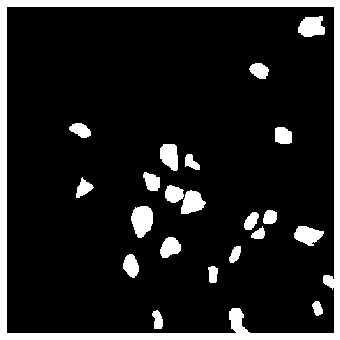

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

im = axes.imshow(np.squeeze(target), cmap = 'gray')
#     axes[0].set_title('Original {}'.format(state))

# im = axes[1].pcolormesh(np.flipud(np.squeeze(weighted_maskk)), cmap='jet')
# divider = make_axes_locatable(axes[1])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax)
# axes[1].set_title('Weights')
axes.set_axis_off()
plt.savefig('paper_yellow/crop_mask_{}.jpeg'.format(name.split('.')[0]), dpi = 900)

plt.show()

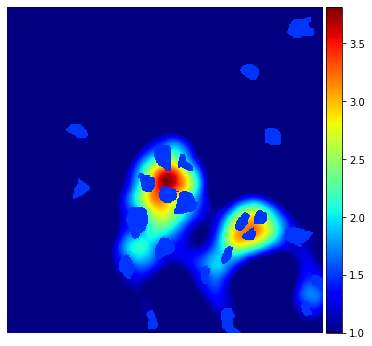

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
im = axes.pcolormesh(np.flipud(np.squeeze(weighted_maskk)), 
                     cmap='jet')
divider = make_axes_locatable(axes)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
axes.set_axis_off()
plt.savefig('paper_yellow/crop_weigths_{}.jpeg'.format(name.split('.')[0]), dpi = 900)
# axes.set_title('Weights')

In [15]:
np.max(weighted_maskk)

3.8177538

Text(0.5, 1.0, 'Weights')

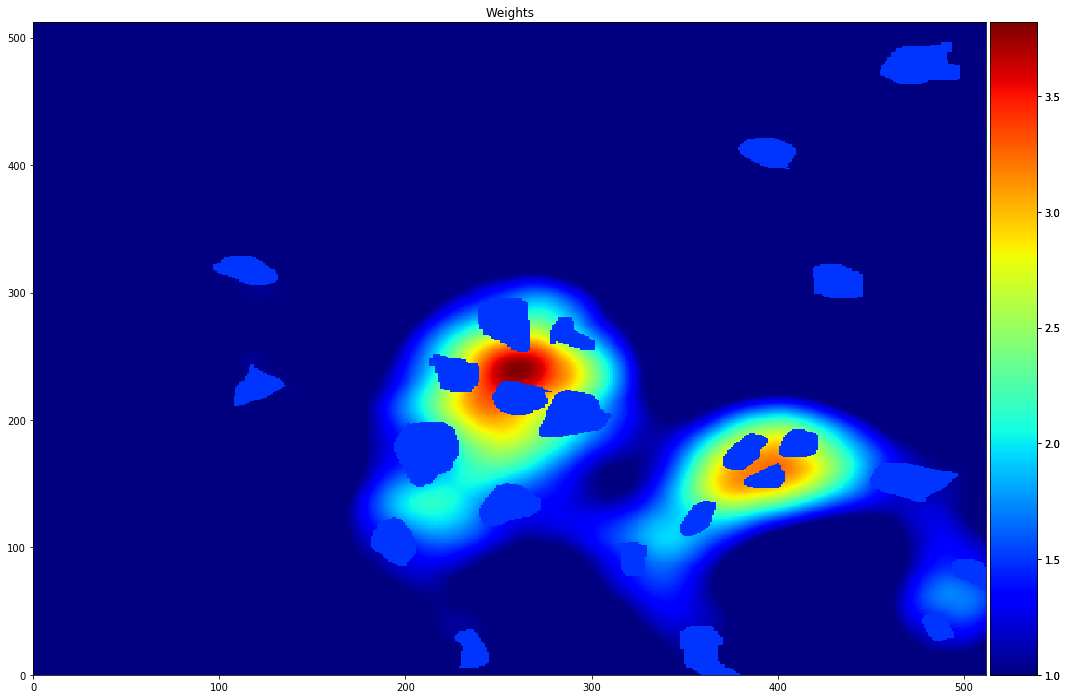

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(18, 12))

im = axes.pcolormesh(np.flipud(np.squeeze(weighted_maskk)), cmap='jet')
divider = make_axes_locatable(axes)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
axes.set_title('Weights')

im = axes.pcolormesh(np.flipud(np.squeeze(weighted_maskk)), cmap='jet')
divider = make_axes_locatable(axes)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
axes.set_title('Weights')

Text(0.5,1,'Weights')

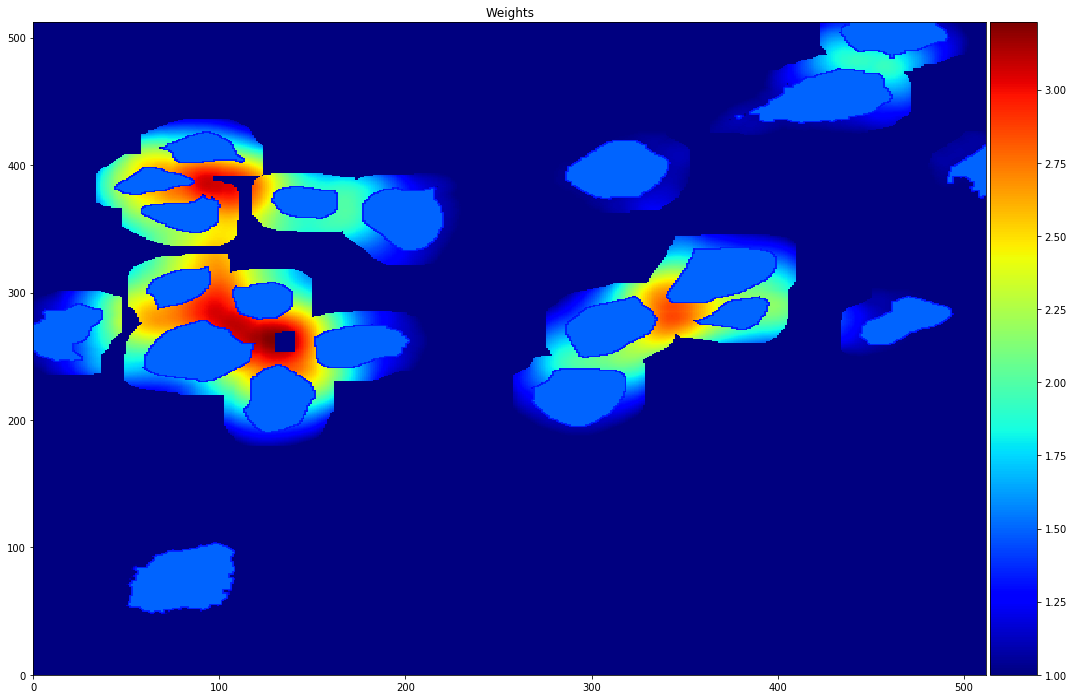

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(18, 12))

im = axes.pcolormesh(np.flipud(np.squeeze(weighted_maskkk)), cmap='jet')
divider = make_axes_locatable(axes)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
axes.set_title('Weights')

### Unet Version

In [ ]:
def mask_to_masks(target):
    
    h, w, _ = target.shape
    
    mask, n_msk = ndimage.label(target[:,:,0:1])
    mask_objs = ndimage.find_objects(mask)
    
    masks = np.zeros((h,w,n_msk),dtype=np.bool)
    
    for i, obj in enumerate(mask_objs):
        masks[:,:, i][obj[0].start:obj[0].stop,obj[1].start:obj[1].stop] = np.squeeze(mask[obj],axis = -1)
        
    masks = np.clip(masks, 0, 1).astype(np.uint8)
    return masks, n_msk

In [ ]:
# total = np.zeros((len(image_ids), 512, 512), dtype=np.float32)
def make_weights_unet(image_ids, maximum=6.538698):

        maximum = maximum
        
        w0 = 6
        sigma = 5
        null = np.zeros((512, 512), dtype = np.float32)
        
        
        for i, name in tqdm(enumerate(image_ids), total=len(image_ids)):
            #Convert to masks
            mask = read_masks_aug(name)[:,:,0:1]
            
            mask = np.clip(mask, 0 , 1)

            mask_ero = erosion(np.squeeze(mask), selem=np.ones([3,3]))
            mask_ero = np.squeeze(mask)
            mask_ero = np.expand_dims(mask_ero, -1)


            masks, n_mask = mask_to_masks(mask_ero)
            masks = masks.astype(np.uint8)

            distance = ndimage.distance_transform_edt(mask_ero == 0) 
            distances = np.zeros((distance.shape[0], distance.shape[1], n_mask), dtype = np.float32)
            
            if n_mask < 2:
                
                w = np.ones((distance.shape[0], distance.shape[1]), dtype = np.float32)
                
            else:
                w = np.zeros((distance.shape[0], distance.shape[1]), dtype = np.float32)
                
                for h in range(n_mask):
                    distances[:,:,h] = ndimage.distance_transform_edt(masks[:,:,h] == 0) 
                shortest_dist = np.sort(distances, axis=2)



                for k in range(distances.shape[0]):

                    for j in range(distances.shape[1]):

                        if distance[k, j] > 0:

                            # distance to the border of the nearest cell
                            d1 = shortest_dist[k,j, 0:1][0]
                            # distance to the border of the second nearest cell
                            d2 = shortest_dist[k,j, 1:2][0] if n_mask > 1 else 0

                            w[k, j] = 1 + w0 * np.exp(-(d1 + d2) ** 2 / (2 * sigma ** 2)).astype(np.float32)

                        else:

                            w[k,j] = 1

#             total[i] = w
            
            
            if (w.max()/(maximum+0.0001))> 1:
                    
                break

            w = w*1/maximum
                

            final_target = np.dstack((mask, w, null))
            
            aug_mask_dir = SaveWeightMasks_3 + '{}'.format(name)

            print('saving {}'.format(name))
            plt.imsave(fname=aug_mask_dir,arr = final_target)

In [ ]:
make_weights_unet(image_ids)